# atmodeller: Fugacity Coefficients for Non-Ideality


In [1]:
import numpy as np
import pandas as pd
from atmodeller import __version__, debug_logger, debug_file_logger
from typing import Type
from pytest import approx


from atmodeller.eos.holland import get_holland_fugacity_models, CORKSimpleCO2HP91, CORKCO2HP98
from atmodeller.eos.saxena import H2LowPressureSS92, H2HighPressureSS92, H2HighPressureSF88, H2HighPressureSS92_Refit, H2HighPressureSF88_Refit, get_saxena_fugacity_models

debug_logger()

In [2]:
#Plotting Tools:
import matplotlib
import matplotlib.pyplot as plt
plt.rc("savefig", dpi=300)
plt.rc('figure', dpi=300)
plt.rc('text', usetex=True)
plt.rc('font', size=15)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [0.5, 1.1])

font={'weight':'bold',
     'size': 15}
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (7,5)

### Shi & Saxena and Saxena & Fei Models

In [3]:
SS_model_lo = H2LowPressureSS92()
SS_model_hi = H2HighPressureSS92_Refit()


SS_model_lo.volume(temperature=673, pressure=5)

print(SS_model_hi.get_value(temperature=266, pressure=9670))
print(SS_model_hi.volume(temperature=1673, pressure=3000)*10)
print(SS_model_hi.volume(temperature=1473, pressure=10000)*10)
print(SS_model_hi.volume(temperature=1473, pressure=2000)*10)


413.1205180601826
58.488802023674054
24.954835037882802
74.01244017424102


In [4]:
SF_model_hi = H2HighPressureSF88()
SF_model_hi_refit = H2HighPressureSF88_Refit()
print(SF_model_hi.volume(temperature=2000, pressure=4000)*10)
print(SF_model_hi_refit.volume(temperature=2000, pressure=4000)*10)

874.9211562666428
52.6303666312771


In [55]:
SS_models = get_saxena_fugacity_models()

print(SS_models.keys())

SS_model_CO = SS_models['CO']
SS_model_CO2 = SS_models['CO2']
SS_model_CH4 = SS_models['CH4']
SS_model_H2 = SS_models['H2']
SS_model_O2 = SS_models['O2']
SS_model_S2 = SS_models['S2']
SS_model_SO2 = SS_models['SO2']
SS_model_H2S = SS_models['H2S']

print(SS_model_H2.get_value(temperature=266, pressure=9670))
print(SS_model_H2.volume(temperature=266, pressure=9670))

dict_keys(['CH4', 'CO', 'CO2', 'COS', 'H2', 'H2S', 'O2', 'S2', 'SO2'])
413.1205180601826
1.4001350698336346


In [81]:
R: float = constants.gas_constant  # Gas Constant (J/K/mol)

def calc_Z_fromV(model_vol, temperature, pressure):
    Z = ((pressure)*(model_vol/10))/(R*temperature)
    return Z

def calc_Z_fromV_arr(model, T_arr, P_arr):
    Z_arr = []
    for t,p in zip(T_arr, P_arr):
        vol = model.volume(temperature=t, pressure=p)*10 #g/cm3
        Z = (p*vol/10)/(R*t)
        Z_arr.append(Z)
    return Z_arr

SS_model_H2_Z_try = calc_Z_fromV(SS_model_H2.volume(temperature=20.35, pressure=1)*10, 20.35, 1)
print(SS_model_H2_Z_try)



0.9218622568615645


In [6]:
print(SS_model_H2.volume(temperature=3246, pressure=107200)*10)
print(SS_model_H2.volume(temperature=3462, pressure=114540)*10)
print(SS_model_H2.volume(temperature=722, pressure=25630)*10)
print(SS_model_H2.volume(temperature=266, pressure=9670)*10)

8.995391992358009
8.863075311882685
12.009917104020765
14.001350698336346


#### Re-Fitting Shi & Saxena High-Pressure H2 Model 

In [7]:
from scipy import constants, integrate
import numpy as np
R: float = constants.gas_constant  # Gas Constant (J/K/mol)
#Load Data from Presnall and Ross & Ree:

H2_HighP_Data: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
df_H2Data: pd.DataFrame = pd.read_csv(H2_HighP_Data, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
df_H2Data['Z'] = (df_H2Data['P_GPa']*1e4)*(df_H2Data['V_cm3mol']/10)/(R*df_H2Data['T_K'])
#print(df_H2Data)
print(df_H2Data['P_GPa'])
print(df_H2Data['Z'])

0      0.000100
1      0.967000
2      1.573000
3      2.563000
4      4.166000
         ...   
111    0.141855
112    0.151987
113    0.162120
114    0.172253
115    0.182385
Name: P_GPa, Length: 116, dtype: float64
0      0.016785
1      6.121230
2      5.706379
3      5.123402
4      4.510312
         ...   
111    1.291585
112    1.310567
113    1.330274
114    1.348879
115    1.365418
Name: Z, Length: 116, dtype: float64


In [8]:
from scipy import constants

R: float = constants.gas_constant  # Gas Constant (J/K/mol)
Pc: float = 12.9696 #Critical pressure, bar
Tc: float = 33.25 #Critical temperature, K

#functional form of Saxena & Fei 1988:
def coeffmatrix_SF88():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), (1/Tr), (Tr**-2), np.log(Tr), Pr, (Pr/Tr), (Pr/(Tr**2)), np.log(Tr)*Pr, (Pr**2), (Pr**2)/Tr, (Pr/Tr)**2, np.log(Tr)*(Pr**2), (Pr**3), (Pr**3)/Tr, (Pr**3)/(Tr**2), np.log(Tr)*(Pr**3)])
    coeff_matrix = x.transpose()
    return coeff_matrix

#Not including the last coefficient (d3), as they do in Table on pg. 1196
def coeffmatrix_SF88_select():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), (1/Tr), (Tr**-2), np.log(Tr), Pr, (Pr/Tr), (Pr/(Tr**2)), np.log(Tr)*Pr, (Pr**2), (Pr**2)/Tr, (Pr/Tr)**2, np.log(Tr)*(Pr**2), (Pr**3), (Pr**3)/Tr, (Pr**3)/(Tr**2)])
    coeff_matrix = x.transpose()
    return coeff_matrix

print(coeffmatrix_SF88())

[[ 1.00000000e+00  1.63390663e+00  2.66965089e+00 ...  7.48940799e-04
   1.22369934e-03 -2.25049794e-04]
 [ 1.00000000e+00  1.25000000e-01  1.56250000e-02 ...  5.18095344e+07
   6.47619180e+06  8.61879184e+08]
 [ 1.00000000e+00  7.71461717e-02  5.95153181e-03 ...  1.37632437e+08
   1.06178156e+07  4.57082491e+09]
 ...
 [ 1.00000000e+00  3.80805131e-02  1.45012548e-03 ...  7.43760021e+04
   2.83227632e+03  6.38291523e+06]
 [ 1.00000000e+00  3.80805131e-02  1.45012548e-03 ...  8.92112545e+04
   3.39721034e+03  7.65606995e+06]
 [ 1.00000000e+00  3.80805131e-02  1.45012548e-03 ...  1.05898644e+05
   4.03267468e+03  9.08817422e+06]]


In [9]:
#Functional form of Shi & Saxena 1992
def coeffmatrix_SS92_all():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), Tr, (1/Tr), (Tr**2), (Tr**-2), (Tr**3), (Tr**-3), np.log(Tr), Pr, Pr*Tr, Pr/Tr, Pr*(Tr**2), Pr*(Tr**-2), Pr*(Tr**3), Pr*(Tr**-3), Pr*np.log(Tr), 
    (Pr**2), (Pr**2)*Tr, (Pr**2)/Tr, (Pr**2)*(Tr**2), (Pr**2)/(Tr**2), (Pr**2)*(Tr**3), (Pr**2)/(Tr**3), (Pr**2)*np.log(Tr), (Pr**3), (Pr**3)*Tr,
    (Pr**3)/Tr, (Pr**3)*(Tr**2), (Pr**3)/(Tr**2), (Pr**3)*(Tr**3), (Pr**3)/(Tr**3), (Pr**3)*np.log(Tr)])
    coeff_matrix = x.transpose()
    return coeff_matrix

def coeffmatrix_SS92_select():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), (1/Tr), (Tr**-2), np.log(Tr), Pr, Pr/Tr, Pr*(Tr**-2), Pr*np.log(Tr), 
    (Pr**2), (Pr**2)/Tr, (Pr**2)/(Tr**2), (Pr**2)*np.log(Tr), (Pr**3), (Pr**3)/Tr, (Pr**3)/(Tr**2)])
    coeff_matrix = x.transpose()
    return coeff_matrix

def coeffmatrix_SS92_select_onlyRossRee():
    datafile: str = f"data/FugacityCoeff_FittingData/RossRee_H2_HighP.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'P_Pa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), (1/Tr), (Tr**-2), np.log(Tr), Pr, Pr/Tr, Pr*(Tr**-2), Pr*np.log(Tr), 
    (Pr**2), (Pr**2)/Tr, (Pr**2)/(Tr**2), (Pr**2)*np.log(Tr), (Pr**3), (Pr**3)/Tr, (Pr**3)/(Tr**2)])
    coeff_matrix = x.transpose()
    return coeff_matrix

In [10]:
def lsqfit_Z_H2(coeff_matrix):
    """Fit H2 compressibility factor

    Returns:
        The least-squares fit coefficients.
    """
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    # Least squares fitting.
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    V: np.ndarray = df['V_cm3mol'].to_numpy()
    T: np.ndarray = df['T_K'].to_numpy()
    Z: np.ndarray = ((P_bar*V)/10)/(R*T)
    print('Compressibility Factor Z:', Z)
    #design_matrix: np.ndarray = pressure[:, np.newaxis]**[1, 0]
    #print('design matrix:', design_matrix)
    solution, _, _, _ = np.linalg.lstsq(coeff_matrix, Z, rcond=None)
    return solution

def lsqfit_Z_H2_RossReeOnly(coeff_matrix):
    """Fit H2 compressibility factor

    Returns:
        The least-squares fit coefficients.
    """
    datafile: str = f"data/FugacityCoeff_FittingData/RossRee_H2_HighP.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'P_Pa', 'T_K'))
    # Least squares fitting.
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    V: np.ndarray = df['V_cm3mol'].to_numpy()
    T: np.ndarray = df['T_K'].to_numpy()
    Z: np.ndarray = ((P_bar*V)/10)/(R*T)
    #design_matrix: np.ndarray = pressure[:, np.newaxis]**[1, 0]
    #print('design matrix:', design_matrix)
    solution, _, _, _ = np.linalg.lstsq(coeff_matrix, Z, rcond=None)
    return solution

def lsqfit_V_H2(coeff_matrix):
    """Fit H2 Volume
    
    Returns:
        The least-squares fit coefficients.
    """
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    # Least squares fitting.
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    V: np.ndarray = df['V_cm3mol'].to_numpy()
    T: np.ndarray = df['T_K'].to_numpy()
    #Z: np.ndarray = ((P_bar*V)/10)/(R*T)
    #design_matrix: np.ndarray = pressure[:, np.newaxis]**[1, 0]
    #print('design matrix:', design_matrix)
    solution, _, _, _ = np.linalg.lstsq(coeff_matrix, V, rcond=None)
    return solution




In [11]:
SF88_Coeffs = lsqfit_Z_H2(coeffmatrix_SF88())
SF88_Coeffs_select = lsqfit_Z_H2(coeffmatrix_SF88_select())

SS92_Coeffs = lsqfit_Z_H2(coeffmatrix_SS92_all())
SS92_Coeffs_select = lsqfit_Z_H2(coeffmatrix_SS92_select())
SS92_Coeffs_selectRR = lsqfit_Z_H2_RossReeOnly(coeffmatrix_SS92_select_onlyRossRee())

SS92_Coeffs_select_fitV = lsqfit_V_H2(coeffmatrix_SS92_select())


print('Saxena and Fei 1988, Coefficients for High-P:', SF88_Coeffs)
print('')
print('Saxena and Fei 1988, Coefficients for High-P select:', SF88_Coeffs_select)


Compressibility Factor Z: [0.01678494 6.12122986 5.70637909 5.12340243 4.51031174 3.9939499
 3.57482342 3.52557252 1.04184259 1.0410699  1.06090226 1.08382537
 1.08279512 1.12349009 1.12503546 1.16727581 1.20925859 1.25021111
 1.24866573 1.28910314 1.33108591 1.37113697 1.40938509 1.44917858
 1.45059518 1.48850846 1.52783834 1.56783788 1.6052618  1.6426342
 1.6434584  1.68137168 1.71490639 1.71444278 1.03356966 1.05089859
 1.05026071 1.06907802 1.06610127 1.10160963 1.10160963 1.13456649
 1.13541699 1.16837385 1.20303171 1.20175596 1.23683907 1.23535069
 1.27064643 1.30317804 1.33741065 1.3675396  1.36941069 1.40077287
 1.43375099 1.46515569 1.49709195 1.52579631 1.52817771 1.55826413
 1.58601168 1.02721158 1.05400526 1.08242828 1.10940299 1.11012715
 1.13692082 1.16769734 1.1963014  1.22671584 1.2529664  1.27994112
 1.30637272 1.33389055 1.36196959 1.3884193  1.41427157 1.44135491
 1.46650114 1.49019906 1.0229711  1.04598401 1.06962741 1.09705375
 1.12069715 1.14528629 1.16956018 1.19

In [12]:
print('Shi and Saxena 1992, All Coefficients:', SS92_Coeffs)
print('')
print('Shi and Saxena 1992, Select Coefficients:', SS92_Coeffs_select)
print('')
print('Shi and Saxena 1992, Select Coefficients, Ross Ree only:', SS92_Coeffs_selectRR)

Shi and Saxena 1992, All Coefficients: [ 1.02066469e-07  2.11944254e-07  5.67598631e-10  4.59145069e-06
  3.05701259e-11  1.02169911e-04  1.90182359e-12  3.17248298e-08
  5.54605962e-08  4.96060175e-07  5.23400578e-09  2.80775878e-06
  4.62445358e-10 -3.74871652e-07  4.04910278e-11  1.27564782e-07
  3.42167973e-06  2.06970671e-05  4.20529591e-07 -1.22541597e-06
  5.35323893e-08  1.49533352e-08  7.18397985e-09  7.00940513e-06
  3.55544387e-07  2.30499179e-08 -2.23053847e-06 -2.40225720e-10
  4.51057396e-06  2.12507121e-13  1.85743628e-06 -2.19622511e-07]

Shi and Saxena 1992, Select Coefficients: [ 1.00574428e+00  1.93022092e-03 -3.79261142e-01 -2.44217972e-03
  1.31517888e-03  7.22328441e-02  4.84354163e-02 -4.19624507e-04
  2.64454401e-06 -5.18445629e-05 -2.05045979e-04 -3.64843213e-07
  2.28281107e-11 -1.07138603e-08  3.67720815e-07]

Shi and Saxena 1992, Select Coefficients, Ross Ree only: [ 1.51032964e-03  2.46762415e-03  4.03184200e-03 -7.41402014e-04
  1.20303777e-04  1.97842230e

#### Calculating Fugacity Coefficient using Shi & Saxena Eq. 11

In [13]:
def fug_coeff_eq11(coeffs, T, P, P0):
    Tr = T/Tc
    Pr = P/Pc
    P0r = P0/Pc
    A_term = coeffs[0] + (coeffs[1]*(1/Tr)) + (coeffs[2]*(Tr**-2)) + (coeffs[3]*np.log(Tr))
    B_term = coeffs[4] + (coeffs[5]*(1/Tr)) + (coeffs[6]*(Tr**-2)) + (coeffs[7]*np.log(Tr))
    C_term = coeffs[8] + (coeffs[9]*(1/Tr)) + (coeffs[10]*(Tr**-2)) + (coeffs[11]*np.log(Tr))
    D_term = coeffs[12] + (coeffs[13]*(1/Tr)) + (coeffs[14]*(Tr**-2)) 
    Zint = (A_term*(np.log(Pr/P0r))) + (B_term*(Pr-P0r)) + ((C_term/2)*((Pr**2)-(P0r**2))) + ((D_term/3)*((Pr**3)-(P0r**3)))
    #print('Z/P dP is:', Zint)
    fugacity = np.exp(Zint)
    #print('Fugacity is:', fugacity)
    #print('Pressure is:', P)
    phi = fugacity/P
    return phi

def fug_coeff_eq11_fullcoeffs(coeffs, T, P, P0):
    Tr = T/Tc
    Pr = P/Pc
    P0r = P0/Pc
    A_term = coeffs[0] + (coeffs[1]*(Tr)) + (coeffs[2]*(1/Tr)) + (coeffs[3]*(Tr**2)) + (coeffs[4]*(Tr**-2)) + (coeffs[5]*(Tr**3)) + (coeffs[6]*(Tr**-3)) + (coeffs[7]*np.log(Tr))
    B_term = coeffs[8] + (coeffs[9]*(Tr)) + (coeffs[10]*(1/Tr)) + (coeffs[11]*(Tr**2)) + (coeffs[12]*(Tr**-2)) + (coeffs[13]*(Tr**3)) + (coeffs[14]*(Tr**-3)) + (coeffs[15]*np.log(Tr))
    C_term = coeffs[16] + (coeffs[17]*(Tr)) + (coeffs[18]*(1/Tr)) + (coeffs[19]*(Tr**2)) + (coeffs[20]*(Tr**-2)) + (coeffs[21]*(Tr**3)) + (coeffs[22]*(Tr**-3)) + (coeffs[23]*np.log(Tr))
    D_term = coeffs[24] + (coeffs[25]*(Tr)) + (coeffs[26]*(1/Tr)) + (coeffs[27]*(Tr**2)) + (coeffs[28]*(Tr**-2)) + (coeffs[29]*(Tr**3)) + (coeffs[30]*(Tr**-3)) + (coeffs[31]*np.log(Tr))
    Zint = (A_term*(np.log(Pr/P0r))) + (B_term*(Pr-P0r)) + ((C_term/2)*((Pr**2)-(P0r**2))) + ((D_term/3)*((Pr**3)-(P0r**3)))
    #print('Z/P dP is:', Zint)
    fugacity = np.exp(Zint)
    #print('Fugacity is:', fugacity)
    #print('Pressure is:', P)
    phi = fugacity/P
    return phi

def fug_coeff_eq11_arr(coeffs, T_arr, P_arr, P0):
    phi_arr = []
    for t,p in zip(T_arr, P_arr):
        Tr = t/Tc
        Pr = p/Pc
        P0r = P0/Pc
        A_term = coeffs[0] + (coeffs[1]*(1/Tr)) + (coeffs[2]*(Tr**-2)) + (coeffs[3]*np.log(Tr))
        B_term = coeffs[4] + (coeffs[5]*(1/Tr)) + (coeffs[6]*(Tr**-2)) + (coeffs[7]*np.log(Tr))
        C_term = coeffs[8] + (coeffs[9]*(1/Tr)) + (coeffs[10]*(Tr**-2)) + (coeffs[11]*np.log(Tr))
        D_term = coeffs[12] + (coeffs[13]*(1/Tr)) + (coeffs[14]*(Tr**-2)) 
        Zint = (A_term*(np.log(Pr/P0r))) + (B_term*(Pr-P0r)) + ((C_term/2)*((Pr**2)-(P0r**2))) + ((D_term/3)*((Pr**3)-(P0r**3)))
        fugacity = np.exp(Zint)
        phi = fugacity/p
        phi_arr.append(phi)
    return phi_arr

#### Calculating Z from Shi & Saxena Fit, Fugacity Coefficient from Volume and Int V - Videal

In [60]:
def Z_Calc(coeffs, T, P):
    Tr = T/Tc
    Pr = P/Pc
    A_term = coeffs[0] + (coeffs[1]*(1/Tr)) + (coeffs[2]*(Tr**-2)) + (coeffs[3]*np.log(Tr))
    B_term = coeffs[4] + (coeffs[5]*(1/Tr)) + (coeffs[6]*(Tr**-2)) + (coeffs[7]*np.log(Tr))
    C_term = coeffs[8] + (coeffs[9]*(1/Tr)) + (coeffs[10]*(Tr**-2)) + (coeffs[11]*np.log(Tr))
    D_term = coeffs[12] + (coeffs[13]*(1/Tr)) + (coeffs[14]*(Tr**-2)) 
    Z = (A_term) + (B_term*Pr) + ((C_term)*(Pr**2)) + ((D_term)*(Pr**3))
    return Z

def Volume_fromZfit(coeffs, T, P):
    Tr = T/Tc
    Pr = P/Pc
    A_term = coeffs[0] + (coeffs[1]*(1/Tr)) + (coeffs[2]*(Tr**-2)) + (coeffs[3]*np.log(Tr))
    B_term = coeffs[4] + (coeffs[5]*(1/Tr)) + (coeffs[6]*(Tr**-2)) + (coeffs[7]*np.log(Tr))
    C_term = coeffs[8] + (coeffs[9]*(1/Tr)) + (coeffs[10]*(Tr**-2)) + (coeffs[11]*np.log(Tr))
    D_term = coeffs[12] + (coeffs[13]*(1/Tr)) + (coeffs[14]*(Tr**-2)) 
    Z = (A_term) + (B_term*Pr) + ((C_term)*(Pr**2)) + ((D_term)*(Pr**3))
    #print('Z:', Z)
    V = ((R*T*Z)/P)*10 #units cm3/mol
    #print('V calculated is:', V)
    return V

def Volume_fromZfit_arr(coeffs, T_arr, P_arr):
    V_arr = []
    for t,p in zip(T_arr, P_arr):
        Tr = t/Tc
        Pr = p/Pc
        A_term = coeffs[0] + (coeffs[1]*(1/Tr)) + (coeffs[2]*(Tr**-2)) + (coeffs[3]*np.log(Tr))
        B_term = coeffs[4] + (coeffs[5]*(1/Tr)) + (coeffs[6]*(Tr**-2)) + (coeffs[7]*np.log(Tr))
        C_term = coeffs[8] + (coeffs[9]*(1/Tr)) + (coeffs[10]*(Tr**-2)) + (coeffs[11]*np.log(Tr))
        D_term = coeffs[12] + (coeffs[13]*(1/Tr)) + (coeffs[14]*(Tr**-2)) 
        Z = (A_term) + (B_term*Pr) + ((C_term)*(Pr**2)) + ((D_term)*(Pr**3))
        V = ((R*t*Z)/p)*10 #units cm3/mol
        V_arr.append(V)
    return V_arr

def Z_Calc_Arr(coeffs, T_arr, P_arr):
    Z_arr = []
    for t,p in zip(T_arr, P_arr):
        Tr = t/Tc
        Pr = p/Pc
        A_term = coeffs[0] + (coeffs[1]*(1/Tr)) + (coeffs[2]*(Tr**-2)) + (coeffs[3]*np.log(Tr))
        B_term = coeffs[4] + (coeffs[5]*(1/Tr)) + (coeffs[6]*(Tr**-2)) + (coeffs[7]*np.log(Tr))
        C_term = coeffs[8] + (coeffs[9]*(1/Tr)) + (coeffs[10]*(Tr**-2)) + (coeffs[11]*np.log(Tr))
        D_term = coeffs[12] + (coeffs[13]*(1/Tr)) + (coeffs[14]*(Tr**-2)) 
        Z = (A_term) + (B_term*Pr) + ((C_term)*(Pr**2)) + ((D_term)*(Pr**3))
        Z_arr.append(Z)
    return Z_arr




In [15]:
#This is not the correct way to integrate, unless V-Videal << dP:

def fug_coeff_fromVfit(T, P, Vcalc, P0):
    Videal = ((R*T)/P)*10 #cm3/mol
    integral = ((Vcalc-Videal)*(P-P0))/10
    lnphi = integral/(R*T)
    phi = np.exp(lnphi)
    return phi

def fug_coeff_fromVfit_arr(T_arr, P_arr, V_calc_arr, P0):
    phi_arr = []
    for t,p,v in zip(T_arr, P_arr, V_calc_arr):
        Videal = ((R*t)/p)*10 #cm3/mol
        integral = ((v-Videal)*(p-P0))/10
        lnphi = integral/(R*t)
        phi = np.exp(lnphi)
        phi_arr.append(phi)
    return  phi_arr

def fug_coeff_fromV_Zfit_arr(coeffs, T_arr, P_arr, P0):
    V_arr = []
    phi_arr = []
    for t,p in zip(T_arr, P_arr):
        Tr = t/Tc
        Pr = p/Pc
        A_term = coeffs[0] + (coeffs[1]*(1/Tr)) + (coeffs[2]*(Tr**-2)) + (coeffs[3]*np.log(Tr))
        B_term = coeffs[4] + (coeffs[5]*(1/Tr)) + (coeffs[6]*(Tr**-2)) + (coeffs[7]*np.log(Tr))
        C_term = coeffs[8] + (coeffs[9]*(1/Tr)) + (coeffs[10]*(Tr**-2)) + (coeffs[11]*np.log(Tr))
        D_term = coeffs[12] + (coeffs[13]*(1/Tr)) + (coeffs[14]*(Tr**-2)) 
        Z = (A_term) + (B_term*Pr) + ((C_term)*(Pr**2)) + ((D_term)*(Pr**3))
        V = ((R*t*Z)/p)*10 #units cm3/mol
        V_arr.append(V)
        Videal = ((R*t)/p)*10 #cm3/mol
        integral = ((V-Videal)*(p-P0))/10
        lnphi = integral/(R*t)
        phi = np.exp(lnphi)
        phi_arr.append(phi)
    return  phi_arr

In [89]:
P_arr_RR = [1, 9670, 15730, 25630, 41660, 66880, 107200, 114540]
T_arr_RR = [20.35, 266, 431, 722, 1222, 2014, 3246, 3462]

T_arr_Presnall = [873.15]*9
P_arr_Presnall = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800]

Volume_calc = Volume_fromZfit(SS92_Coeffs_select, 266, 9670)
Z_calc = Z_Calc(SS92_Coeffs_select, 266, 9670)
Volume_calc_RR = Volume_fromZfit_arr(SS92_Coeffs_select, T_arr_RR, P_arr_RR)
Volume_calc_P = Volume_fromZfit_arr(SS92_Coeffs_select, T_arr_Presnall, P_arr_Presnall)

#Z calculated from coefficients:
Z_calc_arr_RR = Z_Calc_Arr(SS92_Coeffs_select, T_arr_RR, P_arr_RR)
Z_calc_arr_Presnall = Z_Calc_Arr(SS92_Coeffs_select, T_arr_Presnall, P_arr_Presnall)

print(df_H2Data['Z'])
print(Z_calc_arr_RR)
print(Z_calc_arr_Presnall)

#Z calculated in atmodeller:
SS_model_H2_Zarr = calc_Z_fromV_arr(SS_model_H2, T_arr_RR, P_arr_RR)
SS_model_H2_Zarr_P = calc_Z_fromV_arr(SS_model_H2, T_arr_Presnall, P_arr_Presnall)
print(SS_model_H2_Zarr)


0      0.016785
1      6.121230
2      5.706379
3      5.123402
4      4.510312
         ...   
111    1.291585
112    1.310567
113    1.330274
114    1.348879
115    1.365418
Name: Z, Length: 116, dtype: float64
[0.016785607056936252, 6.1218204293029705, 5.703898555691437, 5.12763653955988, 4.50642113765825, 3.9960720388311124, 3.5729930312617064, 3.526796157503]
[1.0397262597446404, 1.0817794431832521, 1.12344944404569, 1.1647395203860405, 1.2056529302583898, 1.246192931716825, 1.286362782815432, 1.3261657416082977, 1.3656050661495085]
[0.9218622568615645, 6.12182042617743, 5.703898551656959, 5.127636535830308, 4.506421138466044, 3.9960720571320296, 3.5729931053462596, 3.5267962457502025]


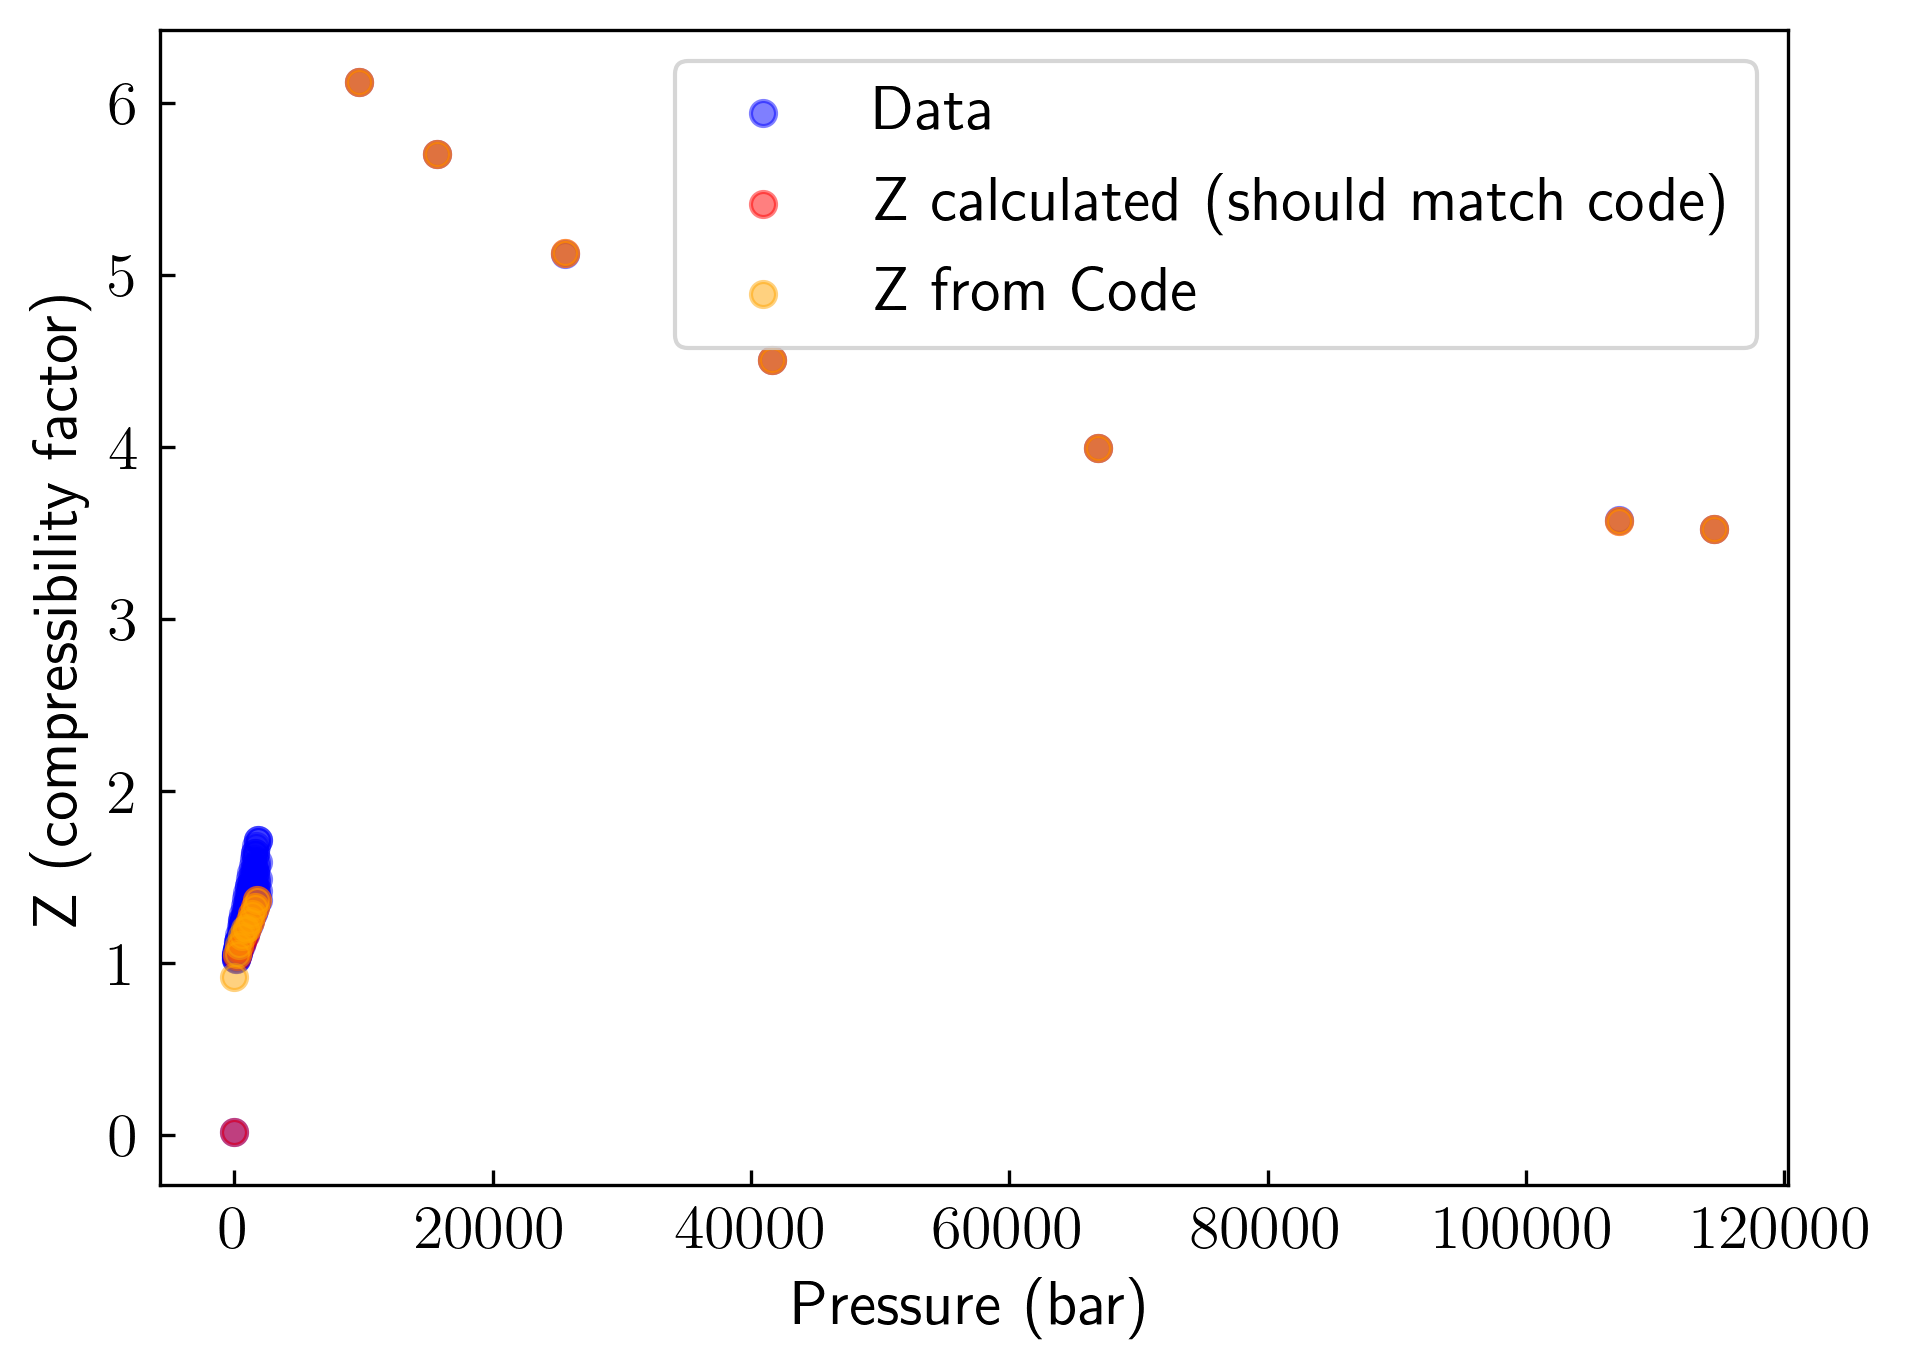

In [90]:
fig,ax = plt.subplots()
plt.scatter(df_H2Data['P_GPa']*1e4, df_H2Data['Z'], color='blue', alpha=0.5, label='Data')
plt.scatter(P_arr_RR, Z_calc_arr_RR, alpha=0.5, color='red', label='Z calculated (should match code)')
plt.scatter(P_arr_Presnall, Z_calc_arr_Presnall, alpha=0.5, color='red')

plt.scatter(P_arr_RR, SS_model_H2_Zarr, alpha=0.5, color='orange', label='Z from Code')
plt.scatter(P_arr_Presnall, SS_model_H2_Zarr_P, alpha=0.5, color='orange')

plt.xlabel('Pressure (bar)')
plt.ylabel('Z (compressibility factor)')
plt.legend()
plt.show()

In [17]:
phi_calc_fromV = fug_coeff_fromVfit(266, 9670, Volume_calc, 1)
print(phi_calc_fromV)

phi_calc_fromV_arr_RR = fug_coeff_fromVfit_arr(T_arr_RR, P_arr_RR, Volume_calc_RR, 1)
phi_calc_fromV_arr_P = fug_coeff_fromVfit_arr(T_arr_Presnall, P_arr_Presnall, Volume_calc_P, 1)

print(phi_calc_fromV_arr_RR)
#print(phi_calc_fromV_arr_P)

phi_calc_allinone_arr_RR = fug_coeff_fromV_Zfit_arr(SS92_Coeffs_select, T_arr_RR, P_arr_RR, 1)
phi_calc_allinone_arr_P = fug_coeff_fromV_Zfit_arr(SS92_Coeffs_select, T_arr_Presnall, P_arr_Presnall, 1)
phi_calc_allinone_arr_test = fug_coeff_fromV_Zfit_arr(SS92_Coeffs_select, [2000], [100000], 1)

print(phi_calc_allinone_arr_RR)
#print(phi_calc_allinone_arr_P)
print(phi_calc_allinone_arr_test)

167.55150029442743
[1.0, 167.55150029442743, 110.34364215048382, 62.021152268642155, 33.32596990555923, 20.005900221129462, 13.104674904178125, 12.513074993612495]
[1.0, 167.55150029442743, 110.34364215048382, 62.021152268642155, 33.32596990555923, 20.005900221129462, 13.104674904178125, 12.513074993612495]
[0.010019391442784492]


In [18]:
phi_calc_select = fug_coeff_eq11(SS92_Coeffs_select, 266, 9670, 1)
#phi_calc_all = fug_coeff_eq11_fullcoeffs(SS92_Coeffs, 3462, 114540, 1)
phi_calc_selectRR = fug_coeff_eq11(SS92_Coeffs_selectRR, 266, 9670, 1)
print(phi_calc_select)
#print('')
#print(phi_calc_all)
#print(phi_calc_selectRR)
#print(SS_model_H2.get_value(temperature=873.15, pressure=1823.85))

phi_calc_eq11 = fug_coeff_eq11_arr(SS92_Coeffs_select, T_arr_RR, P_arr_RR, 1)
print(phi_calc_eq11)

413.12051818441887
[1.0, 413.12051818441887, 274.6118926217424, 156.54893126645493, 99.24085313880134, 114.61827370765091, 569.3060079794765, 881.4436897819171]


In [19]:
print(SS_model_H2.get_value(temperature=266, pressure=9670))

413.1205180601826


### Holland & Powell Model

In [20]:
models = get_holland_fugacity_models()
# list the available species
print(models.keys())
# Get the fugacity model for CO
co_model = models['CO']
# Determine the fugacity coefficient at 2000 K and 1000 bar
fugacity_coefficient = co_model.get_value(temperature=2000, pressure=1000)
#print(fugacity_coefficient)

HP_model = models['H2']
H2_fug_coeff = HP_model.get_value(temperature=2000, pressure=1000)
print(H2_fug_coeff)

dict_keys(['CH4', 'CO', 'CO2', 'H2', 'H2O', 'H2S', 'S2'])
1.1665464286976006


In [21]:
HP_model_CO = models['CO']
HP_model_CH4 = models['CH4']

HP_model_H2O = models['H2O']
HP_model_CO2 = models['CO2']
HP_model_S2 = models['S2']
HP_model_H2S = models['H2S']


In [22]:
HP_CorkSimple_CO2 = CORKSimpleCO2HP91()
HP_CorkFull_CO2 = CORKCO2HP98()

### Kite et al.2019 (Derived from Saumon et al. 1995 Tables)

In [23]:
#Data extracted from Figure 2 a
Kite_datafile_2000: str = f"data/solubility_data/H2/Kite_H2FugCoeff_2000K.csv"
K19_2000_df: pd.DataFrame = pd.read_csv(Kite_datafile_2000, names=('P_GPa', 'H2_fc'))

Kite_datafile_1673: str = f"data/solubility_data/H2/Kite_H2FugCoeff_1673K.csv"
K19_1673_df: pd.DataFrame = pd.read_csv(Kite_datafile_1673, names=('P_GPa', 'H2_fc'))

Kite_datafile_2500: str = f"data/solubility_data/H2/Kite_H2FugCoeff_2500K.csv"
K19_2500_df: pd.DataFrame = pd.read_csv(Kite_datafile_2500, names=('P_GPa', 'H2_fc'))

print(K19_2000_df['P_GPa'])

0      0.026826
1      0.363343
2      0.868118
3      1.356067
4      1.810365
5      2.466573
6      3.005000
7      3.577079
8      4.098680
9      4.721236
10     5.377444
11     5.932697
12     6.353343
13     7.228287
14     7.783539
15     8.389270
16     9.112781
17     9.668034
18    10.004551
Name: P_GPa, dtype: float64


In [24]:
#Calculations of phi from Equation 2 and Saumon Tables

KS_1995_file: str = f"data/solubility_data/H2/H2_KiteSaumon_1995K.csv"
KS_1995_df: pd.DataFrame = pd.read_csv(KS_1995_file, skiprows=2, names=('logP', 'P_GPa', 'P_bar','XH2', 'XH', 'log_rho', 'rho', 'Vm', 'log_S', 'log_U', 'dlogrho_dlogT_P', 'dlogrho_dlogP_T', 
'dlogS_dlogT_P', 'dlogS_dlogP_T', 'dlogT_dlogP_S', 'ln_phi', 'phi'))

KS_2398_file: str = f"data/solubility_data/H2/H2_KiteSaumon_2398K.csv"
KS_2398_df: pd.DataFrame = pd.read_csv(KS_2398_file, skiprows=2, names=('logP', 'P_GPa', 'P_bar','XH2', 'XH', 'log_rho', 'rho', 'Vm', 'log_S', 'log_U', 'dlogrho_dlogT_P', 'dlogrho_dlogP_T', 
'dlogS_dlogT_P', 'dlogS_dlogP_T', 'dlogT_dlogP_S', 'Z', 'Int', 'phi'))

KS_2884_file: str = f"data/solubility_data/H2/H2_KiteSaumon_2884K.csv"
KS_2884_df: pd.DataFrame = pd.read_csv(KS_2884_file, skiprows=2, names=('logP', 'P_GPa', 'P_bar','XH2', 'XH', 'log_rho', 'rho', 'Vm', 'log_S', 'log_U', 'dlogrho_dlogT_P', 'dlogrho_dlogP_T', 
'dlogS_dlogT_P', 'dlogS_dlogP_T', 'dlogT_dlogP_S', 'Z', 'Int', 'phi'))

KS_1660_file: str = f"data/solubility_data/H2/H2_KiteSaumon_1660K.csv"
KS_1660_df: pd.DataFrame = pd.read_csv(KS_1660_file, skiprows=2, names=('logP', 'P_GPa', 'P_bar','XH2', 'XH', 'log_rho', 'rho', 'Vm', 'log_S', 'log_U', 'dlogrho_dlogT_P', 'dlogrho_dlogP_T', 
'dlogS_dlogT_P', 'dlogS_dlogP_T', 'dlogT_dlogP_S', 'Z', 'Int', 'phi'))



### Looping over temperature and pressure

In [25]:
pressure_arr = np.arange(0.01, 100500, 100)
temp_arr = np.arange(470, 890, 10)

temp_arr_SF = np.arange(273, 2093, 50)
temp_arr_SF_hi = np.arange(273, 3090, 50)

temp_arr_2000 = [2000]*1005
print(len(pressure_arr))
print(len(temp_arr_2000))

1005
1005


In [26]:
def fugacitycoeff_func(model, temperature, pressure_range):
    model_arr = []
    for p in pressure_range:
        fug_val = model.get_value(temperature=temperature, pressure=p)
        model_arr.append(fug_val)
    return model_arr

def fugacitycoeff_func_T(model, temperature_range, pressure):
    model_arr = []
    for t in temperature_range:
        fug_val = model.get_value(temperature=t, pressure=pressure)
        model_arr.append(fug_val)
    return model_arr

def fugacitycoeff_func_PT(model, temperature_range, pressure_range):
    model_arr = []
    for t,p in zip(temperature_range, pressure_range):
        fug_val = model.get_value(temperature=t, pressure=p)
        model_arr.append(fug_val)
    return model_arr


def volume_func(model, temperature_range, pressure):
    model_arr = []
    for t in temperature_range:
        vol_val = model.volume(temperature=t, pressure=pressure)
        vol_val_units = vol_val*10 #Units, multiplying by 10 to convert J/bar/mol to cm^3/mol
        model_arr.append(vol_val_units)
    return model_arr

def volume_func_2(model, temperature_range, pressure_range):
    model_arr = []
    for t,p in zip(temperature_range, pressure_range):
        vol_val = model.volume(temperature=t, pressure=p)
        vol_val_units = vol_val*10 #Units, multiplying by 10 to convert J/bar/mol to cm^3/mol
        model_arr.append(vol_val_units)
    return model_arr

#### Holland & Powell Models

In [27]:
HP_2000 = fugacitycoeff_func(HP_model, 2000, pressure_arr)
HP_2500 = fugacitycoeff_func(HP_model, 2500, pressure_arr)
HP_1673 = fugacitycoeff_func(HP_model, 1673, pressure_arr)
HP_473 = fugacitycoeff_func(HP_model, 473, pressure_arr)
HP_873 = fugacitycoeff_func(HP_model, 873, pressure_arr)


#SF_2000 = fugacitycoeff_func(SF_model, 2000, pressure_arr)
#SF_2500 = fugacitycoeff_func(SF_model, 2500, pressure_arr)
#SF_1673 = fugacitycoeff_func(SF_model, 1673, pressure_arr)
#SF_300 = fugacitycoeff_func(SF_model, 300, pressure_arr)

HP_2000_CO = fugacitycoeff_func(HP_model_CO, 2000, pressure_arr)
HP_1673_CO = fugacitycoeff_func(HP_model_CO, 1673, pressure_arr)

HP_2000_CH4 = fugacitycoeff_func(HP_model_CH4, 2000, pressure_arr)
HP_2000_H2O = fugacitycoeff_func(HP_model_H2O, 2000, pressure_arr)
HP_2000_CO2 = fugacitycoeff_func(HP_model_CO2, 2000, pressure_arr)
HP_2000_H2S = fugacitycoeff_func(HP_model_H2S, 2000, pressure_arr)
HP_2000_S2 = fugacitycoeff_func(HP_model_S2, 2000, pressure_arr)

[10:16:38 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[10:16:38 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[10:16:38 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[10:16:38 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[10:16:38 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[10:16:38 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[10:16:38 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[10:16:38 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[10:16:38 - atmodeller.eos.holland_base    - DEBUG    ] - temperature >= critical temperature of 695.000000
[10:16:38 - atmodeller.eos.h

In [28]:
HP_2000_CO2Simple = fugacitycoeff_func(HP_CorkSimple_CO2, 2000, pressure_arr)
HP_2000_CO2Full = fugacitycoeff_func(HP_CorkFull_CO2, 2000, pressure_arr)
#HP_2000_CO2FullUp = fugacitycoeff_func(HP_model_CO2, 2000, pressure_arr)


In [29]:
HP_1p8kbar = fugacitycoeff_func_T(HP_model, temp_arr, 1.8E3)

#### Saxena Models


In [30]:
#Load models from Excel:
H2_HighP_MyIntCalc: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData_Int.csv"
df_H2_MyIntCalc: pd.DataFrame = pd.read_csv(H2_HighP_MyIntCalc, skiprows=1, names=('V_cm3mol', 'P_GPa', 'P_bar', 'T_K', 'V_ideal', 'V-Videal', 'Int', 'Phi'))

H2_PS_Presnall: str = f"data/FugacityCoeff_FittingData/Paolo_PresnallData.csv"
df_H2_PS_Presnall: pd.DataFrame = pd.read_csv(H2_PS_Presnall, skiprows=1, names=('P_bar', 'T_K', 'Phi_calc', 'Phi_published'))

H2_PS_RR: str = f"data/FugacityCoeff_FittingData/Paolo_RossRee.csv"
df_H2_PS_RR: pd.DataFrame = pd.read_csv(H2_PS_RR, skiprows=1, names=('P_bar', 'T_K', 'Phi'))

In [31]:
T_arr_Presnall = [873.15]*9
P_arr_Presnall = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800]

P_arr_RR = [1, 9670, 15730, 25630, 41660, 66880, 107200, 114540]
T_arr_RR = [20.35, 266, 431, 722, 1222, 2014, 3246, 3462]

In [51]:
SS_model_RR =  fugacitycoeff_func_PT(SS_model_H2, T_arr_RR, P_arr_RR)
SS_calc_RR = fug_coeff_eq11_arr(SS92_Coeffs_select, T_arr_RR, P_arr_RR, 1)

SS_model_Presnall = fugacitycoeff_func_PT(SS_model_H2, T_arr_Presnall, P_arr_Presnall)
SS_calc_Presnall = fug_coeff_eq11_arr(SS92_Coeffs_select, T_arr_Presnall, P_arr_Presnall, 1)

print('Presnall Data Fit Comparisons:')
print(r'Shi & Saxena in Code:')
print(SS_model_Presnall)
print(r'Int Calculation V-Videal:')
print(phi_calc_allinone_arr_P)
print(r'Calculation with eq. 11 (should be same as in code):')
print(SS_calc_Presnall)
#print('')
#print(SS_model_H2.get_value(temperature=873.15, pressure=400))

Presnall Data Fit Comparisons:
Shi & Saxena in Code:
[1.0578962754201406, 1.117438443454723, 1.1781938810857342, 1.240002473939832, 1.2114284945335863, 1.2622353832178919, 1.3150259415320646, 1.3698444912264345, 1.426743570003289]
Int Calculation V-Videal:
[1.0403192408917914, 1.0849945832409367, 1.1311600453778845, 1.178843173284565, 1.2280742319002538, 1.2788839338982532, 1.3313031012867047, 1.3853625689558282, 1.4410931423426498]
Calculation with eq. 11 (should be same as in code):
[1.0283414422954573, 1.0708036237124632, 1.1156748721561451, 1.1625752143045631, 1.211428493787098, 1.2622353824553005, 1.3150259407585505, 1.3698444904467058, 1.4267435692218533]


In [52]:
print(r'Ross & Ree Data Fit Comparisons (Highest Pressures):')
print(r'Shi & Saxena in Code:')
print(SS_model_RR)
print(r'Int Calculation V-Videal:')
print(phi_calc_allinone_arr_RR)
print(r'Calculation with eq. 11 (should be same as in code):')
print(SS_calc_RR)

Ross & Ree Data Fit Comparisons (Highest Pressures):
Shi & Saxena in Code:
[1.0, 413.1205180601826, 274.61189204326666, 156.54893051783088, 99.24085230521548, 114.61827232353318, 569.3060010367035, 881.4436797865657]
Int Calculation V-Videal:
[1.0, 167.55150029442743, 110.34364215048382, 62.021152268642155, 33.32596990555923, 20.005900221129462, 13.104674904178125, 12.513074993612495]
Calculation with eq. 11 (should be same as in code):
[1.0, 413.12051818441887, 274.6118926217424, 156.54893126645493, 99.24085313880134, 114.61827370765091, 569.3060079794765, 881.4436897819171]


## Plots

### H2 Fugacity Coefficient

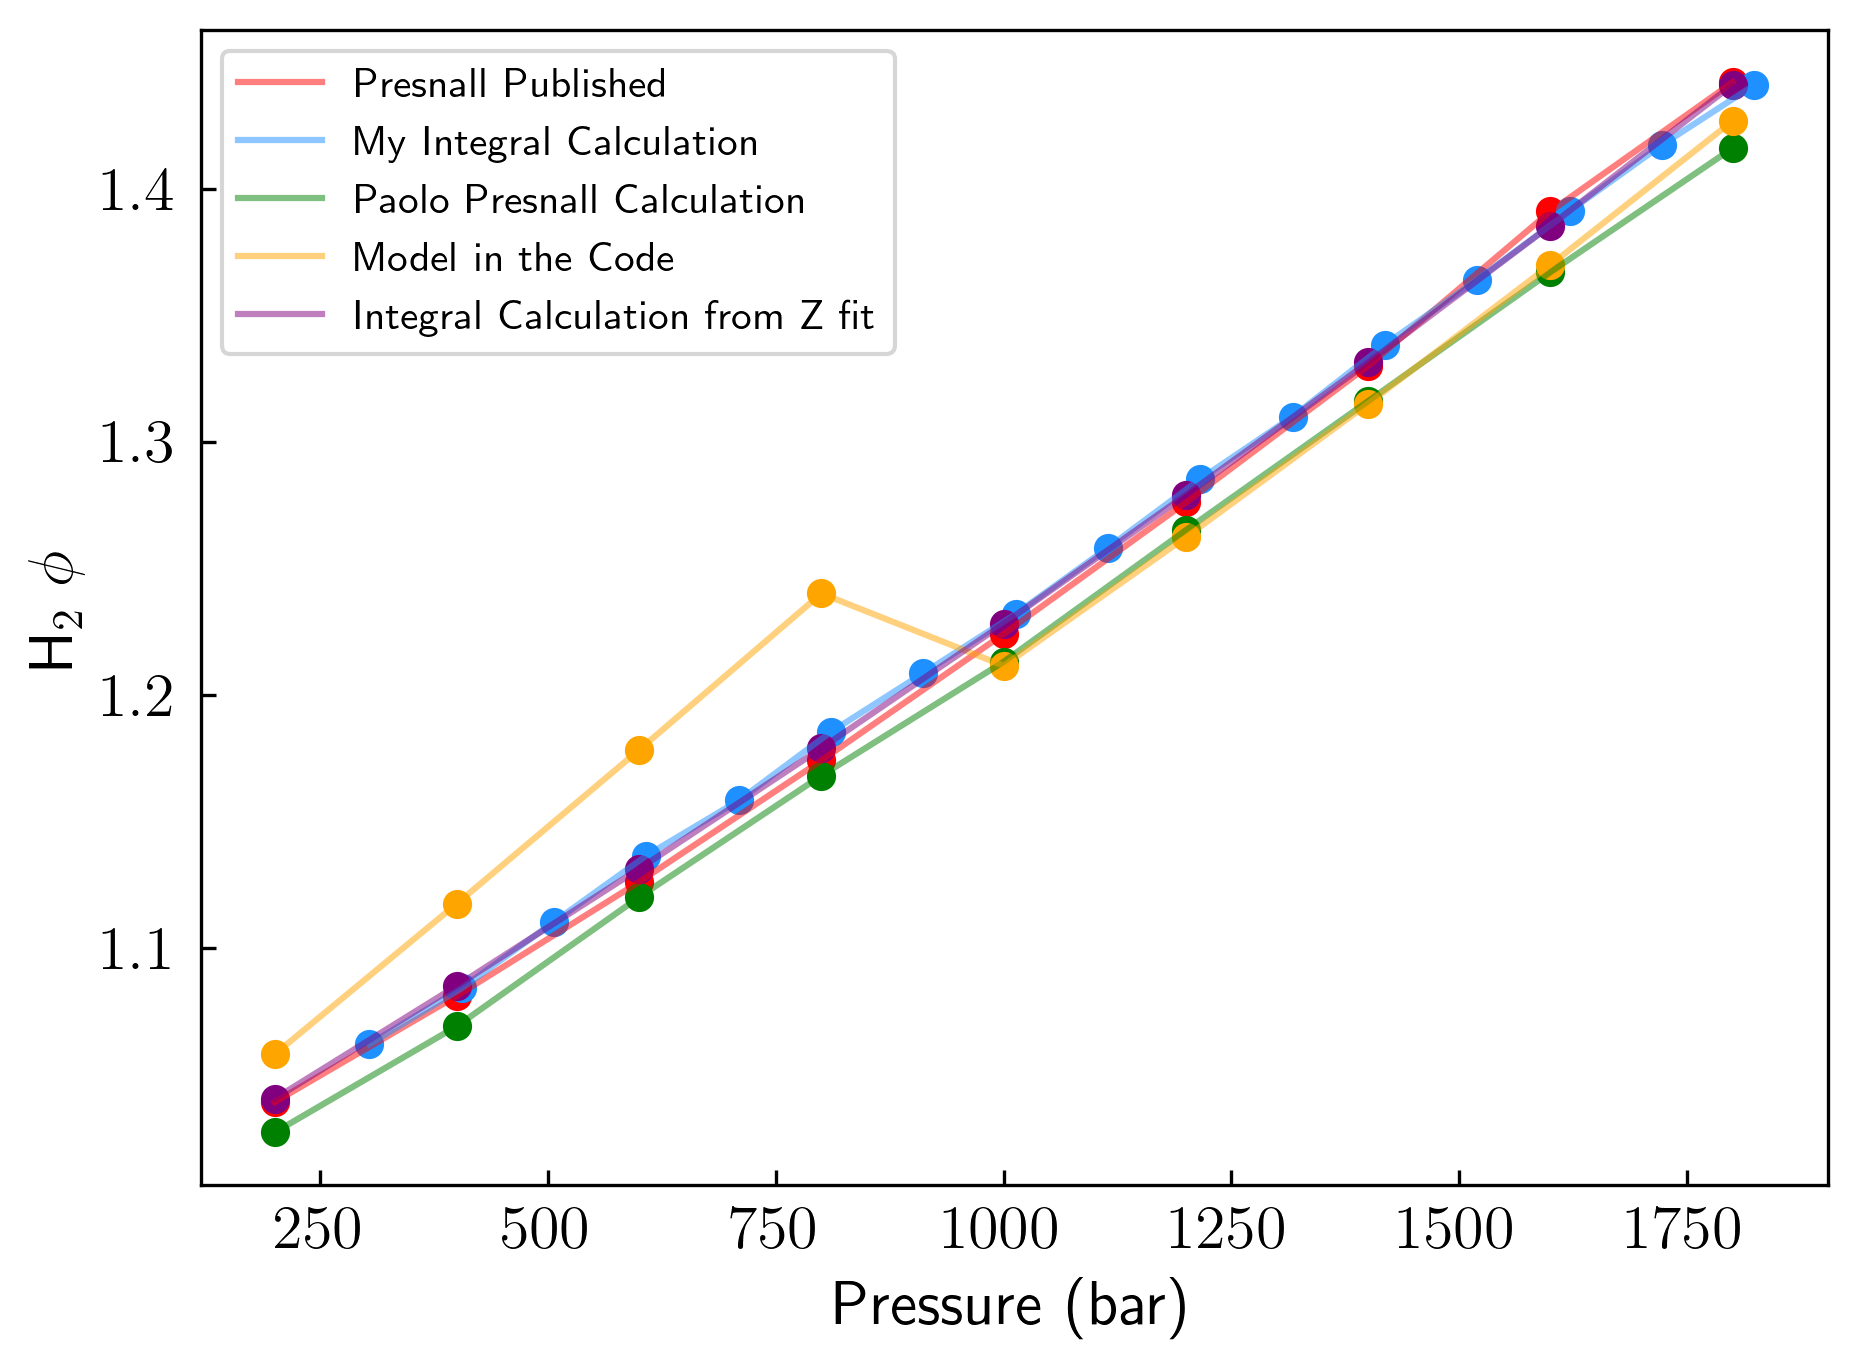

In [44]:
#Plotting H2 Phi for Presnall Data and Models:

fig, ax = plt.subplots()
plt.plot(df_H2_PS_Presnall.P_bar, df_H2_PS_Presnall.Phi_published, alpha=0.5, color='red', label='Presnall Published')
plt.plot(df_H2_MyIntCalc.P_bar[100:118], df_H2_MyIntCalc.Phi[100:118], alpha=0.5, color='dodgerblue', label='My Integral Calculation')
plt.plot(df_H2_PS_Presnall.P_bar, df_H2_PS_Presnall.Phi_calc, alpha=0.5, color = 'green', label='Paolo Presnall Calculation')
plt.plot(P_arr_Presnall, SS_model_Presnall, alpha=0.5, color='orange', label='Model in the Code')
plt.plot(P_arr_Presnall, phi_calc_allinone_arr_P, alpha=0.5, color='purple', label='Integral Calculation from Z fit')

plt.scatter(df_H2_PS_Presnall.P_bar, df_H2_PS_Presnall.Phi_published, color='red')
plt.scatter(df_H2_MyIntCalc.P_bar[100:118], df_H2_MyIntCalc.Phi[100:118], color='dodgerblue')
plt.scatter(df_H2_PS_Presnall.P_bar, df_H2_PS_Presnall.Phi_calc,  color = 'green')
plt.scatter(P_arr_Presnall, SS_model_Presnall, color='orange')
plt.scatter(P_arr_Presnall, phi_calc_allinone_arr_P, color='purple')

plt.legend(fontsize=10)
plt.xlabel('Pressure (bar)')
plt.ylabel(r'H$_2$ $\phi$')
#plt.savefig('data/Plots/PresnallComparison.jpg', dpi=1000)
plt.show()


In [68]:
print(df_H2_MyIntCalc.Phi[0:8])

0      1.000000
1    167.509628
2    110.652803
3     61.776721
4     33.464275
5     19.967928
6     13.131295
7     12.500225
Name: Phi, dtype: float64


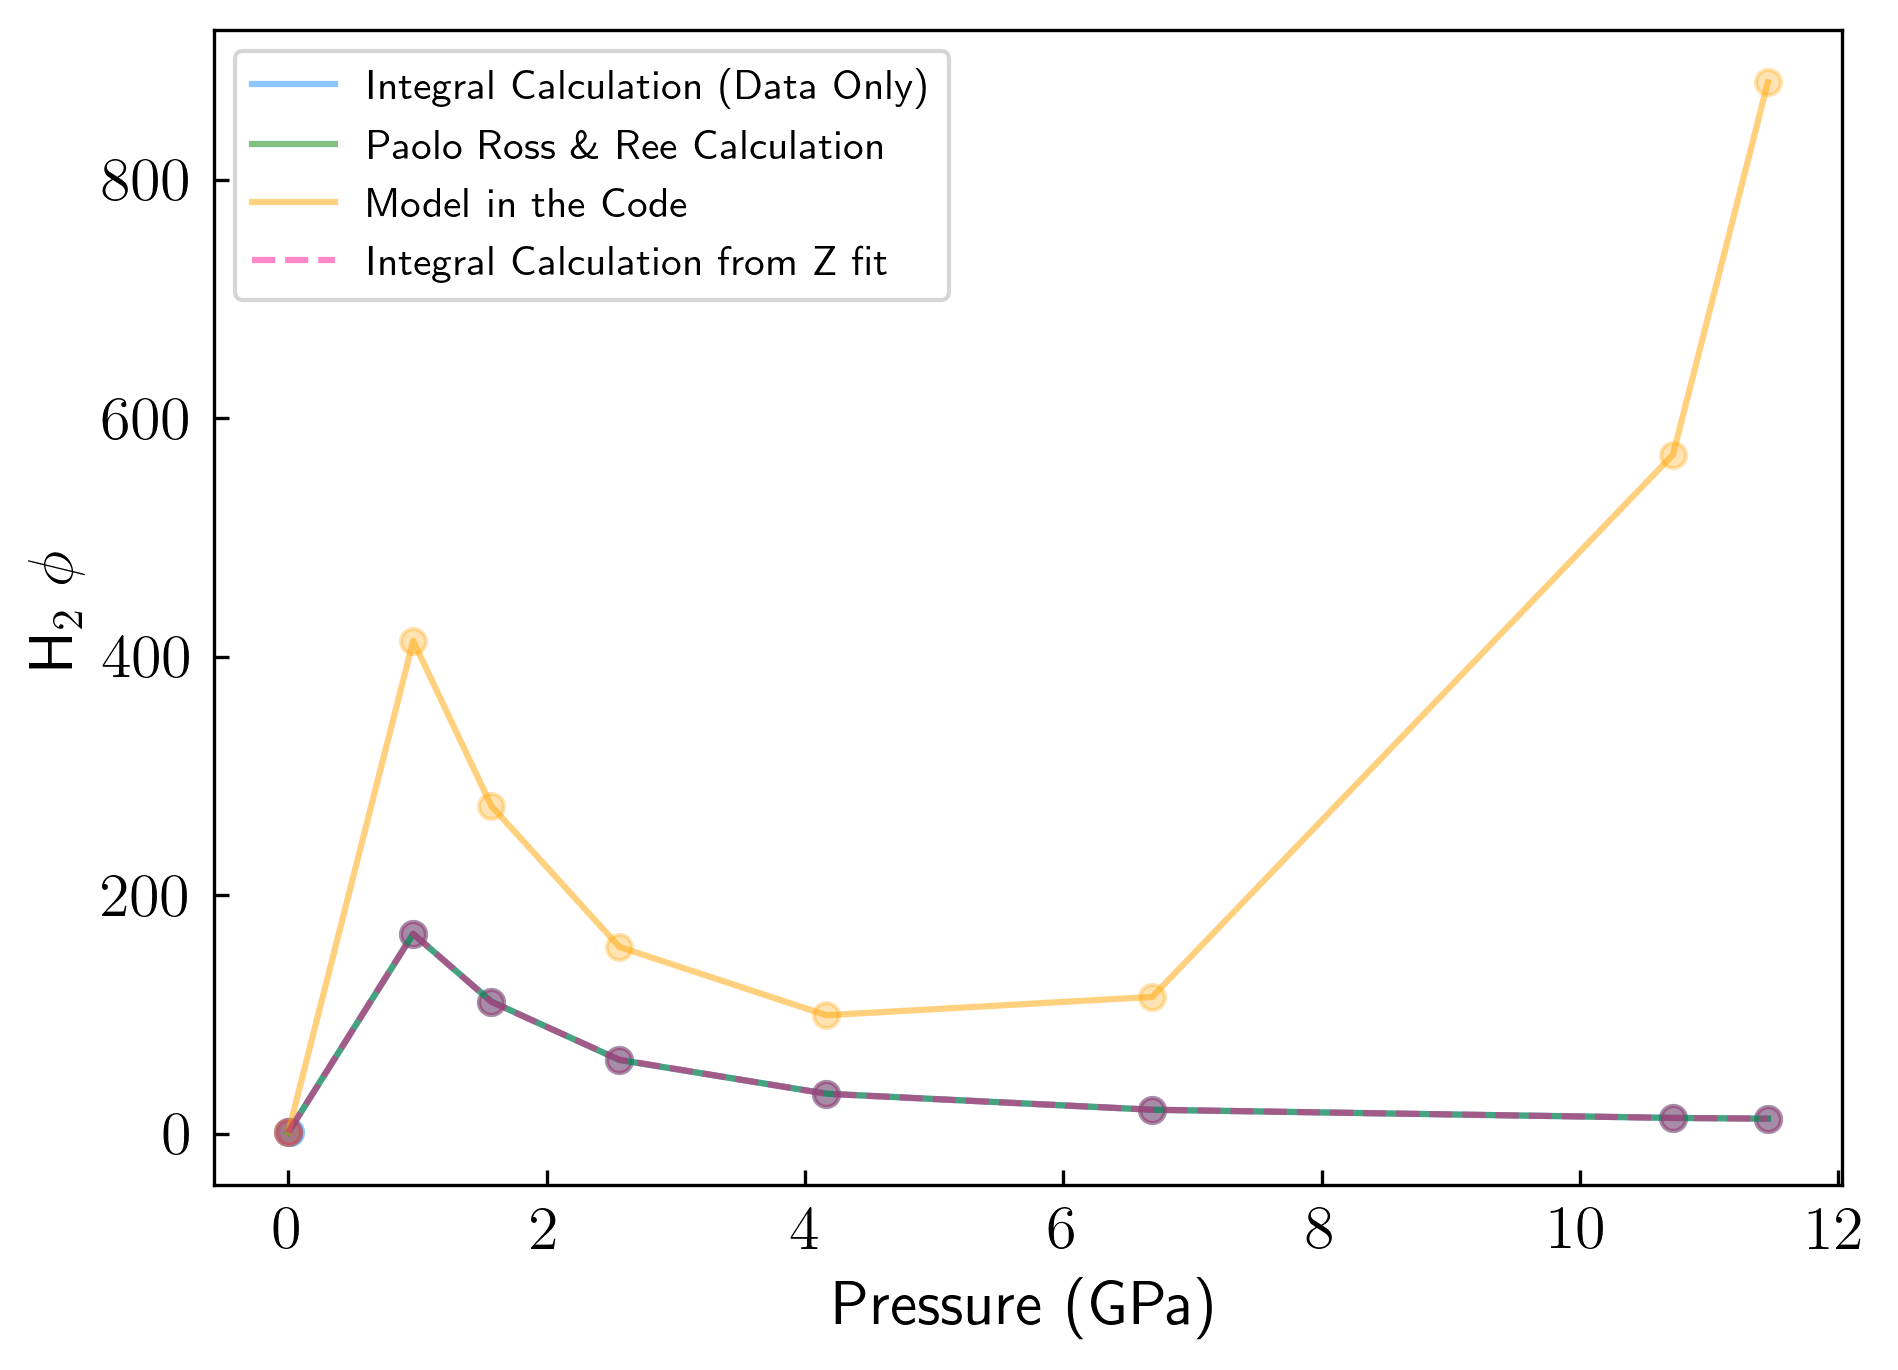

In [45]:
#Plotting Ross and Ree Comparison between Data and various Models:

fig, ax = plt.subplots()
plt.plot(df_H2_MyIntCalc.P_bar[0:8]/1e4, df_H2_MyIntCalc.Phi[0:8], alpha=0.5, color='dodgerblue', label='Integral Calculation (Data Only)')
plt.plot(df_H2_PS_RR.P_bar/1e4, df_H2_PS_RR.Phi, alpha=0.5, color = 'green', label=r'Paolo Ross \& Ree Calculation')
plt.plot(np.array(P_arr_RR)/1e4, SS_model_RR, alpha=0.5, color='orange', label='Model in the Code')
#plt.plot(np.array(P_arr_RR)/1e4, SS_calc_RR, alpha=0.5, color='purple', label='My Model Calculation')
plt.plot(np.array(P_arr_RR)/1e4, phi_calc_allinone_arr_RR, alpha=0.5, color='deeppink', linestyle='--', label='Integral Calculation from Z fit')

plt.scatter(df_H2_MyIntCalc.P_bar[0:10]/1e4, df_H2_MyIntCalc.Phi[0:10], alpha=0.3, color='dodgerblue')
plt.scatter(df_H2_PS_RR.P_bar/1e4, df_H2_PS_RR.Phi, alpha=0.3, color = 'green')
plt.scatter(np.array(P_arr_RR)/1e4, SS_model_RR, alpha=0.3, color='orange')
#plt.scatter(np.array(P_arr_RR)/1e4, SS_calc_RR, alpha=0.3, color='purple')
plt.scatter(np.array(P_arr_RR)/1e4, phi_calc_allinone_arr_RR, alpha=0.3, color='deeppink')

plt.legend(fontsize=10)
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'H$_2$ $\phi$')
#plt.savefig('data/Plots/RossReeComparison_OnlyGoodOnes.jpg', dpi=1000)
plt.show()

In [95]:
SS_model_RossRee = volume_func_2(SS_model_H2, df_H2Data['T_K'][0:8], df_H2Data['P_GPa'][0:8]*1e4)
print(np.array(SS_model_RossRee)/10)
#SS_model_RR_Z = ((SS_model_RossRee/10) *(df_H2Data['P_GPa'][0:8]*1e4))/(df_H2Data['T_K'][0:8]*R)

[155.97846172   1.40013507   1.2994349    1.20099171   1.09905114
   1.00053134   0.8995392    0.88630753]


In [96]:
print(df_H2Data['P_GPa'][0:8])
print(df_H2Data['V_cm3mol'][0:8])

0     0.0001
1     0.9670
2     1.5730
3     2.5630
4     4.1660
5     6.6880
6    10.7200
7    11.4540
Name: P_GPa, dtype: float64
0    28.40
1    14.00
2    13.00
3    12.00
4    11.00
5    10.00
6     9.00
7     8.86
Name: V_cm3mol, dtype: float64


In [ ]:
#Plotting Presnall Comparison between Data and various Models:

fig, ax = plt.subplots()
plt.plot(df_H2_PS_Presnall.P_bar, df_H2_PS_Presnall.Phi_published, alpha=0.5, color='red', label='Presnall Published')
plt.plot(df_H2_MyIntCalc.P_bar[100:118], df_H2_MyIntCalc.Phi[100:118], alpha=0.5, color='dodgerblue', label='My Integral Calculation')
plt.plot(df_H2_PS_Presnall.P_bar, df_H2_PS_Presnall.Phi_calc, alpha=0.5, color = 'green', label='Paolo Presnall Calculation')

plt.plot(np.array(P_arr_Presnall), phi_calc_allinone_arr_P, alpha=0.5, color='deeppink', linestyle='--', label='Integral Calculation from Z fit')

plt.scatter(df_H2_PS_Presnall.P_bar, df_H2_PS_Presnall.Phi_published, alpha=0.3, color='red')
plt.scatter(df_H2_MyIntCalc.P_bar[100:118], df_H2_MyIntCalc.Phi[100:118], alpha=0.3, color = 'dodgerblue')

plt.scatter(np.array(P_arr_Presnall), phi_calc_allinone_arr_P, alpha=0.3, color='deeppink')

plt.legend(fontsize=10)
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Pressure')
plt.ylabel(r'H$_2$ $\phi$')
#plt.savefig('data/Plots/RossReeComparison_OnlyGoodOnes.jpg', dpi=1000)
plt.show()

In [35]:
SS_1673 = fugacitycoeff_func(SS_model_H2, 1673, pressure_arr)
SS_2000 = fugacitycoeff_func(SS_model_H2, 2000, pressure_arr)
SS_2500 = fugacitycoeff_func(SS_model_H2, 2500, pressure_arr)
SS_6000 = fugacitycoeff_func(SS_model_H2, 6000, pressure_arr)

SS_2000_CO = fugacitycoeff_func(SS_model_CO, 2000, pressure_arr)
SS_1673_CO = fugacitycoeff_func(SS_model_CO, 1673, pressure_arr)


SS_2000_CH4 = fugacitycoeff_func(SS_model_CH4, 2000, pressure_arr)
SS_2000_CO2 = fugacitycoeff_func(SS_model_CO2, 2000, pressure_arr)
SS_2000_H2S = fugacitycoeff_func(SS_model_H2S, 2000, pressure_arr)

In [97]:
SS_model_5bar = volume_func(SS_model_lo, temp_arr_SF, 5)
SS_model_10bar = volume_func(SS_model_lo, temp_arr_SF, 10)
SS_model_25bar = volume_func(SS_model_lo, temp_arr_SF, 25)
SS_model_50bar = volume_func(SS_model_lo, temp_arr_SF, 50)
SS_model_100bar = volume_func(SS_model_lo, temp_arr_SF, 100)

SS_model_200bar = volume_func(SS_model_lo, temp_arr_SF, 200)
SS_model_300bar = volume_func(SS_model_lo, temp_arr_SF, 300)
SS_model_400bar = volume_func(SS_model_lo, temp_arr_SF, 400)
SS_model_500bar = volume_func(SS_model_lo, temp_arr_SF, 500)
SS_model_600bar = volume_func(SS_model_lo, temp_arr_SF, 600)
SS_model_700bar = volume_func(SS_model_lo, temp_arr_SF, 700)
SS_model_800bar = volume_func(SS_model_lo, temp_arr_SF, 800)
SS_model_900bar = volume_func(SS_model_lo, temp_arr_SF, 900)
SS_model_1000bar = volume_func(SS_model_lo, temp_arr_SF, 1000)

SS_model_1000bar_hi = volume_func(SS_model_hi, temp_arr_SF_hi, 1000)
SS_model_2000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 2000)
SS_model_3000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 3000)
SS_model_4000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 4000)
SS_model_5000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 5000)
SS_model_6000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 6000)
SS_model_8000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 8000)
SS_model_10000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 10000)


SS_model_1000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 1000)
SS_model_2000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 2000)
SS_model_3000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 3000)
SS_model_4000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 4000)
SS_model_5000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 5000)
SS_model_6000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 6000)
SS_model_8000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 8000)
SS_model_10000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 10000)

print(len(SS_model_5bar))

37


In [98]:
SF_model_1000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 1000)
SF_model_2000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 2000)
SF_model_3000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 3000)
SF_model_4000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 4000)
SF_model_5000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 5000)
SF_model_6000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 6000)
SF_model_8000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 8000)
SF_model_10000bar = volume_func(SF_model_hi_refit, temp_arr_SF_hi, 10000)

print(SF_model_1000bar)
print(SF_model_10000bar)

[39.033793382237874, 43.09122820557802, 47.15698579462445, 51.222867722508525, 55.284736709651874, 59.34045401381924, 63.38893049094314, 67.42965418150423, 71.46244047498969, 75.48729362694237, 79.50432713441805, 83.51371664630003, 87.51567153062255, 91.51041746932619, 95.49818573473102, 99.47920659674735, 103.4537053243723, 107.4218998355465, 111.38399940206462, 115.3402040315448, 119.2907042825274, 123.2356813536923, 127.17530734277355, 131.10974560629808, 135.03915117467682, 138.96367119271787, 142.88344536602838, 146.79860640076242, 150.70928042888406, 154.61558741429326, 158.51764153730042, 162.41555155636323, 166.3094211469415, 170.1993492179358, 174.08543020655745, 177.96775435269888, 181.84640795399656, 185.72147360282233, 189.59303040643746, 193.46115419151656, 197.3259176941916, 201.18739073670935, 205.0456403917248, 208.9007311351844, 212.75272498868415, 216.60168165211954, 220.44765862738078, 224.29071133378713, 228.13089321589655, 231.96825584427503, 235.80284900976363, 23

In [99]:
SS_2000_intcalc = fug_coeff_fromV_Zfit_arr(SS92_Coeffs_select, temp_arr_2000, pressure_arr, 1)

print(SS_2000_intcalc)


[1.5356806933621454, 1.0019108812931632, 1.0082095256469812, 1.014590017400139, 1.0210421969955734, 1.0275645393628194, 1.0341569642087884, 1.0408198088906857, 1.0475535716647335, 1.0543588261349444, 1.0612361870630374, 1.068186294855531, 1.0752098078332137, 1.0823073980926357, 1.089479749163743, 1.096727554625575, 1.1040515172609608, 1.1114523485283732, 1.1189307682276834, 1.1264875042884506, 1.1341232926379345, 1.1418388771223067, 1.1496350094642058, 1.1575124492456177, 1.1654719639087376, 1.1735143287698335, 1.1816403270426377, 1.1898507498688329, 1.1981463963538934, 1.2065280736070132, 1.2149965967841858, 1.2235527891337532, 1.2321974820438955, 1.2409315150916616, 1.2497557360932425, 1.2586710011552367, 1.2676781747267336, 1.2767781296520455, 1.2859717472239927, 1.295259917237618, 1.304643538044266, 1.3141235166059517, 1.3237007685499647, 1.333376218223661, 1.3431507987493962, 1.3530254520795566, 1.3630011290516797, 1.3730787894436, 1.3832594020286189, 1.3935439446306603, 1.4039334

In [101]:
SS_SO2_5bars = volume_func(SS_model_SO2, temp_arr_SF, 5)
SS_SO2_10bars = volume_func(SS_model_SO2, temp_arr_SF, 10)
SS_SO2_50bars = volume_func(SS_model_SO2, temp_arr_SF, 50)

SS_SO2_200bars = volume_func(SS_model_SO2, temp_arr_SF, 200)
SS_SO2_600bars = volume_func(SS_model_SO2, temp_arr_SF, 600)
SS_SO2_1000bars = volume_func(SS_model_SO2, temp_arr_SF, 1000)

SS_SO2_2000bars = volume_func(SS_model_SO2, temp_arr_SF, 2000)
SS_SO2_6000bars = volume_func(SS_model_SO2, temp_arr_SF, 6000)
SS_SO2_10000bars = volume_func(SS_model_SO2, temp_arr_SF, 10000)


In [102]:
SS_H2S_100bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 100)
SS_H2S_150bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 150)
SS_H2S_225bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 225)
SS_H2S_300bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 300)
SS_H2S_500bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 500)

SS_H2S_600bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 600)
SS_H2S_800bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 800)
SS_H2S_1000bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 1000)
SS_H2S_2000bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 2000)
SS_H2S_6000bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 6000)
SS_H2S_10000bars = volume_func(SS_model_H2S, temp_arr_SF_hi, 10000)

### Comparing H2 Fugacity Coefficient Shi & Saxena, Holland & Powell, Kite 

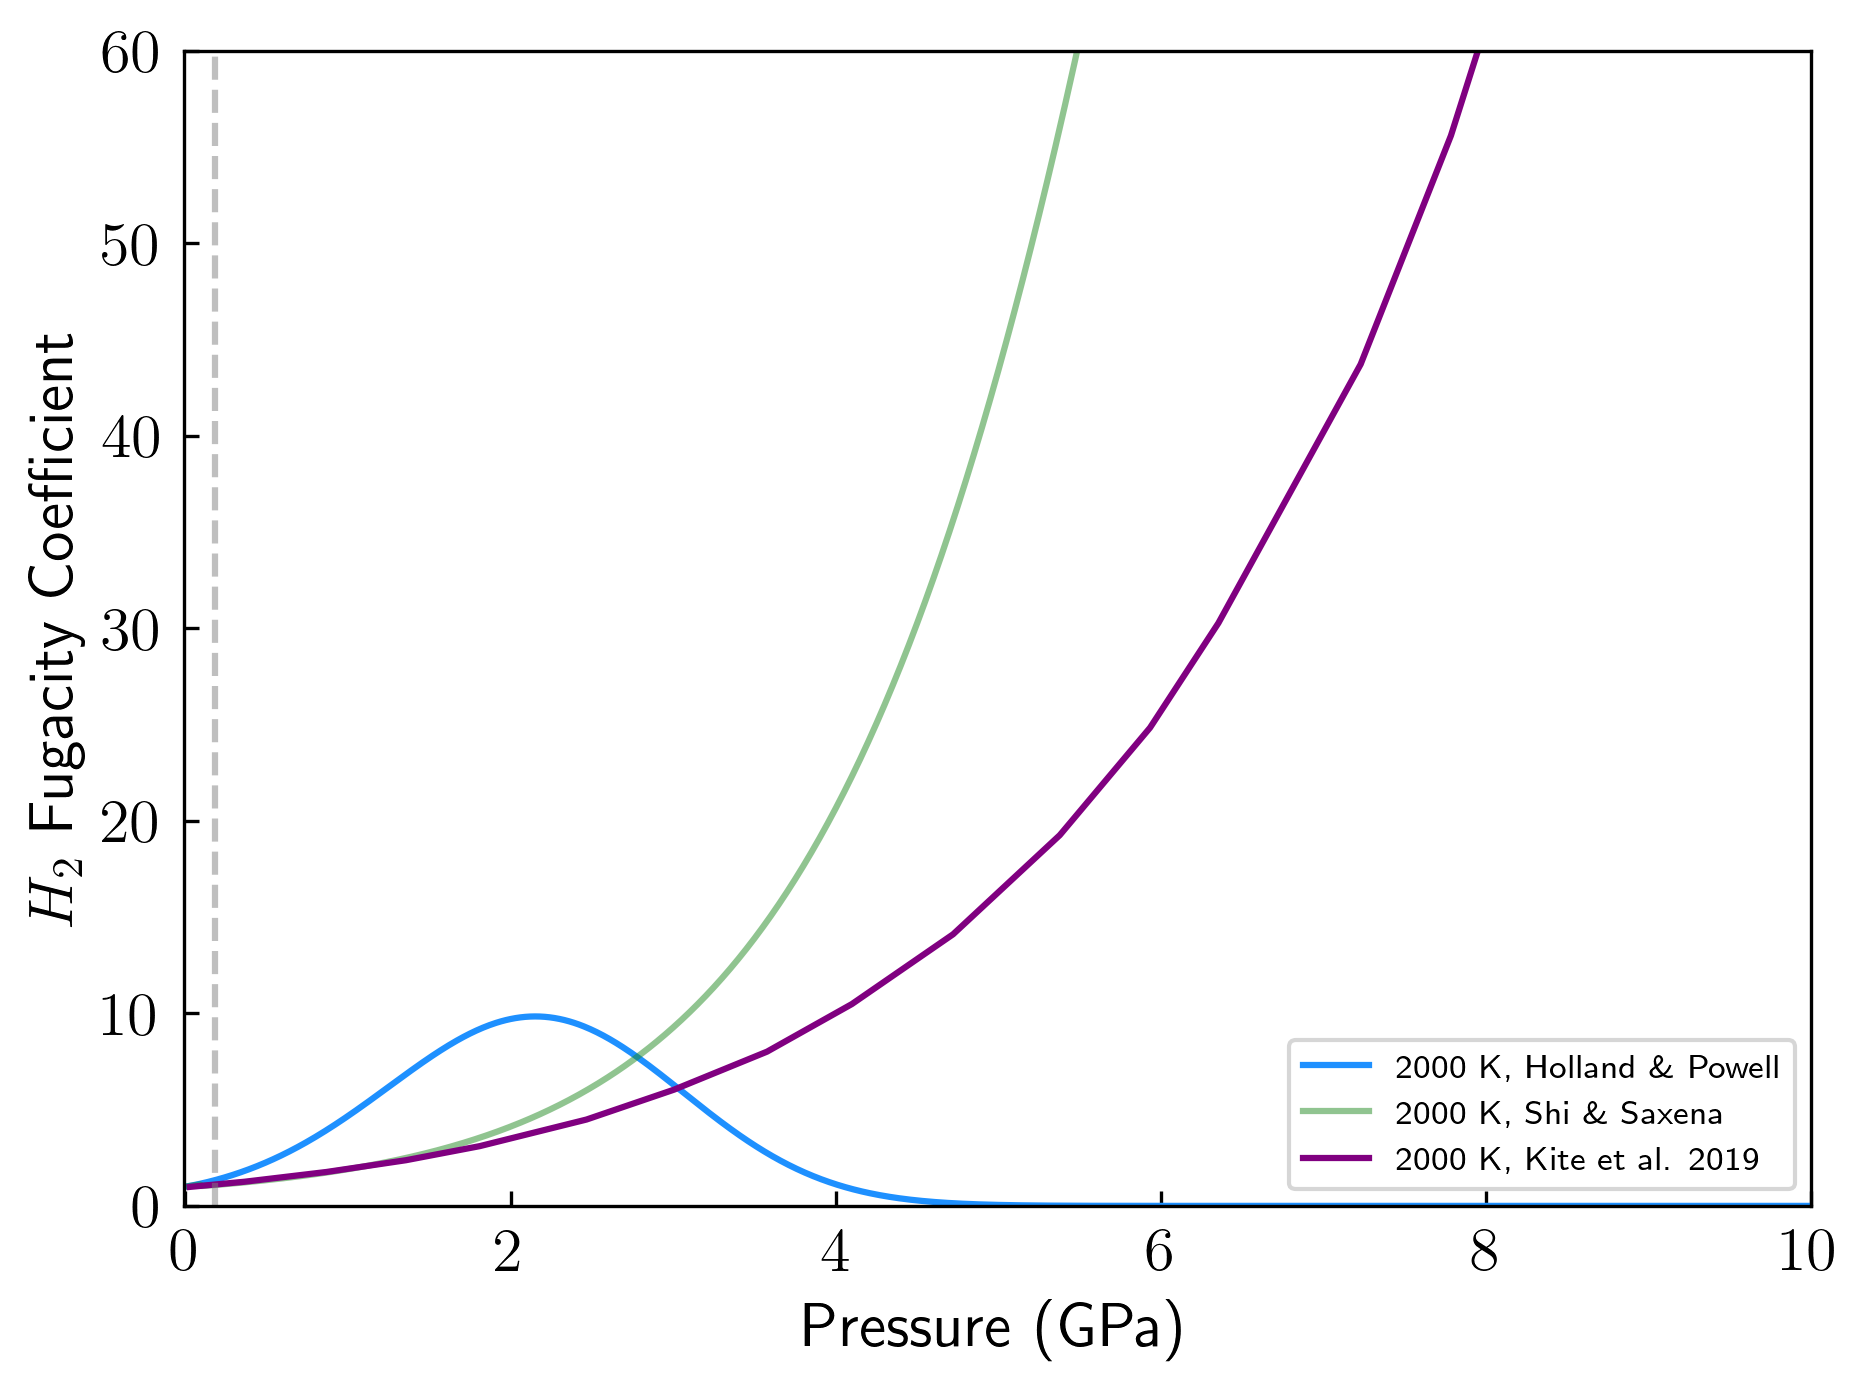

In [36]:
fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue',  label=r'2000 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, SS_2000, color='forestgreen', alpha=0.5,  label=r'2000 K, Shi \& Saxena')
#plt.plot(pressure_arr/1e4, SS_2000_intcalc, color='deeppink', alpha=0.5, label=r'2000 K, Shi \& Saxena Integral Calc')

plt.plot(K19_2000_df['P_GPa'], K19_2000_df['H2_fc'], color='purple', label=r'2000 K, Kite et al. 2019')
plt.axvline(x=0.18, color='gray', alpha=0.5, linestyle='--')
plt.legend(fontsize=8)
plt.ylim(0, 60)
plt.xlim(-0.01, 10)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
#plt.savefig('data/Plots/H2_FugacityCoefficients_SSvsHPvsKite.jpg', dpi=1000)
plt.show()



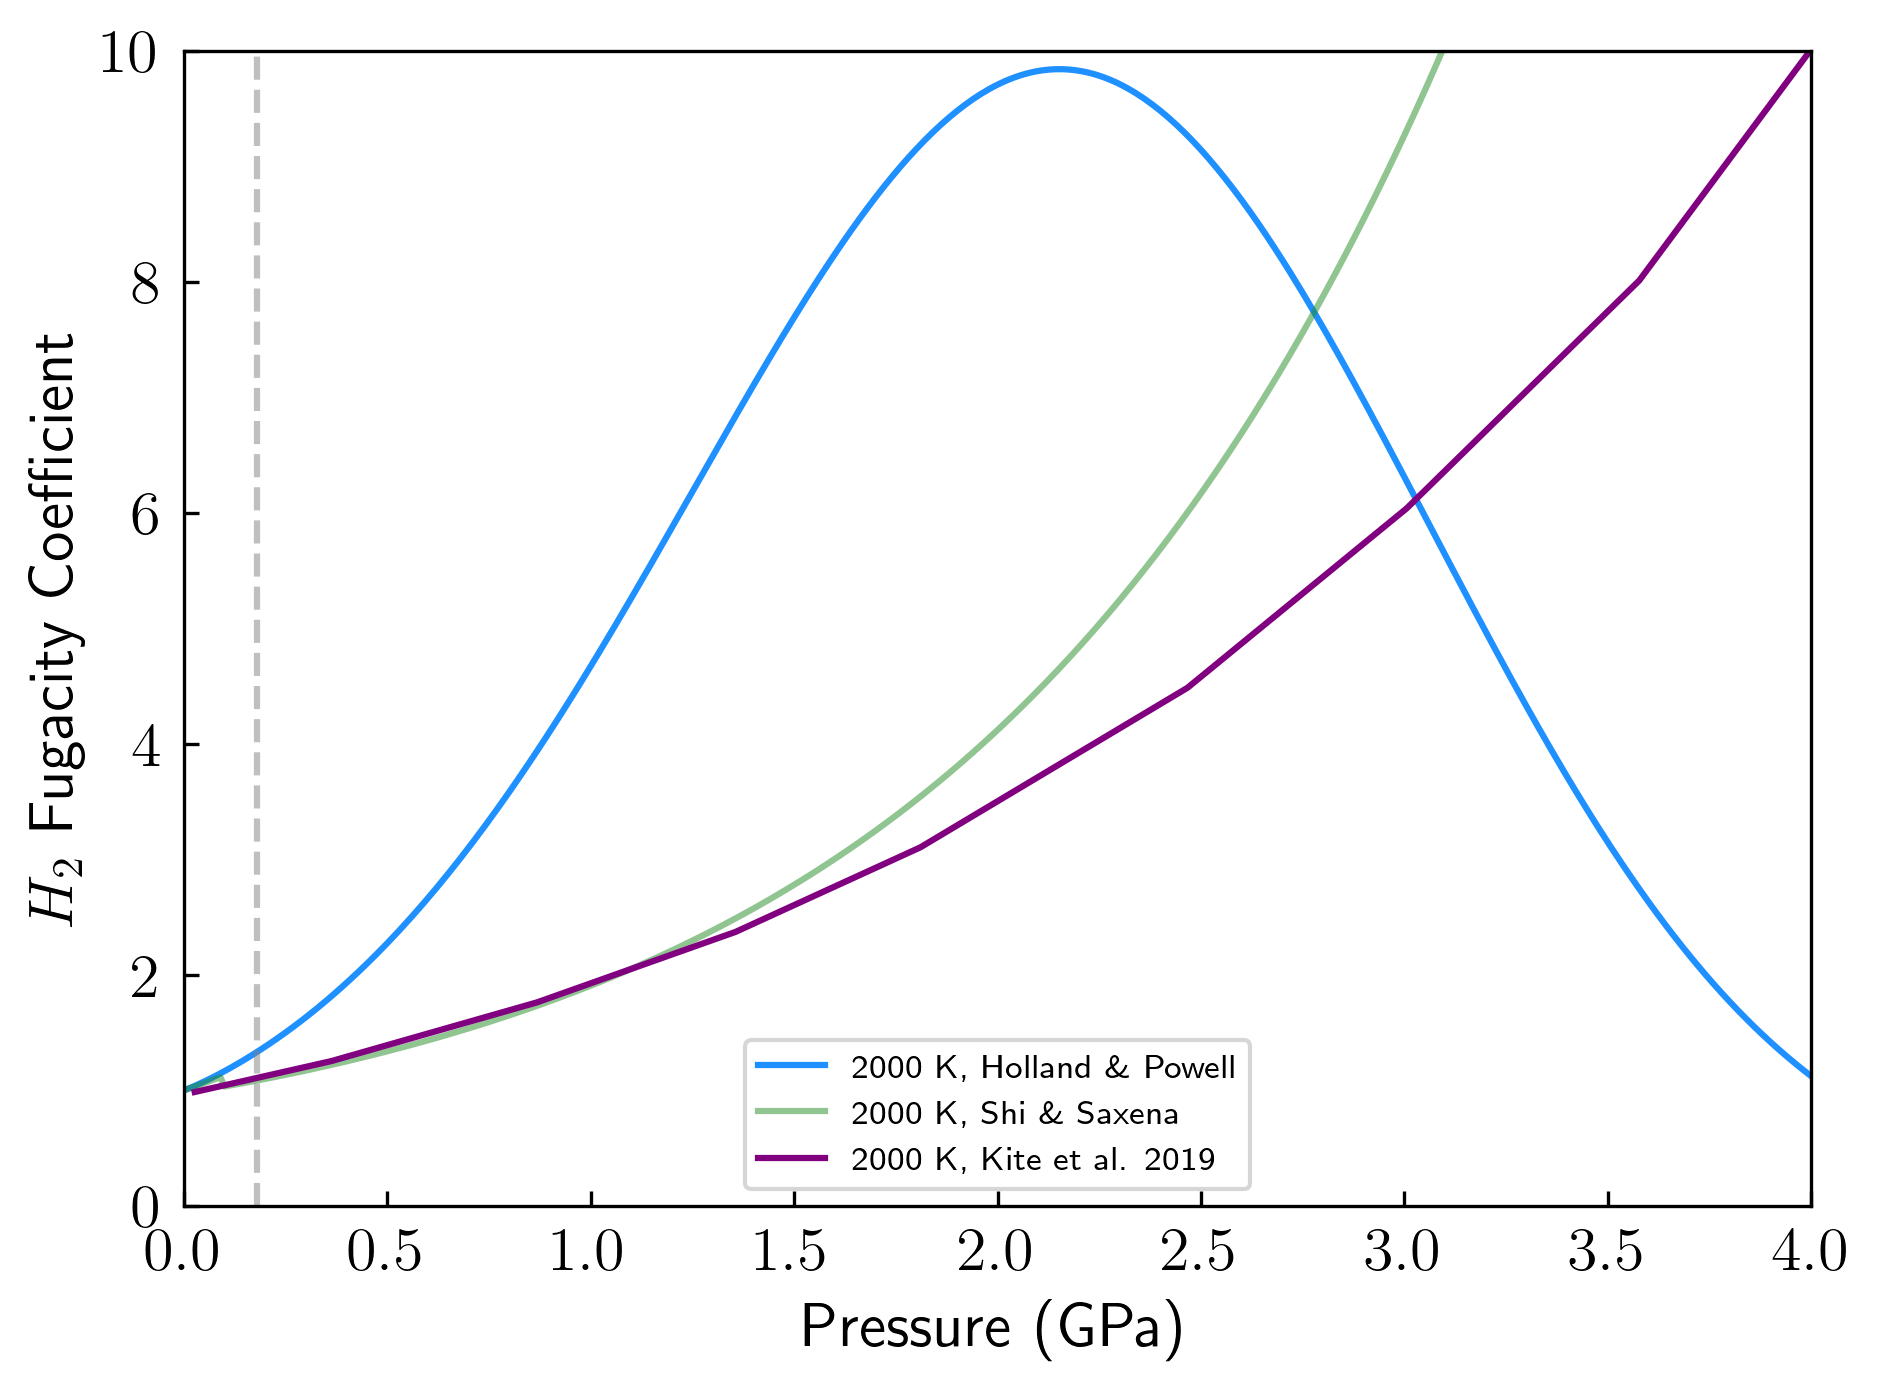

In [46]:
fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue',  label=r'2000 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, SS_2000, color='forestgreen', alpha=0.5,  label=r'2000 K, Shi \& Saxena')
#plt.plot(pressure_arr/1e4, SS_2000_intcalc, color='deeppink', alpha=0.5, label=r'2000 K, Shi \& Saxena Integral Calc')

plt.plot(K19_2000_df['P_GPa'], K19_2000_df['H2_fc'], color='purple', label=r'2000 K, Kite et al. 2019')
plt.axvline(x=0.18, color='gray', alpha=0.5, linestyle='--')
plt.legend(fontsize=8)
plt.ylim(0, 10)
#plt.yscale('log')
plt.xlim(0, 4)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
plt.savefig('data/Plots/H2_FugacityCoefficients_SSvsHPvsKite_Zoom.jpg', dpi=1000)
plt.show()

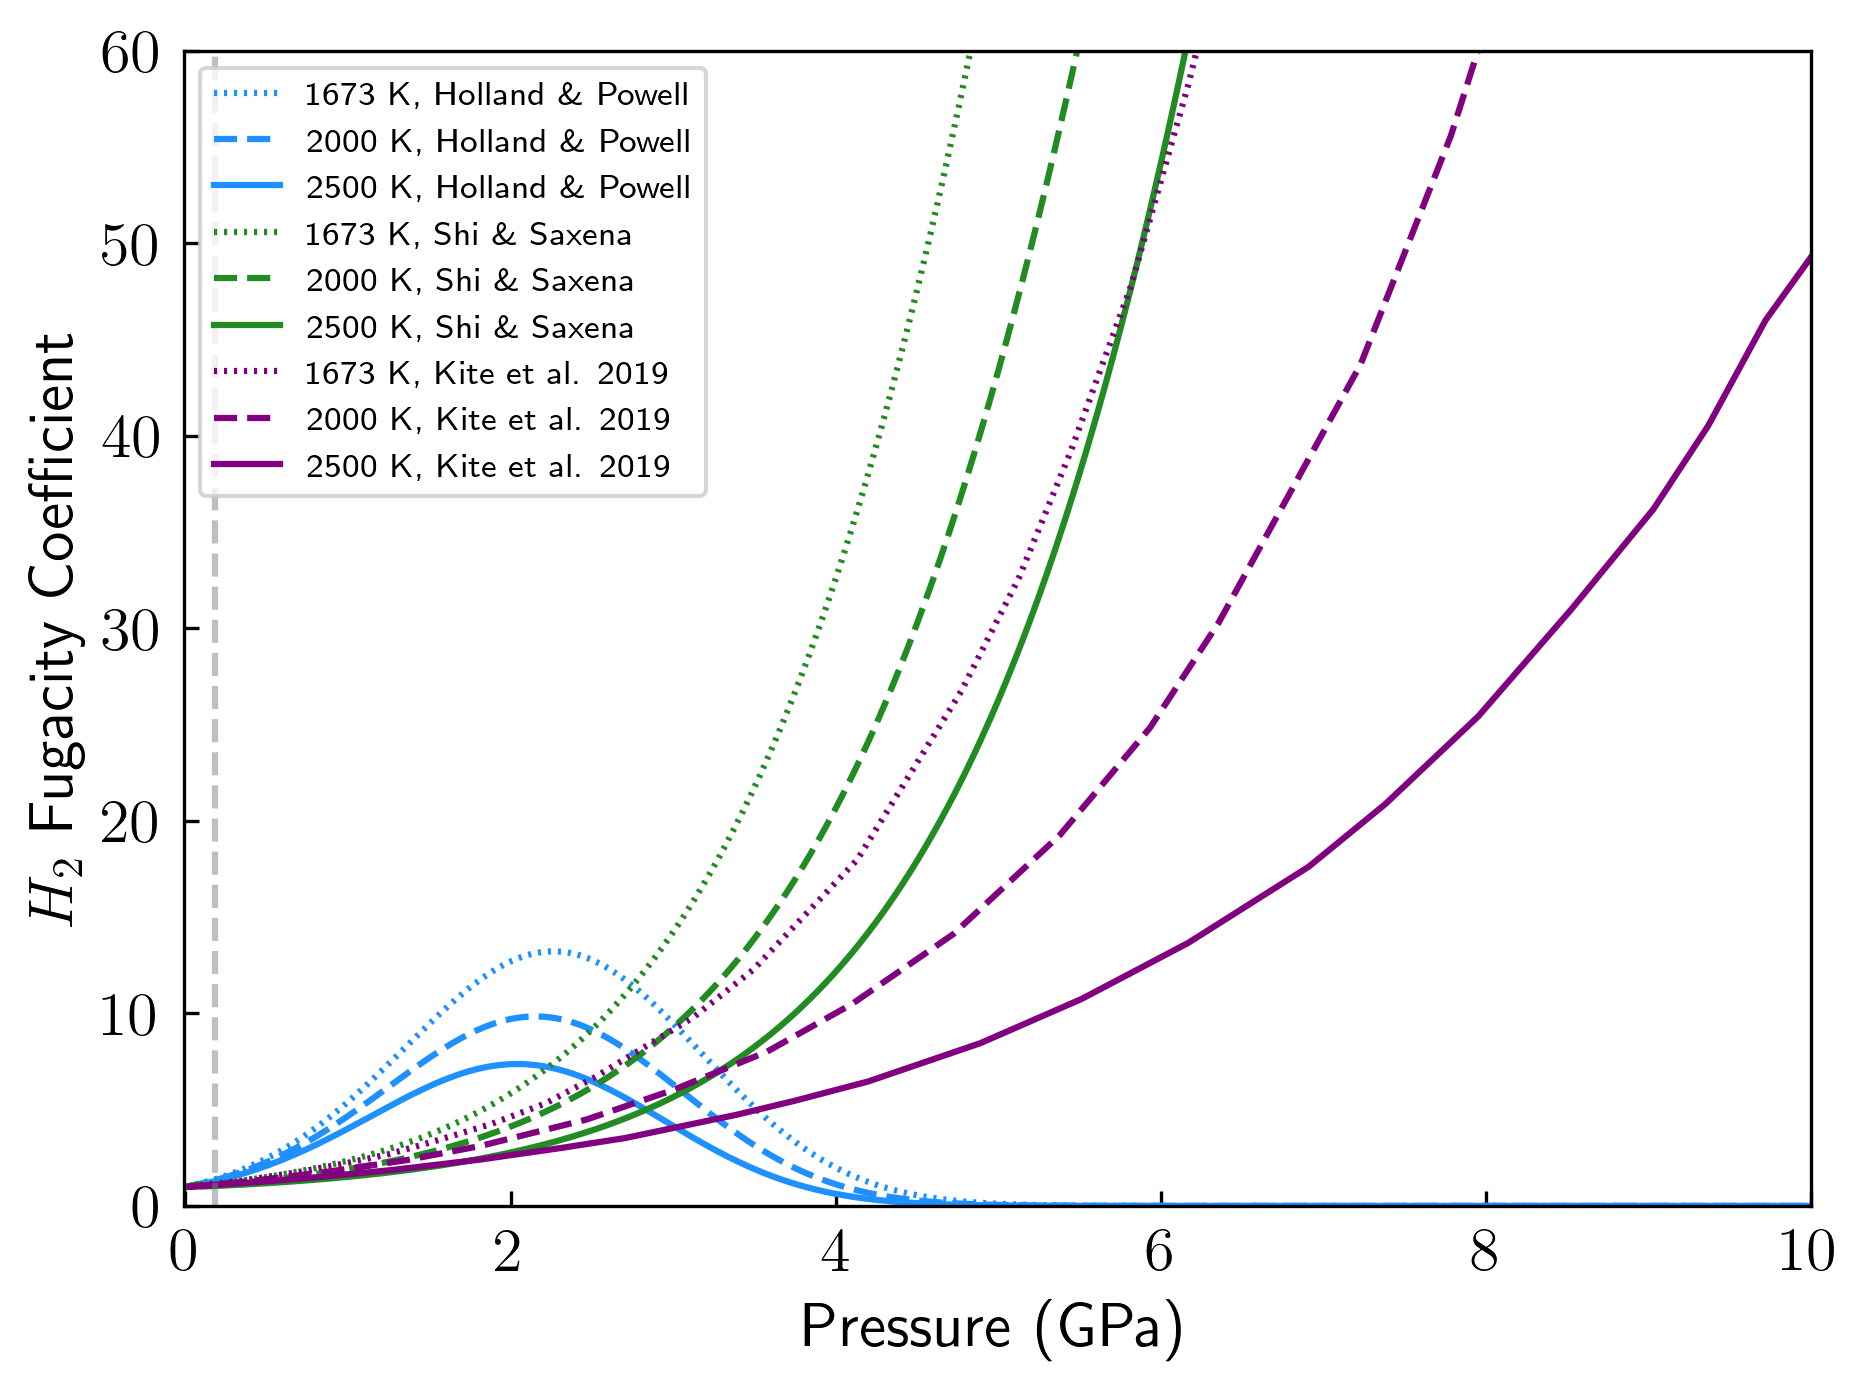

In [47]:
fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_1673, color='dodgerblue', linestyle='dotted', label=r'1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue', linestyle='--', label=r'2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2500, color='dodgerblue', label=r'2500 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, SS_1673, color='forestgreen', linestyle='dotted', label=r'1673 K, Shi \& Saxena')
plt.plot(pressure_arr/1e4, SS_2000, color='forestgreen', linestyle='--', label=r'2000 K, Shi \& Saxena')
plt.plot(pressure_arr/1e4, SS_2500, color='forestgreen', label=r'2500 K, Shi \& Saxena')
#plt.plot(pressure_arr/1e4, SS_6000, color='limegreen', label=r'6000 K, Shi \& Saxena')

plt.plot(K19_1673_df['P_GPa'], K19_1673_df['H2_fc'], color='purple', linestyle='dotted', label=r'1673 K, Kite et al. 2019')
plt.plot(K19_2000_df['P_GPa'], K19_2000_df['H2_fc'], color='purple', linestyle='--', label=r'2000 K, Kite et al. 2019')
plt.plot(K19_2500_df['P_GPa'], K19_2500_df['H2_fc'], color='purple', label=r'2500 K, Kite et al. 2019')
plt.axvline(x=0.18, color='gray', alpha=0.5, linestyle='--')
plt.legend(fontsize=8)
plt.ylim(0, 60)
plt.xlim(-0.01, 10)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
#plt.savefig('data/Plots/H2_FugacityCoefficients_KitevsShiSaxena2.jpg', dpi=1000)
plt.show()

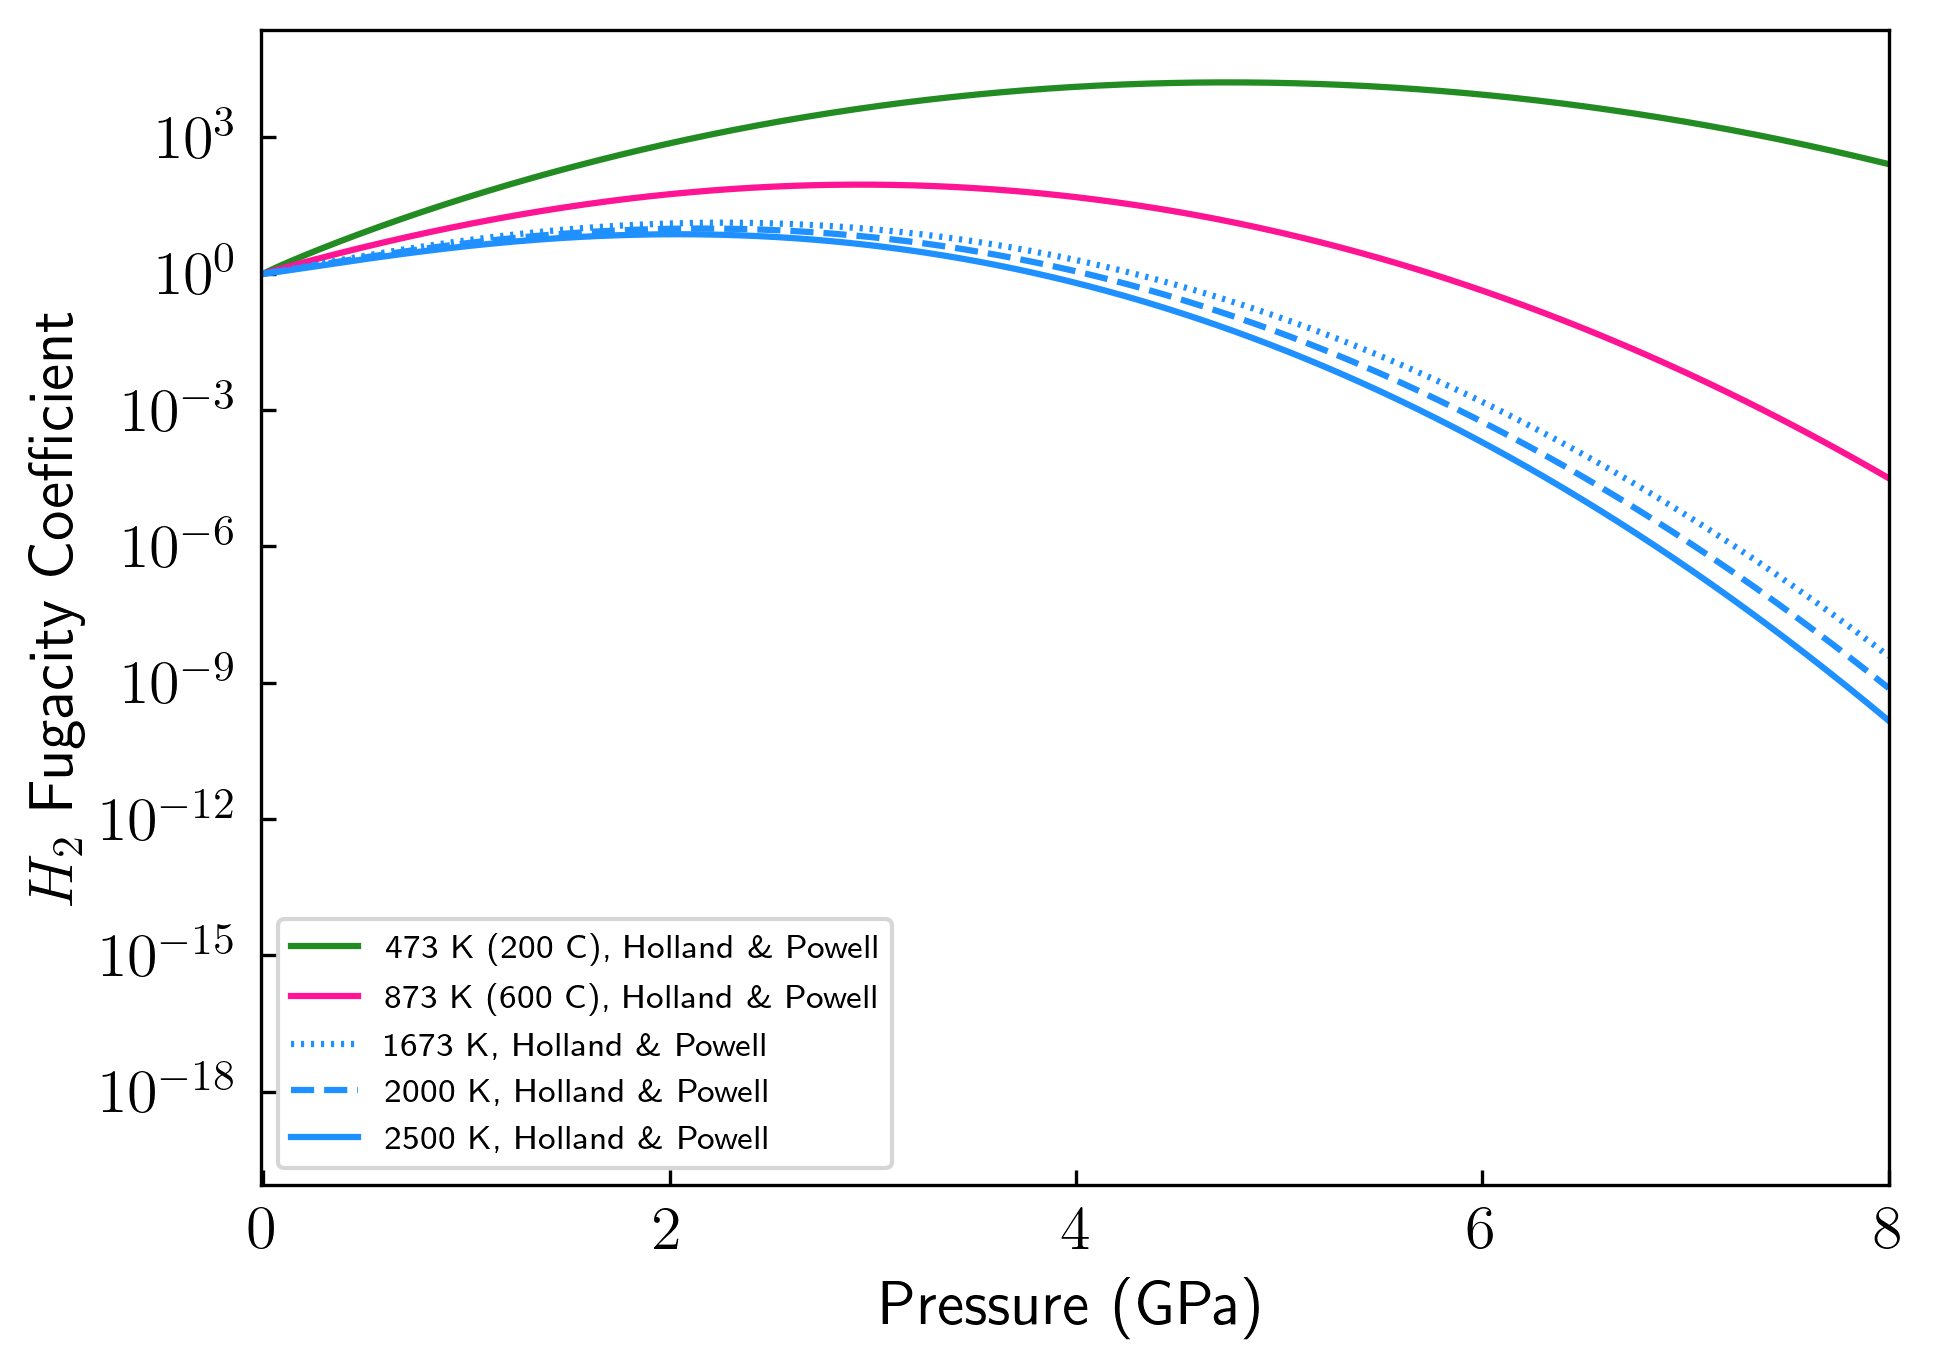

In [108]:
fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_473, color='forestgreen', label=r'473 K (200 C), Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_873, color='deeppink', label=r'873 K (600 C), Holland \& Powell')

plt.plot(pressure_arr/1e4, HP_1673, color='dodgerblue', linestyle='dotted', label=r'1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue', linestyle='--', label=r'2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2500, color='dodgerblue', label=r'2500 K, Holland \& Powell')

plt.legend(fontsize=8)
#plt.ylim(0, 20)
plt.xlim(-0.01, 8)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
#plt.savefig('H2_FugacityCoefficients_ModelComparisons.jpg', dpi=1000)
plt.show()

#### Comparison between Kite Figure 2 and Calculated Phi from Eq. 2 and Saumon Tables

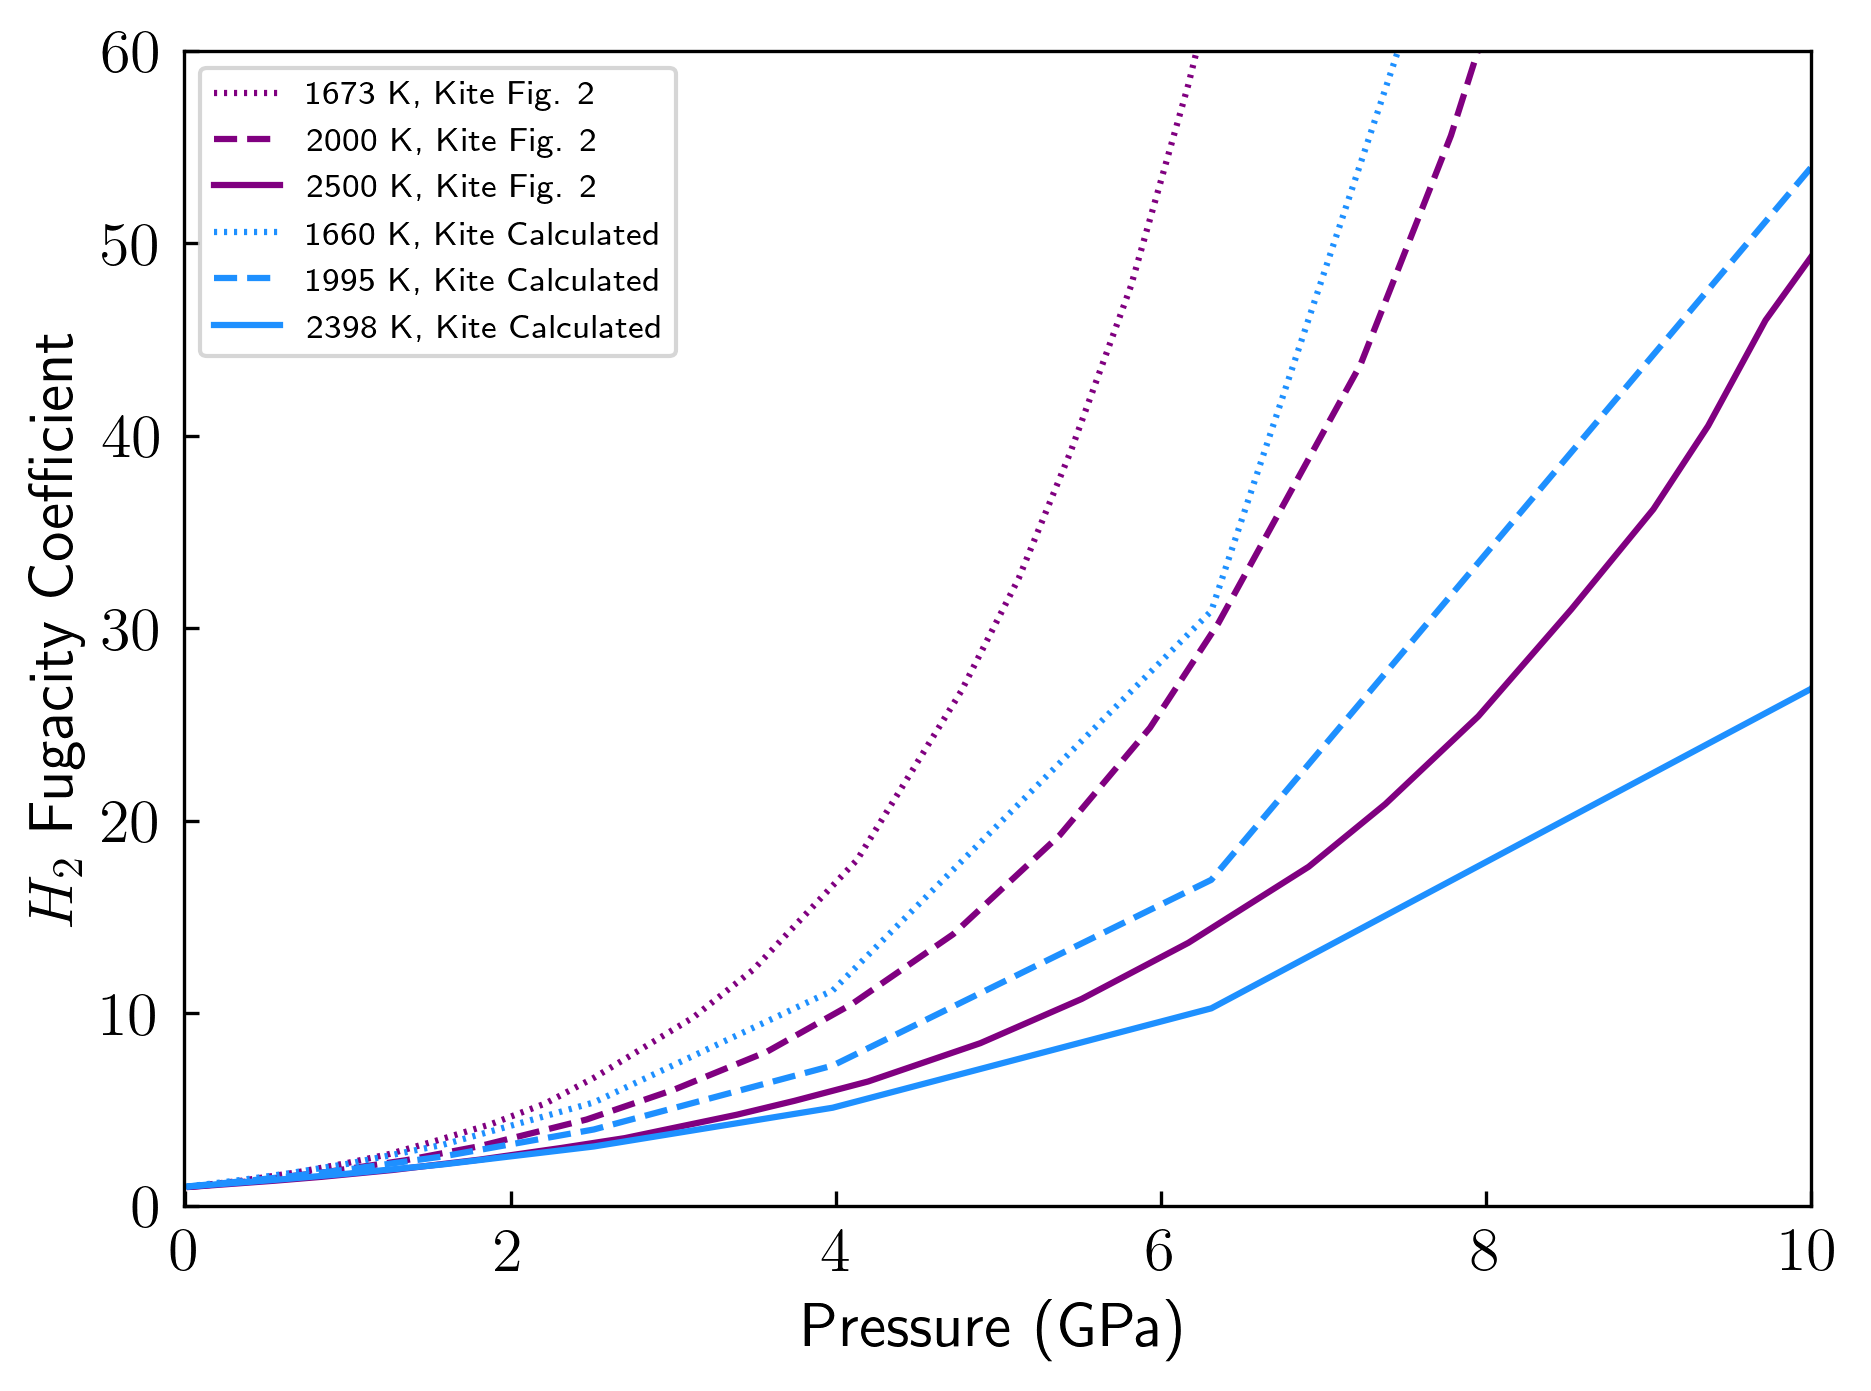

In [139]:
fig,ax = plt.subplots()
plt.plot(K19_1673_df['P_GPa'], K19_1673_df['H2_fc'], color='purple', linestyle='dotted', label=r'1673 K, Kite Fig. 2')
plt.plot(K19_2000_df['P_GPa'], K19_2000_df['H2_fc'], color='purple', linestyle='--', label=r'2000 K, Kite Fig. 2')
plt.plot(K19_2500_df['P_GPa'], K19_2500_df['H2_fc'], color='purple', label=r'2500 K, Kite Fig. 2')

plt.plot(KS_1660_df['P_GPa'], KS_1660_df['phi'], color='dodgerblue', linestyle='dotted', label=r'1660 K, Kite Calculated')
plt.plot(KS_1995_df['P_GPa'], KS_1995_df['phi'], color='dodgerblue', linestyle='--', label=r'1995 K, Kite Calculated')
plt.plot(KS_2398_df['P_GPa'], KS_2398_df['phi'], color='dodgerblue', label=r'2398 K, Kite Calculated')

#plt.axvline(x=0.18, color='gray', alpha=0.5, linestyle='--')
plt.legend(fontsize=8)
plt.ylim(0, 60)
plt.xlim(-0.01, 10)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
plt.savefig('data/Plots/H2_FugacityCoefficients_KiteFigvsCalculation.jpg', dpi=1000)
plt.show()

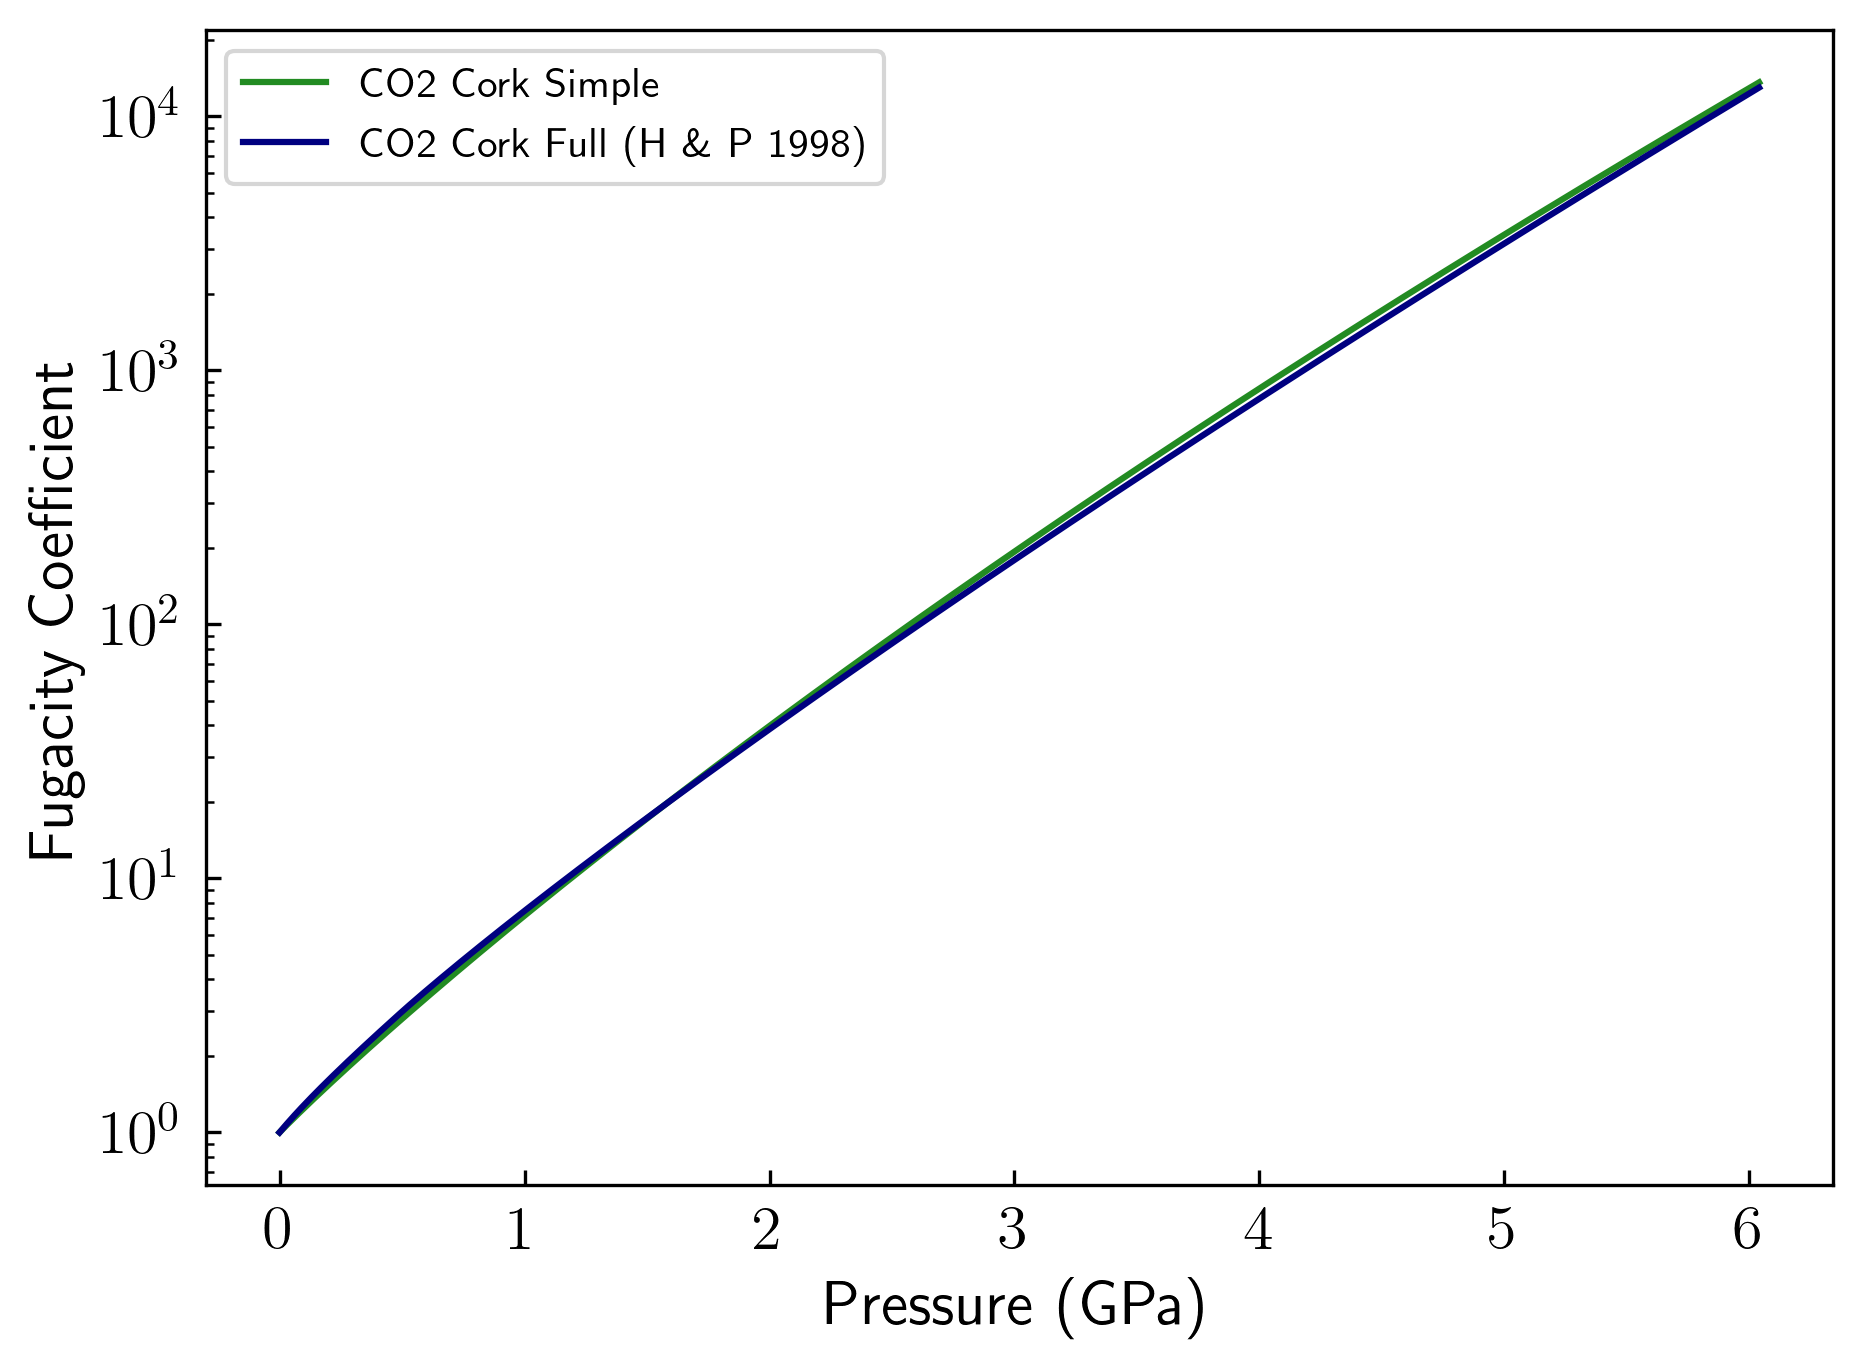

In [49]:
fig, ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_2000_CO2Simple, color='forestgreen', label='CO2 Cork Simple')
plt.plot(pressure_arr/1e4, HP_2000_CO2Full, color='navy', label=r'CO2 Cork Full (H \& P 1998)')
#plt.plot(pressure_arr/1e4, HP_2000_CO2FullUp, color='violet', label=r'CO2 Cork Full (with Updated Virial Coeffs H \& P 1998)')

plt.legend(fontsize=10)
#plt.ylim(0, 100)
plt.yscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'Fugacity Coefficient')
plt.savefig('CO2_SimplevsFullCork.jpg', dpi=1000)
plt.show()

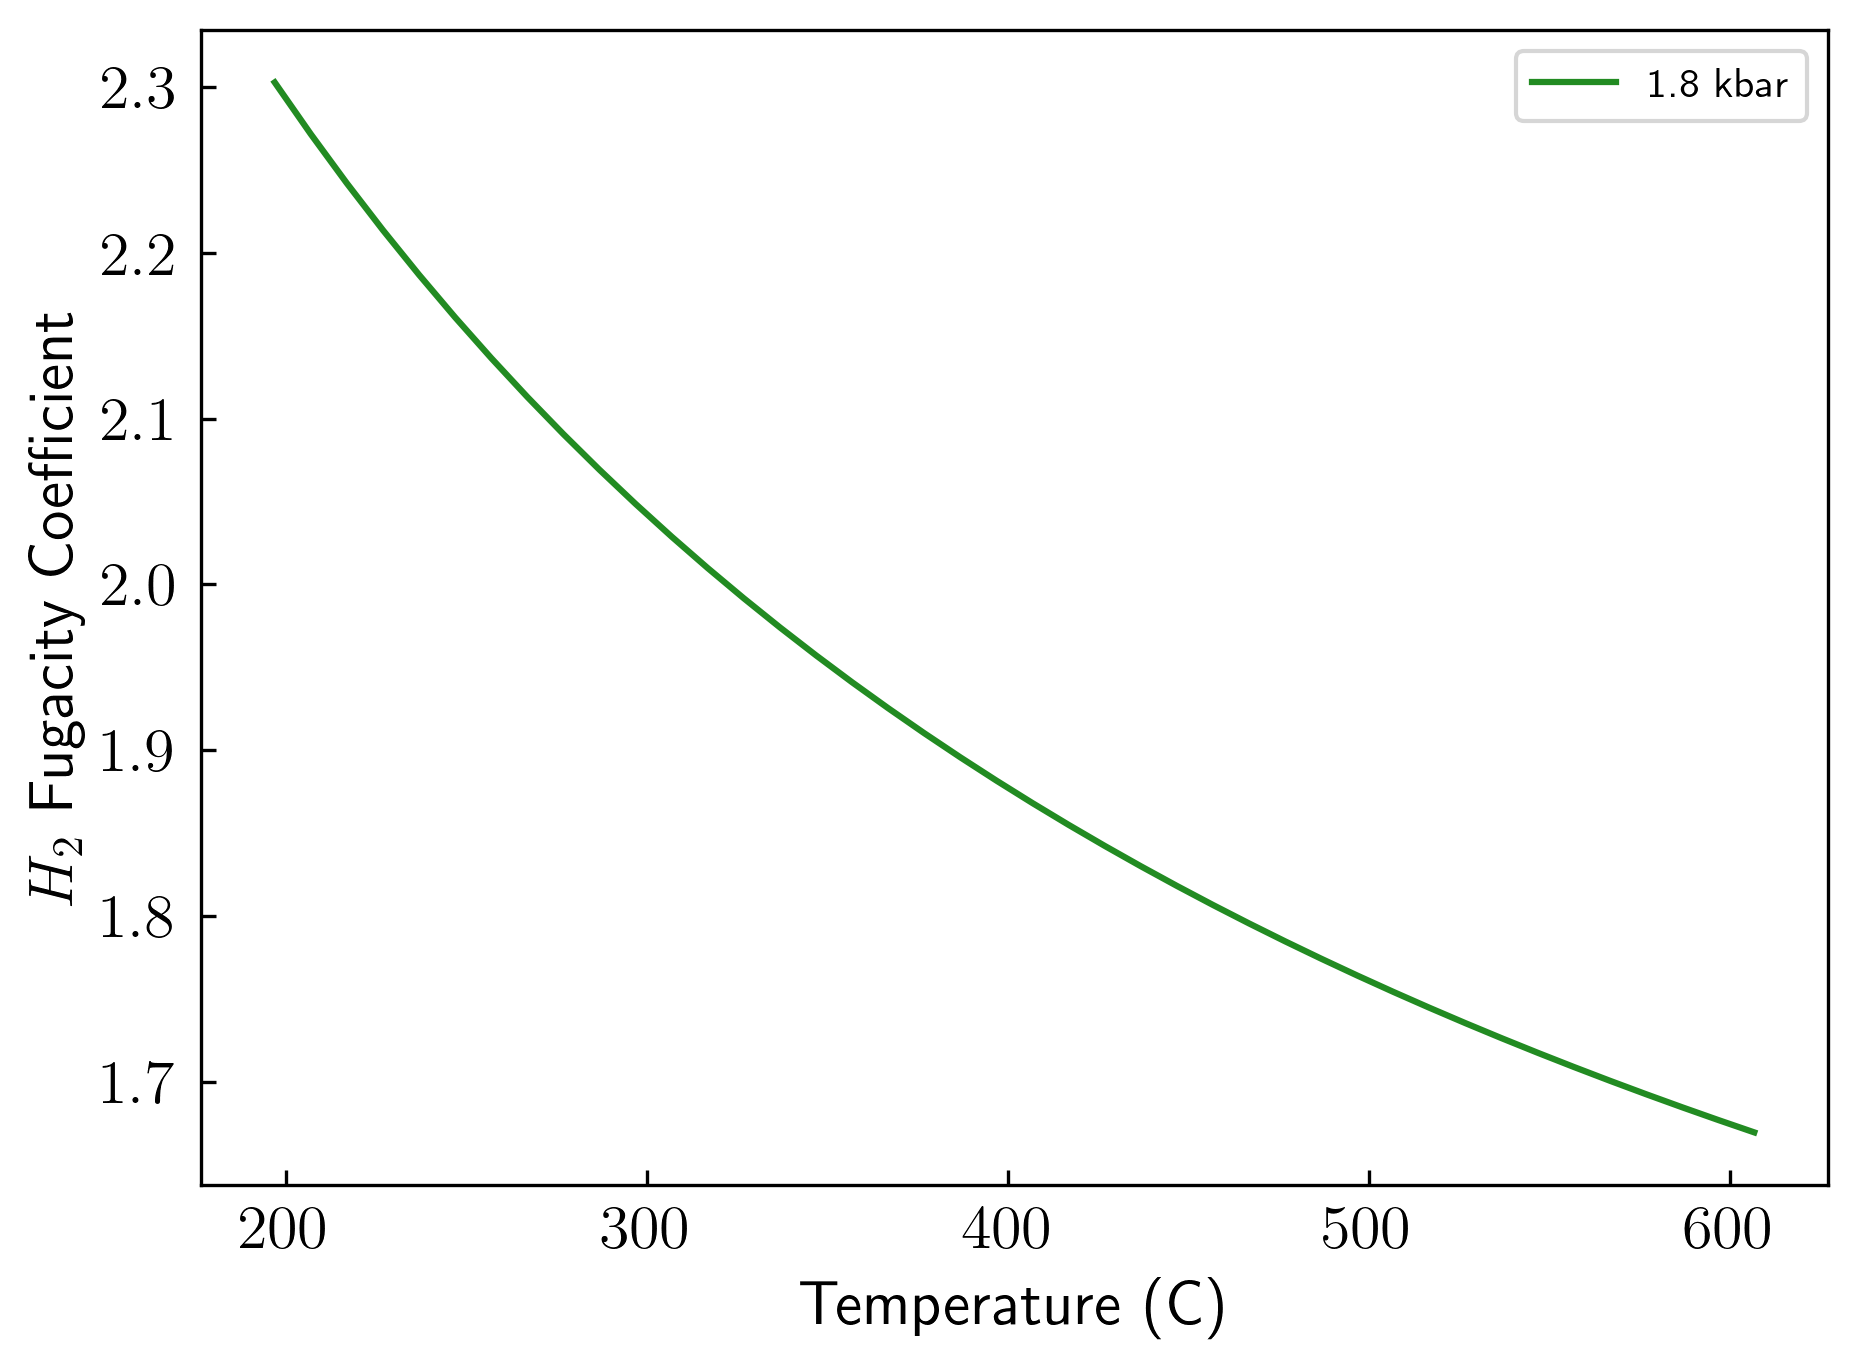

In [38]:
fig, ax = plt.subplots()
plt.plot(temp_arr-273.15, HP_1p8kbar, color='forestgreen', label='1.8 kbar')

plt.legend(fontsize=10)

plt.xlabel('Temperature (C)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
plt.savefig('H2_1p8kbar.jpg', dpi=1000)
plt.show()

In [ ]:
print(HP_1p8kbar)

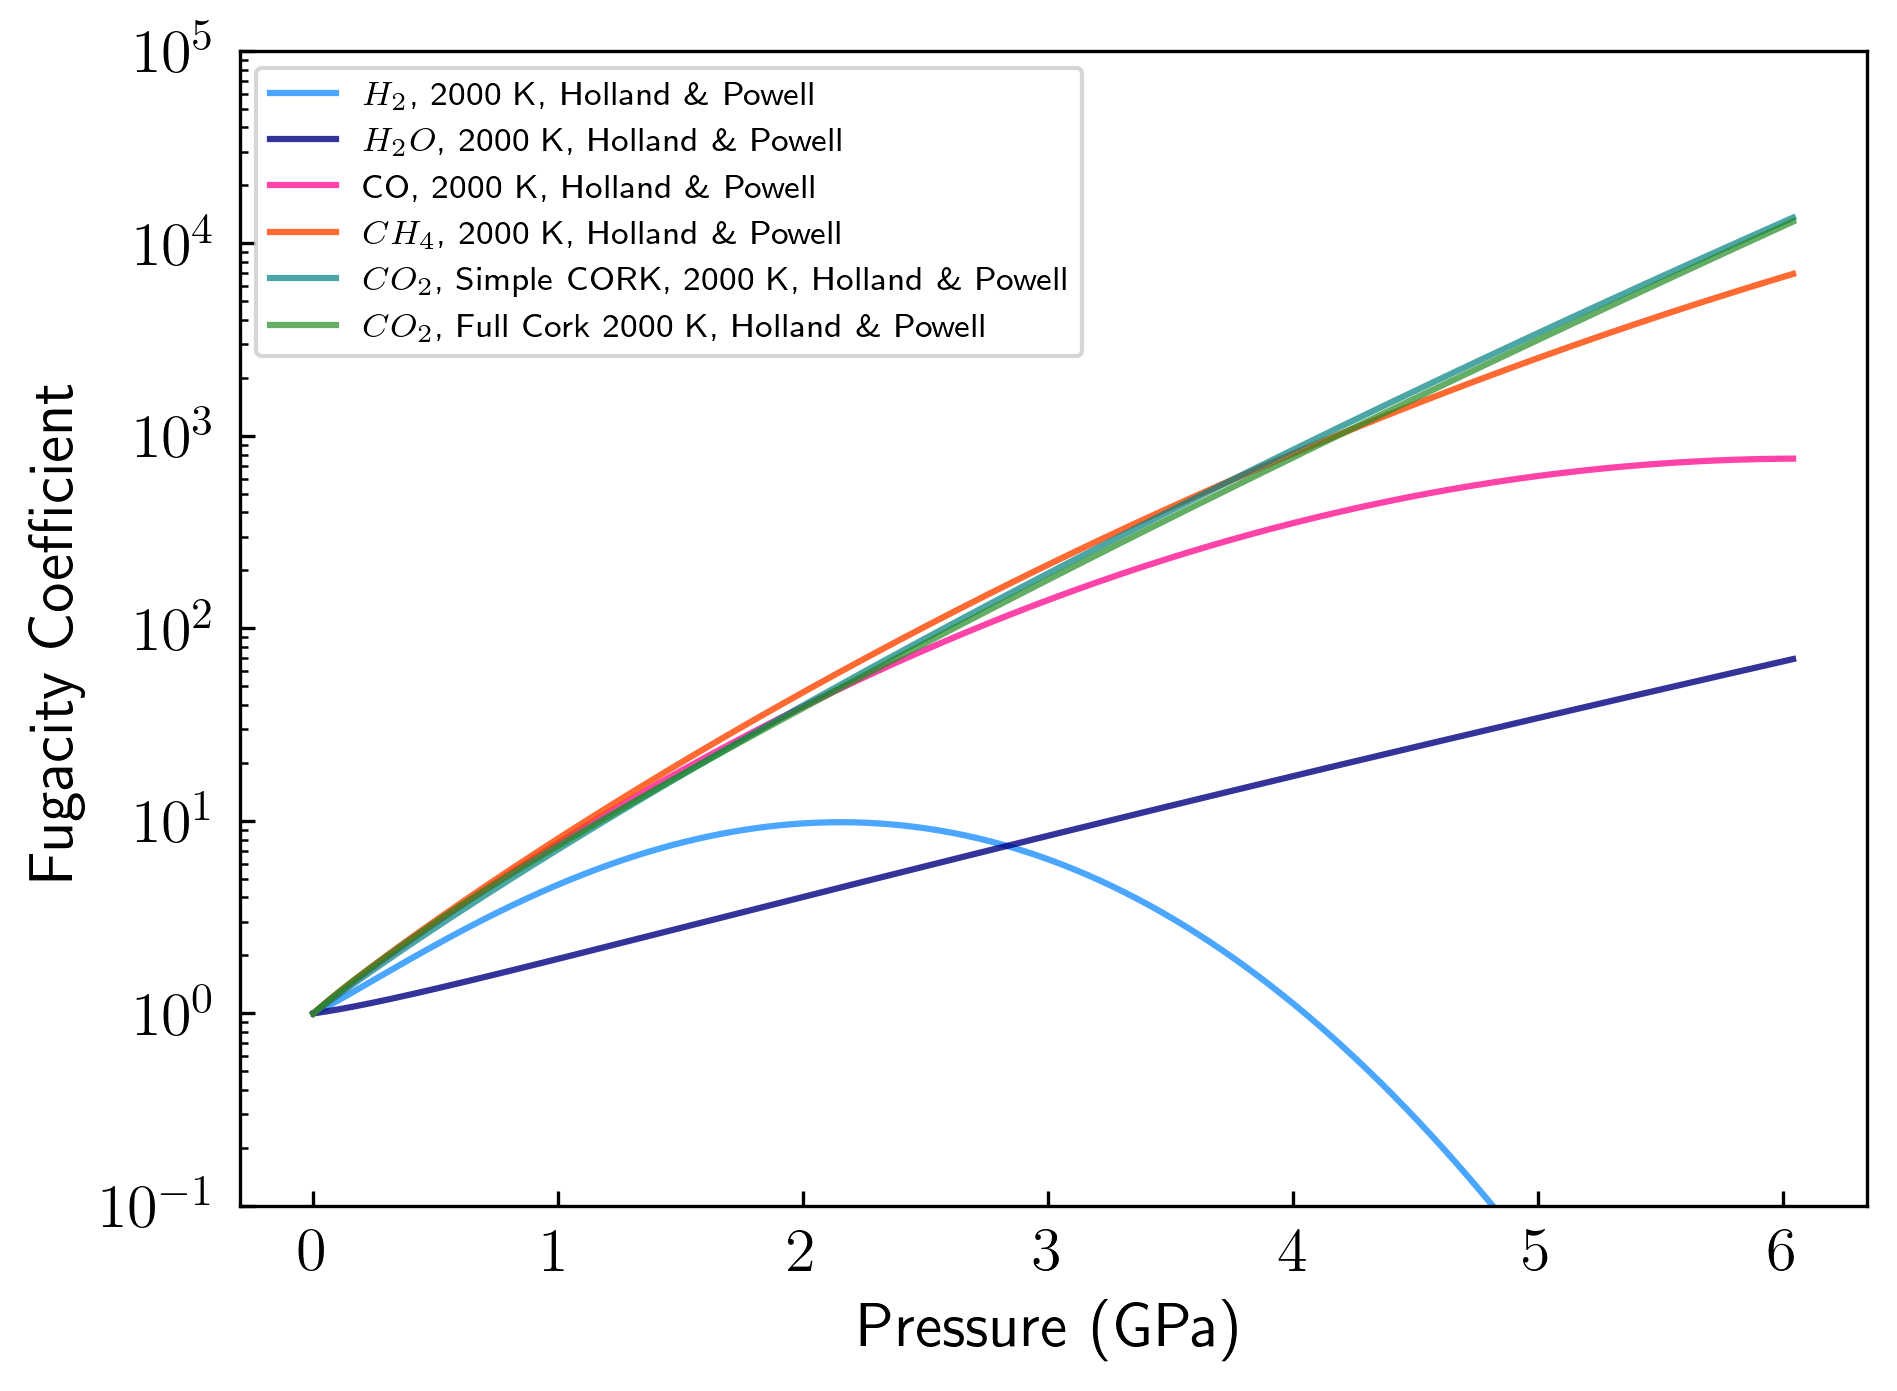

In [47]:
fig,ax = plt.subplots()
#plt.plot(pressure_arr/1e4, HP_1673, color='dodgerblue', linestyle='dotted', label=r'$H_2$, 1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue', alpha=0.8, label=r'$H_2$, 2000 K, Holland \& Powell')
#plt.plot(pressure_arr/1e4, HP_2500, color='dodgerblue', label=r'$H_2$, 2500 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_H2O, color='navy', alpha=0.8, label=r'$H_2O$, 2000 K, Holland \& Powell')

#plt.plot(pressure_arr/1e4, HP_1673_CO, color='violet', linestyle='dotted', label=r'CO, 1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CO, color='deeppink', alpha=0.8, label=r'CO, 2000 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, HP_2000_CH4, color='orangered',  alpha=0.8, label=r'$CH_4$, 2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CO2Simple, color='teal', alpha=0.7, label=r'$CO_2$, Simple CORK, 2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CO2Full, color='forestgreen', alpha=0.7,  label=r'$CO_2$, Full Cork 2000 K, Holland \& Powell')


plt.legend(fontsize=8)
plt.yscale('log')
plt.ylim(0.1, 1e5)
#plt.xlim(-0.01, 8)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'Fugacity Coefficient')
plt.savefig('FugacityCoefficients_HP_VariousCorrespondingStates.jpg', dpi=1000)
plt.show()

In [ ]:
print(HP_2000_CO2)

#### Shi & Saxena Plots

##### H2

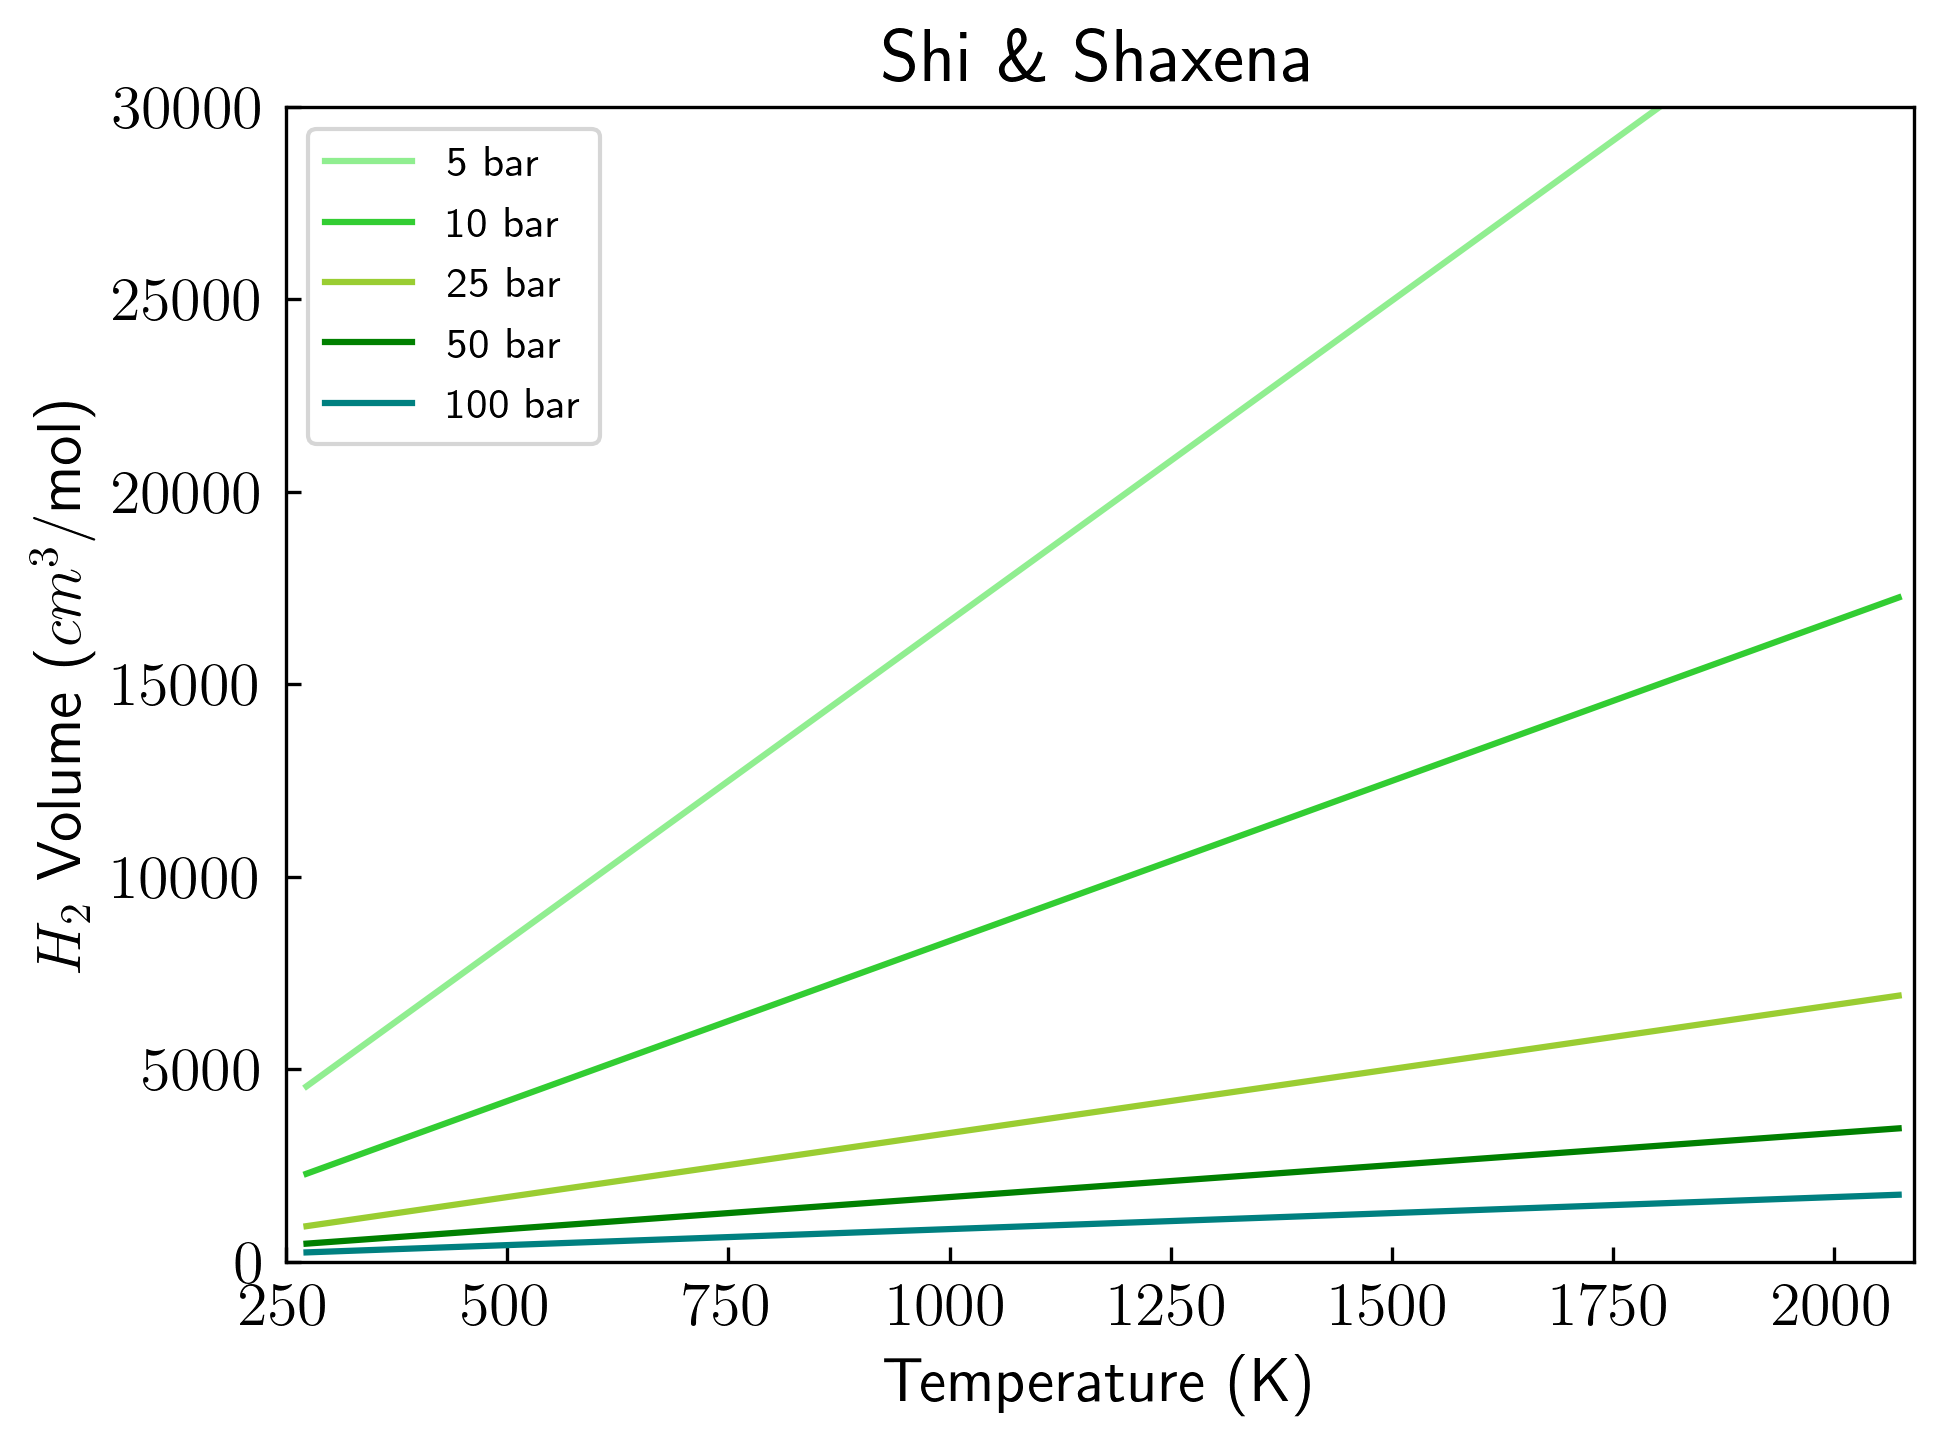

In [109]:
fig,ax = plt.subplots()
plt.plot(temp_arr_SF, SS_model_5bar, color='lightgreen', label=r'5 bar')
plt.plot(temp_arr_SF, SS_model_10bar, color='limegreen', label=r'10 bar')
plt.plot(temp_arr_SF, SS_model_25bar, color='yellowgreen', label=r'25 bar')
plt.plot(temp_arr_SF, SS_model_50bar, color='green', label=r'50 bar')
plt.plot(temp_arr_SF, SS_model_100bar, color='teal', label=r'100 bar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
plt.ylim(0, 30000)
plt.xlim(250, 2090)
plt.ylabel(r'$H_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena')
#plt.savefig('VolumevsT_ShiSaxena.jpg', dpi=1000)
plt.show()

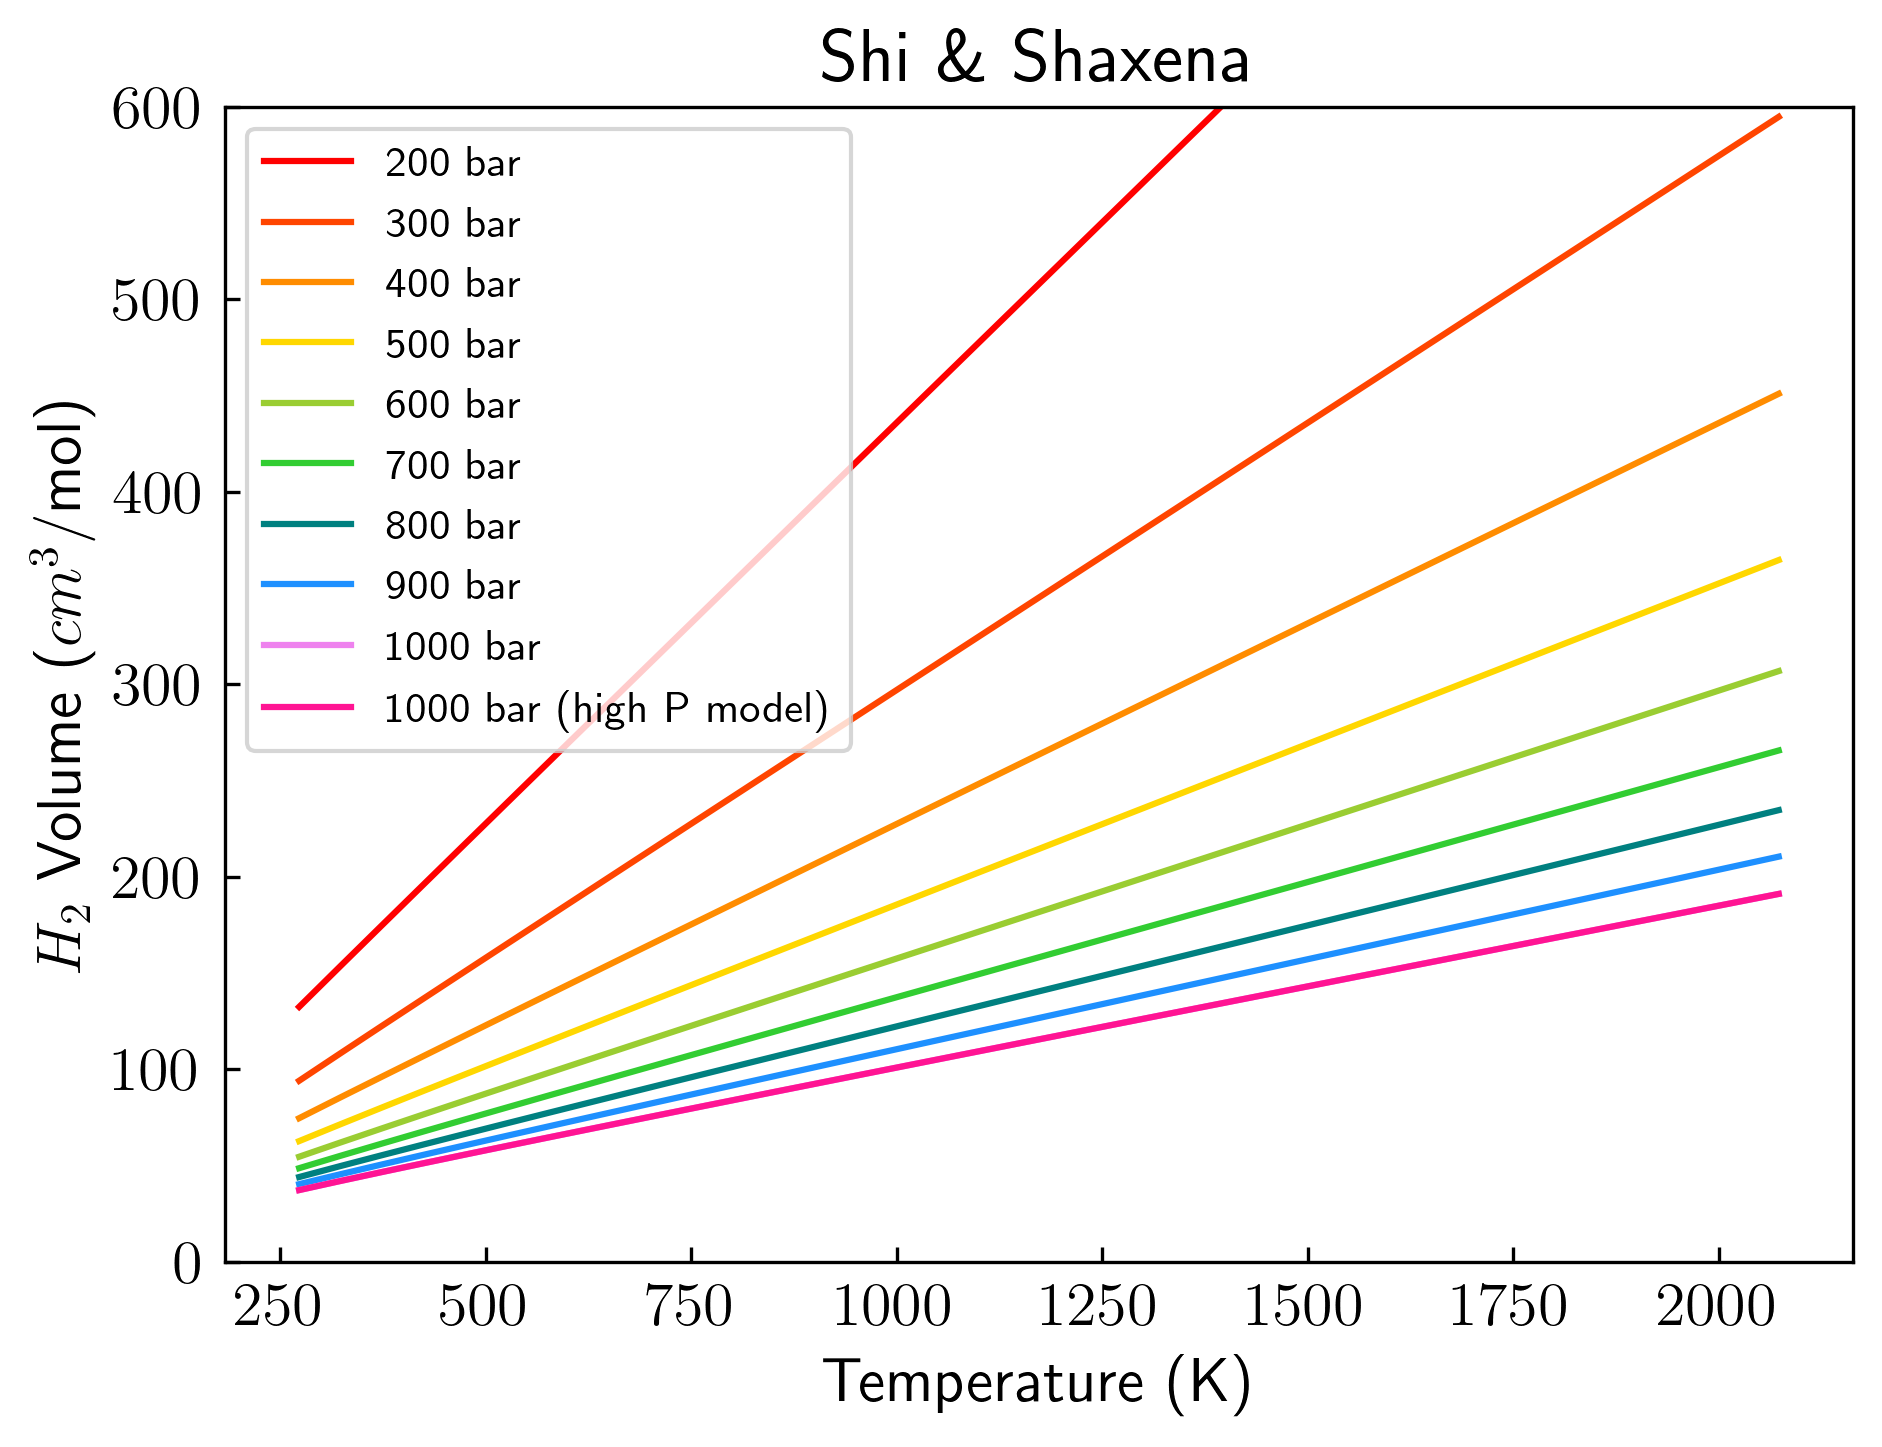

In [110]:
fig,ax = plt.subplots()
plt.plot(temp_arr_SF, SS_model_200bar, color='red', label=r'200 bar')
plt.plot(temp_arr_SF, SS_model_300bar, color='orangered', label=r'300 bar')
plt.plot(temp_arr_SF, SS_model_400bar, color='darkorange', label=r'400 bar')
plt.plot(temp_arr_SF, SS_model_500bar, color='gold', label=r'500 bar')
plt.plot(temp_arr_SF, SS_model_600bar, color='yellowgreen', label=r'600 bar')
plt.plot(temp_arr_SF, SS_model_700bar, color='limegreen', label=r'700 bar')
plt.plot(temp_arr_SF, SS_model_800bar, color='teal', label=r'800 bar')
plt.plot(temp_arr_SF, SS_model_900bar, color='dodgerblue', label=r'900 bar')
plt.plot(temp_arr_SF, SS_model_1000bar, color='violet', label=r'1000 bar')
plt.plot(temp_arr_SF, SS_model_1000bar, color='deeppink', label=r'1000 bar (high P model)')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
plt.ylim(0, 600)
#plt.xlim(250, 2090)
plt.ylabel(r'$H_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena')
plt.savefig('VolumevsT_ShiSaxena_1b.jpg', dpi=1000)
plt.show()

In [12]:
print(SS_model_1000bar_hi)

[11.890941124528627, 1.0418646801495877, -5.10276569627642, -8.234888648510815, -9.328350285123218, -8.982708586363229, -7.586883000473645, -5.403911673516709, -2.61787269610334, 0.63869875785794, 4.26805692950606, 8.19661481195018, 12.367977812814502, 16.73824973073693, 21.272791955117984, 25.94393749989389, 30.72934756193737, 35.61080973115148, 40.57334561390476, 45.60453897795418, 50.694023527522404, 55.83308787770079, 61.01436769617072, 66.23160345010098, 71.47944807259093, 76.75331299895396, 82.04924397270327, 87.36382015049388, 92.69407159011352, 98.03741135300221, 103.39157930789736, 108.7545953654128, 114.12472036139323, 119.50042318020664, 124.88035299690816, 130.2633157406422, 135.64825405632496, 141.0342301790861, 146.42041124475418, 151.80605664631062, 157.19050711560948, 162.57317526549826, 167.95353737264708, 173.33112621810827, 178.70552483261096, 184.07636101817866, 189.4433025379086, 194.8060528824901, 200.16434753593649, 205.51795067457851, 210.86665224304173, 216.210

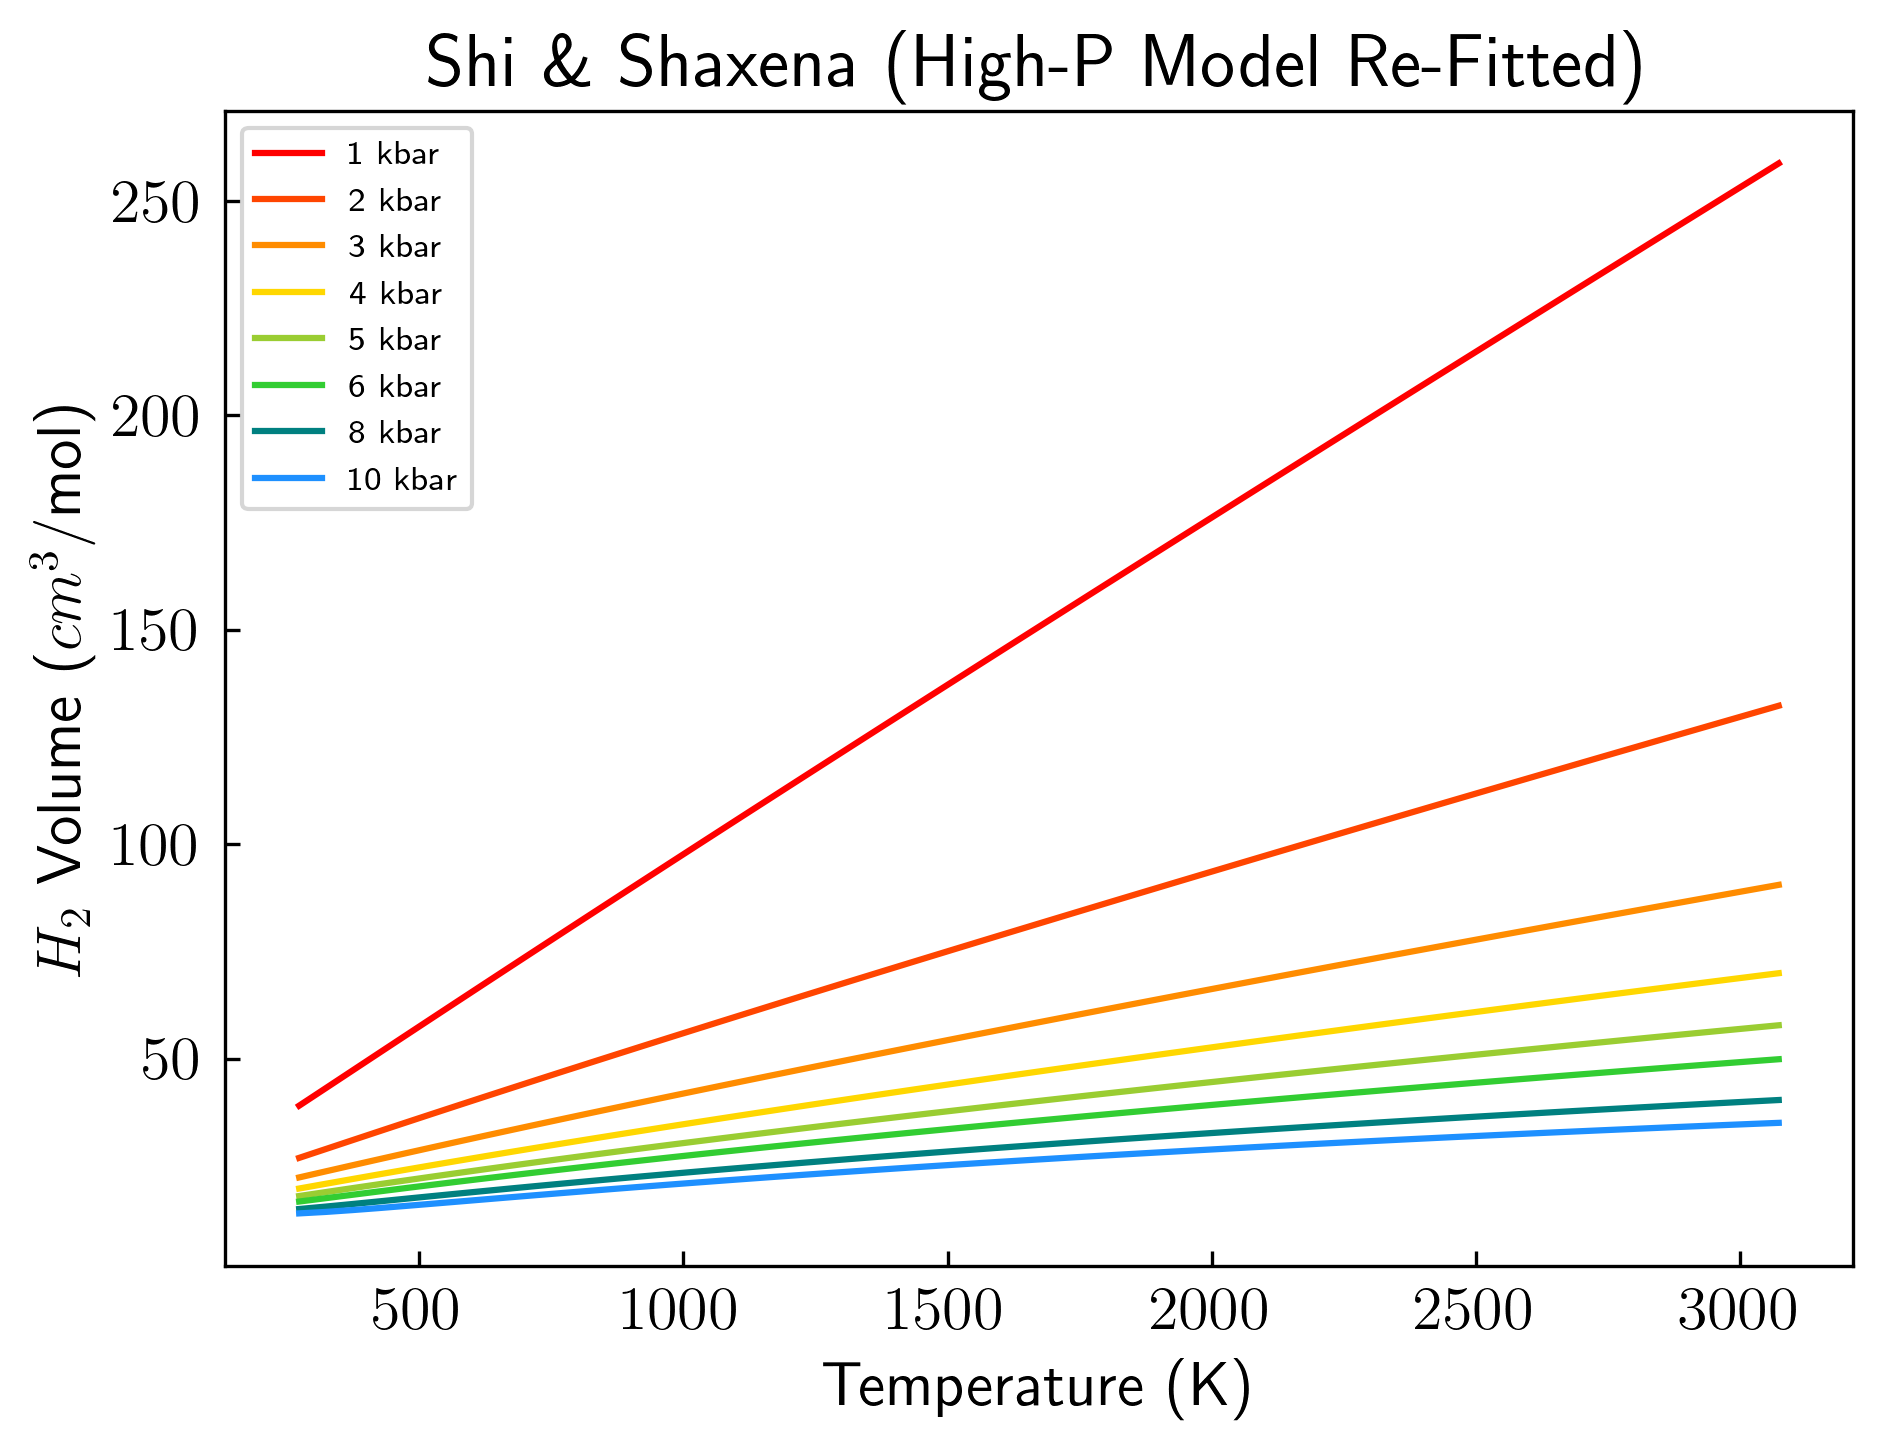

In [111]:
fig,ax = plt.subplots()
plt.plot(temp_arr_SF_hi, SS_model_1000bar_hi, color='red', label=r'1 kbar')
plt.plot(temp_arr_SF_hi, SS_model_2000bar, color='orangered', label=r'2 kbar')
plt.plot(temp_arr_SF_hi, SS_model_3000bar, color='darkorange', label=r'3 kbar')
plt.plot(temp_arr_SF_hi, SS_model_4000bar, color='gold', label=r'4 kbar')
plt.plot(temp_arr_SF_hi, SS_model_5000bar, color='yellowgreen', label=r'5 kbar')
plt.plot(temp_arr_SF_hi, SS_model_6000bar, color='limegreen', label=r'6 kbar')
plt.plot(temp_arr_SF_hi, SS_model_8000bar, color='teal', label=r'8 kbar')
plt.plot(temp_arr_SF_hi, SS_model_10000bar, color='dodgerblue', label=r'10 kbar')
#plt.scatter(df_H2Data['T_K'][0:8], SS_model_RossRee)
#plt.scatter(df_H2Data['T_K'][0:8], df_H2Data['V_cm3mol'][0:8])
plt.legend(fontsize=8)
plt.xlabel('Temperature (K)')
#plt.ylim(0, 120)
#plt.xlim(250, 2090)
plt.ylabel(r'$H_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (High-P Model Re-Fitted)')
#plt.savefig('VolumevsT_ShiSaxena_1c_HighP.jpg', dpi=1000)
plt.show()

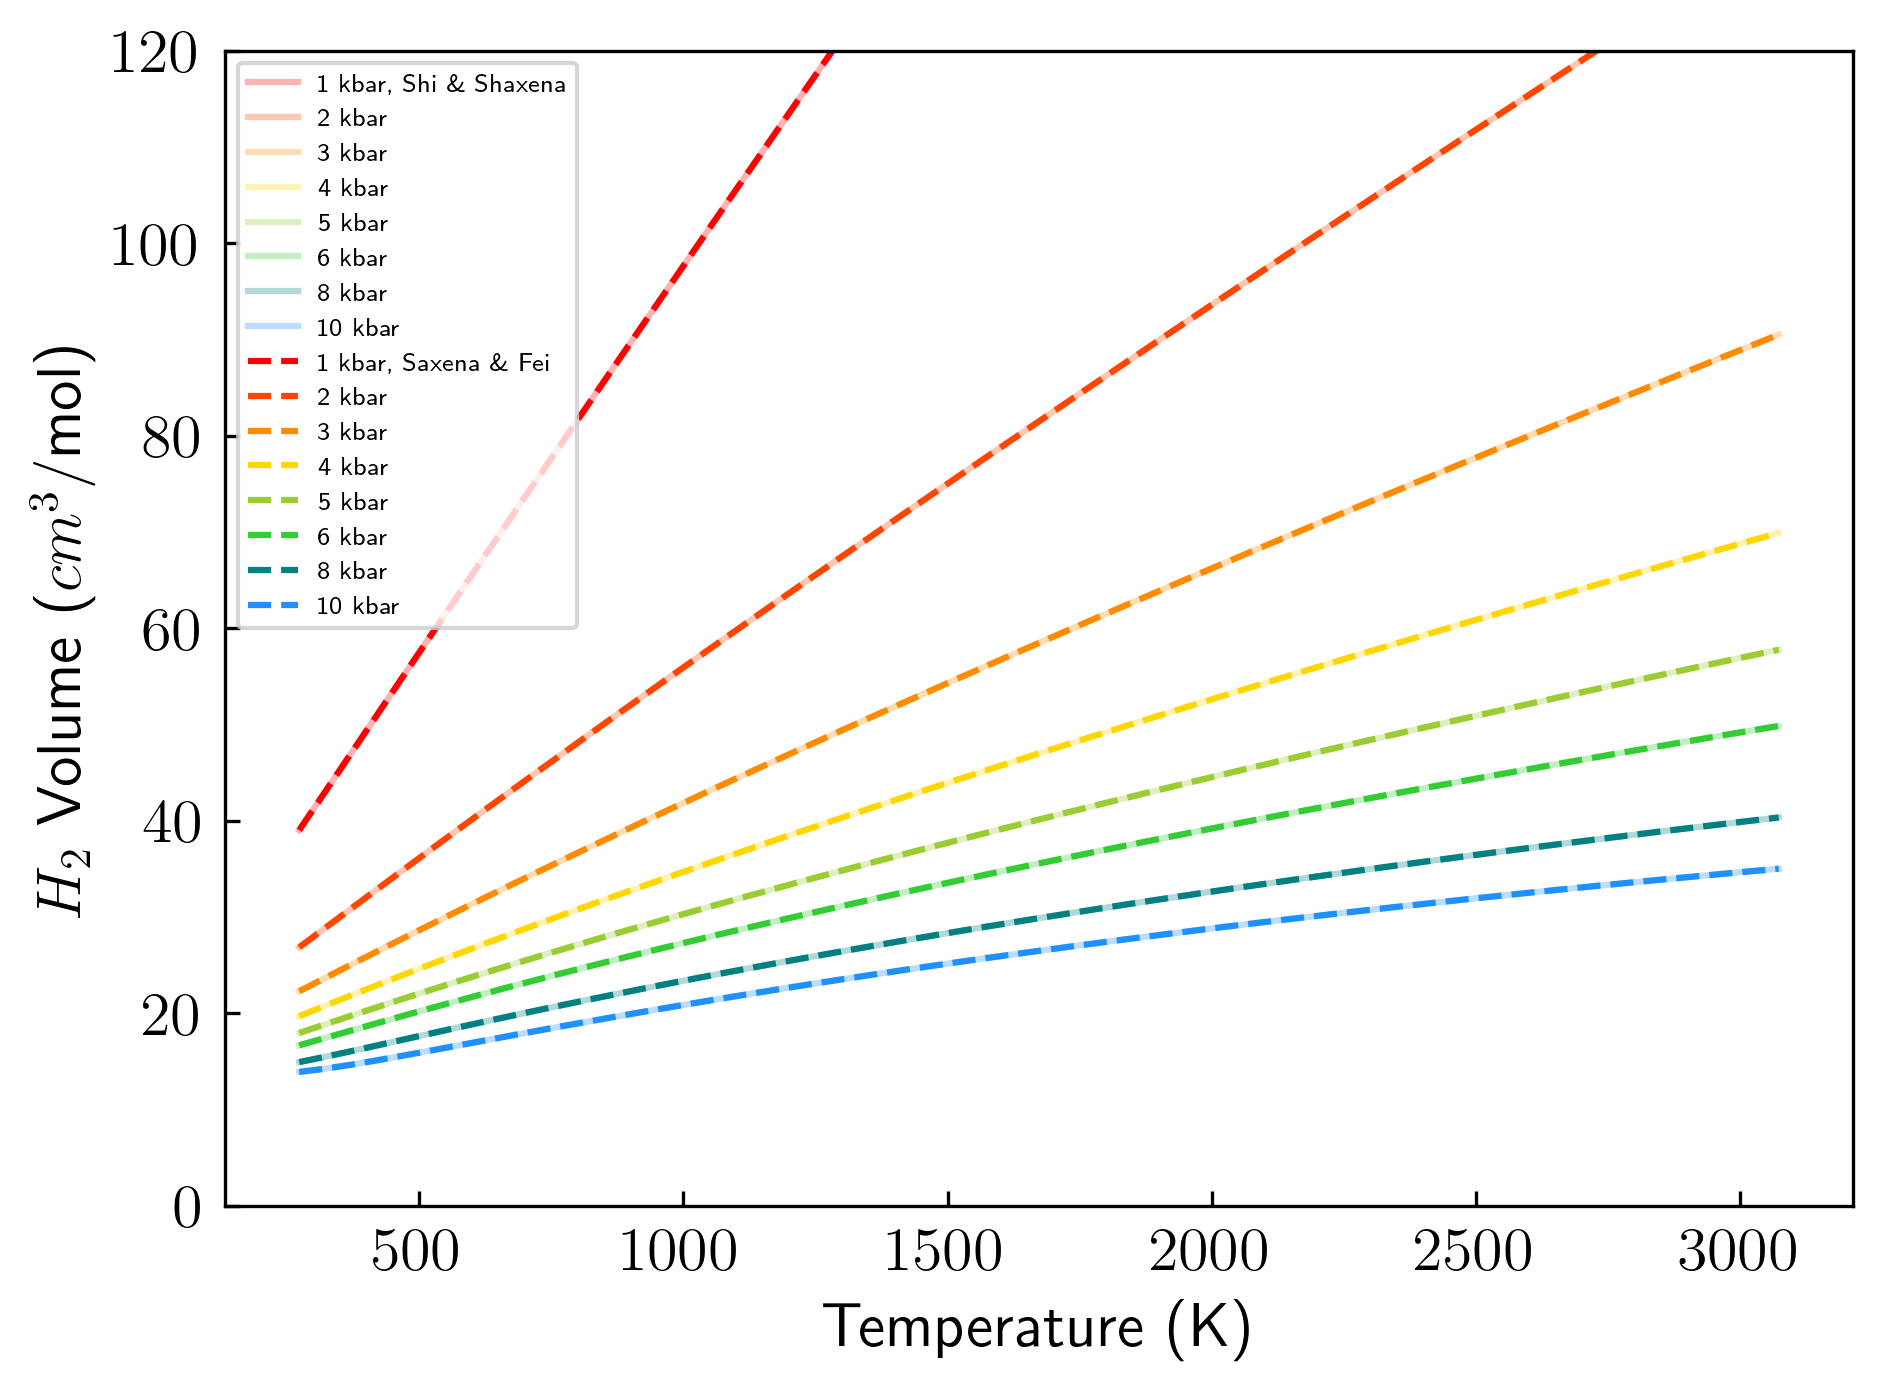

In [112]:
fig,ax = plt.subplots()
plt.plot(temp_arr_SF_hi, SS_model_1000bar_hi, color='red', alpha=0.3, label=r'1 kbar, Shi \& Shaxena')
plt.plot(temp_arr_SF_hi, SS_model_2000bar, color='orangered', alpha=0.3, label=r'2 kbar')
plt.plot(temp_arr_SF_hi, SS_model_3000bar, color='darkorange', alpha=0.3, label=r'3 kbar')
plt.plot(temp_arr_SF_hi, SS_model_4000bar, color='gold', alpha=0.3, label=r'4 kbar')
plt.plot(temp_arr_SF_hi, SS_model_5000bar, color='yellowgreen', alpha=0.3, label=r'5 kbar')
plt.plot(temp_arr_SF_hi, SS_model_6000bar, color='limegreen', alpha=0.3, label=r'6 kbar')
plt.plot(temp_arr_SF_hi, SS_model_8000bar, color='teal', alpha=0.3, label=r'8 kbar')
plt.plot(temp_arr_SF_hi, SS_model_10000bar, color='dodgerblue', alpha=0.3, label=r'10 kbar')

plt.plot(temp_arr_SF_hi, SF_model_1000bar, linestyle='--', color='red', label=r'1 kbar, Saxena \& Fei')
plt.plot(temp_arr_SF_hi, SF_model_2000bar, linestyle='--',color='orangered', label=r'2 kbar')
plt.plot(temp_arr_SF_hi, SF_model_3000bar, linestyle='--',color='darkorange', label=r'3 kbar')
plt.plot(temp_arr_SF_hi, SF_model_4000bar, linestyle='--',color='gold', label=r'4 kbar')
plt.plot(temp_arr_SF_hi, SF_model_5000bar, linestyle='--',color='yellowgreen', label=r'5 kbar')
plt.plot(temp_arr_SF_hi, SF_model_6000bar, linestyle='--',color='limegreen', label=r'6 kbar')
plt.plot(temp_arr_SF_hi, SF_model_8000bar, linestyle='--',color='teal', label=r'8 kbar')
plt.plot(temp_arr_SF_hi, SF_model_10000bar, linestyle='--',color='dodgerblue', label=r'10 kbar')

plt.legend(fontsize=6)
plt.xlabel('Temperature (K)')
plt.ylim(0, 120)
#plt.xlim(250, 2090)
plt.ylabel(r'$H_2$ Volume ($cm^3$/mol)')
#plt.title(r'Shi \& Shaxena (Low-P Model Extrapolated)')
#plt.savefig('VolumevsT_HighP_ShiSaxenavsSaxenaFei.jpg', dpi=1000)
plt.show()

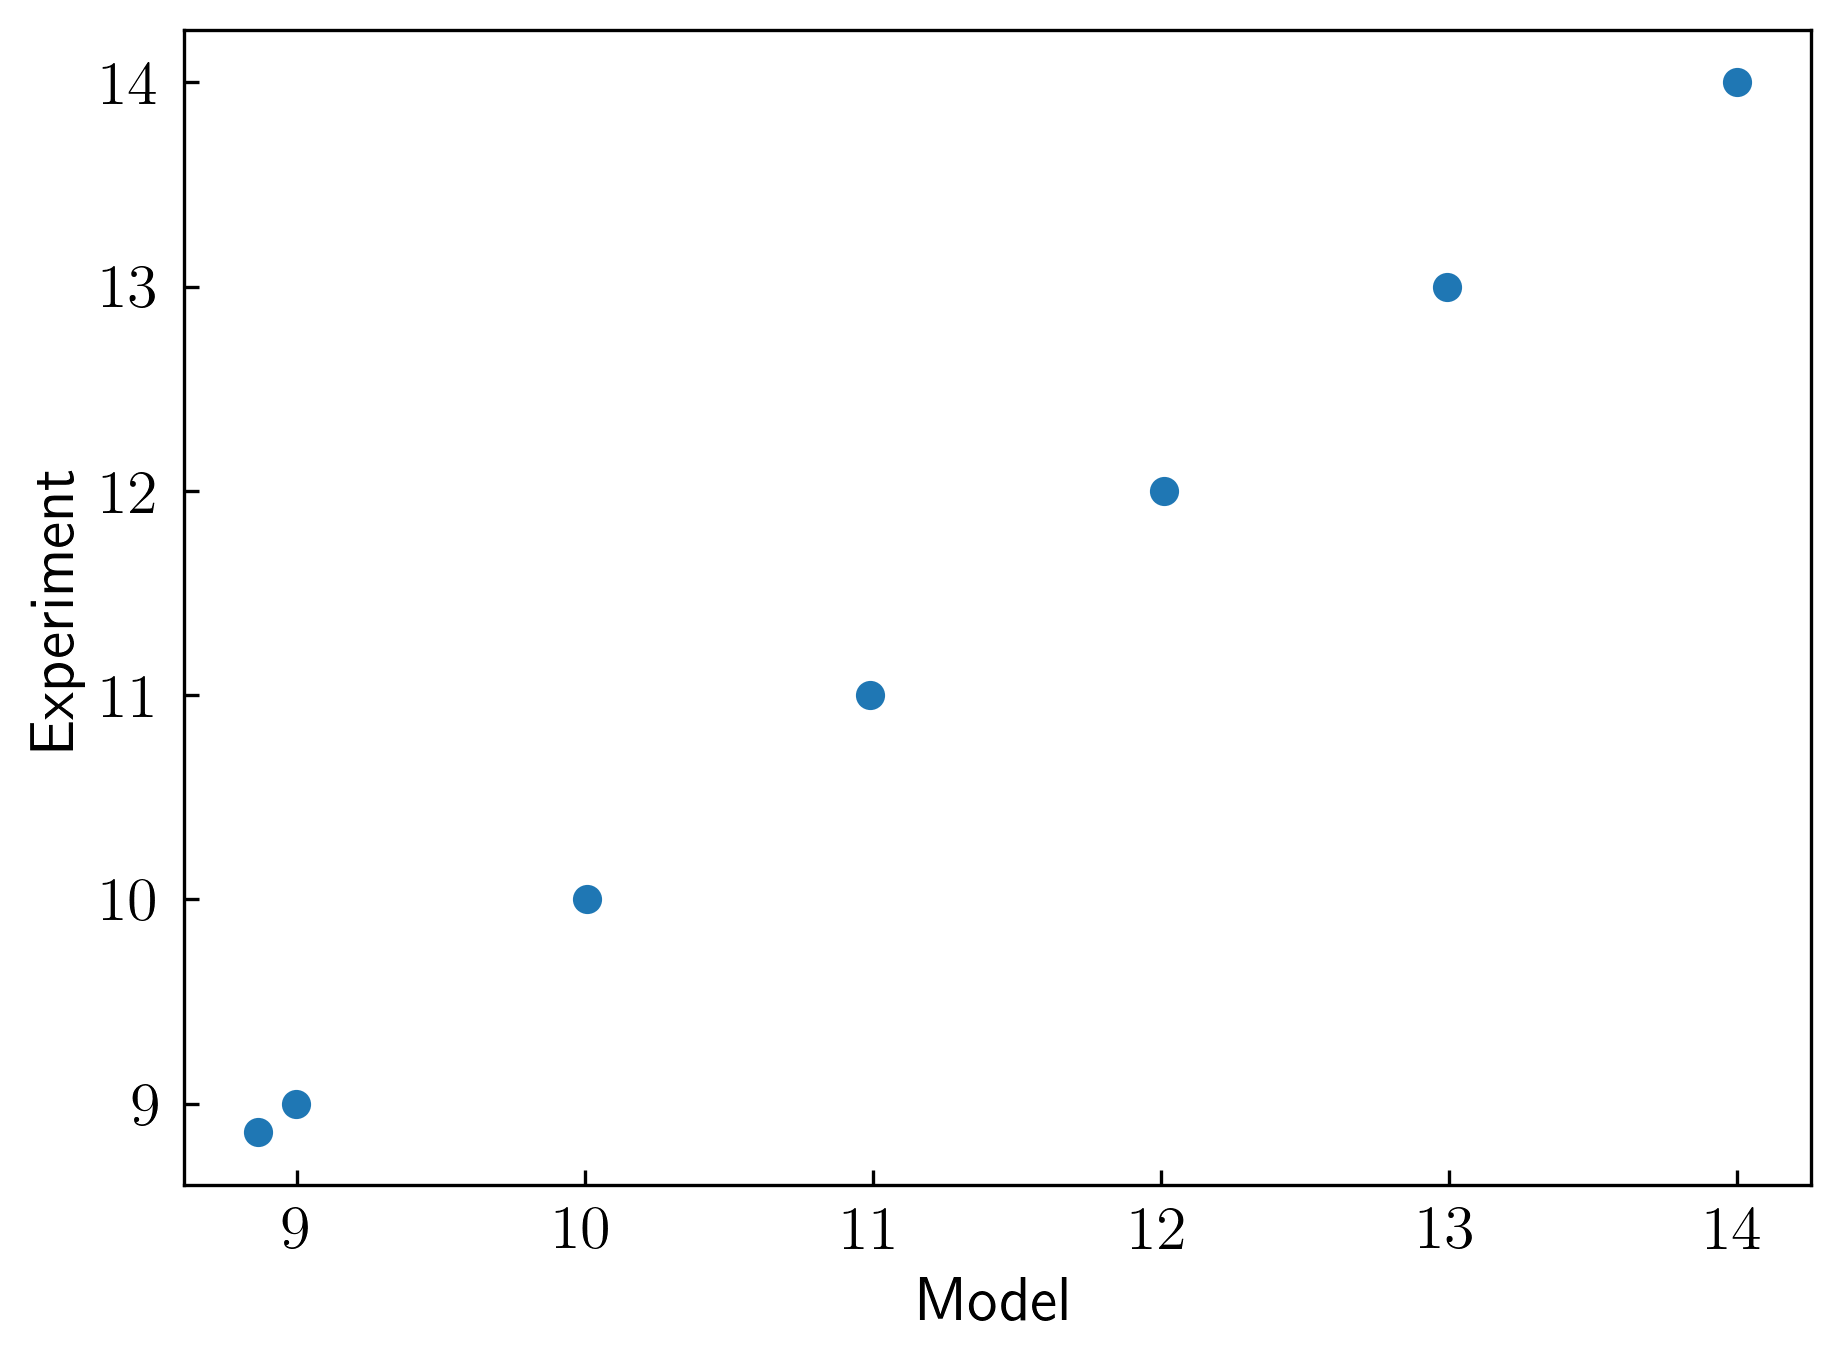

In [113]:
fig, ax = plt.subplots()
plt.scatter(SS_model_RossRee[1:8], df_H2Data['V_cm3mol'][1:8])
plt.xlabel('Model')
plt.ylabel('Experiment')
plt.show()

##### Other Species 

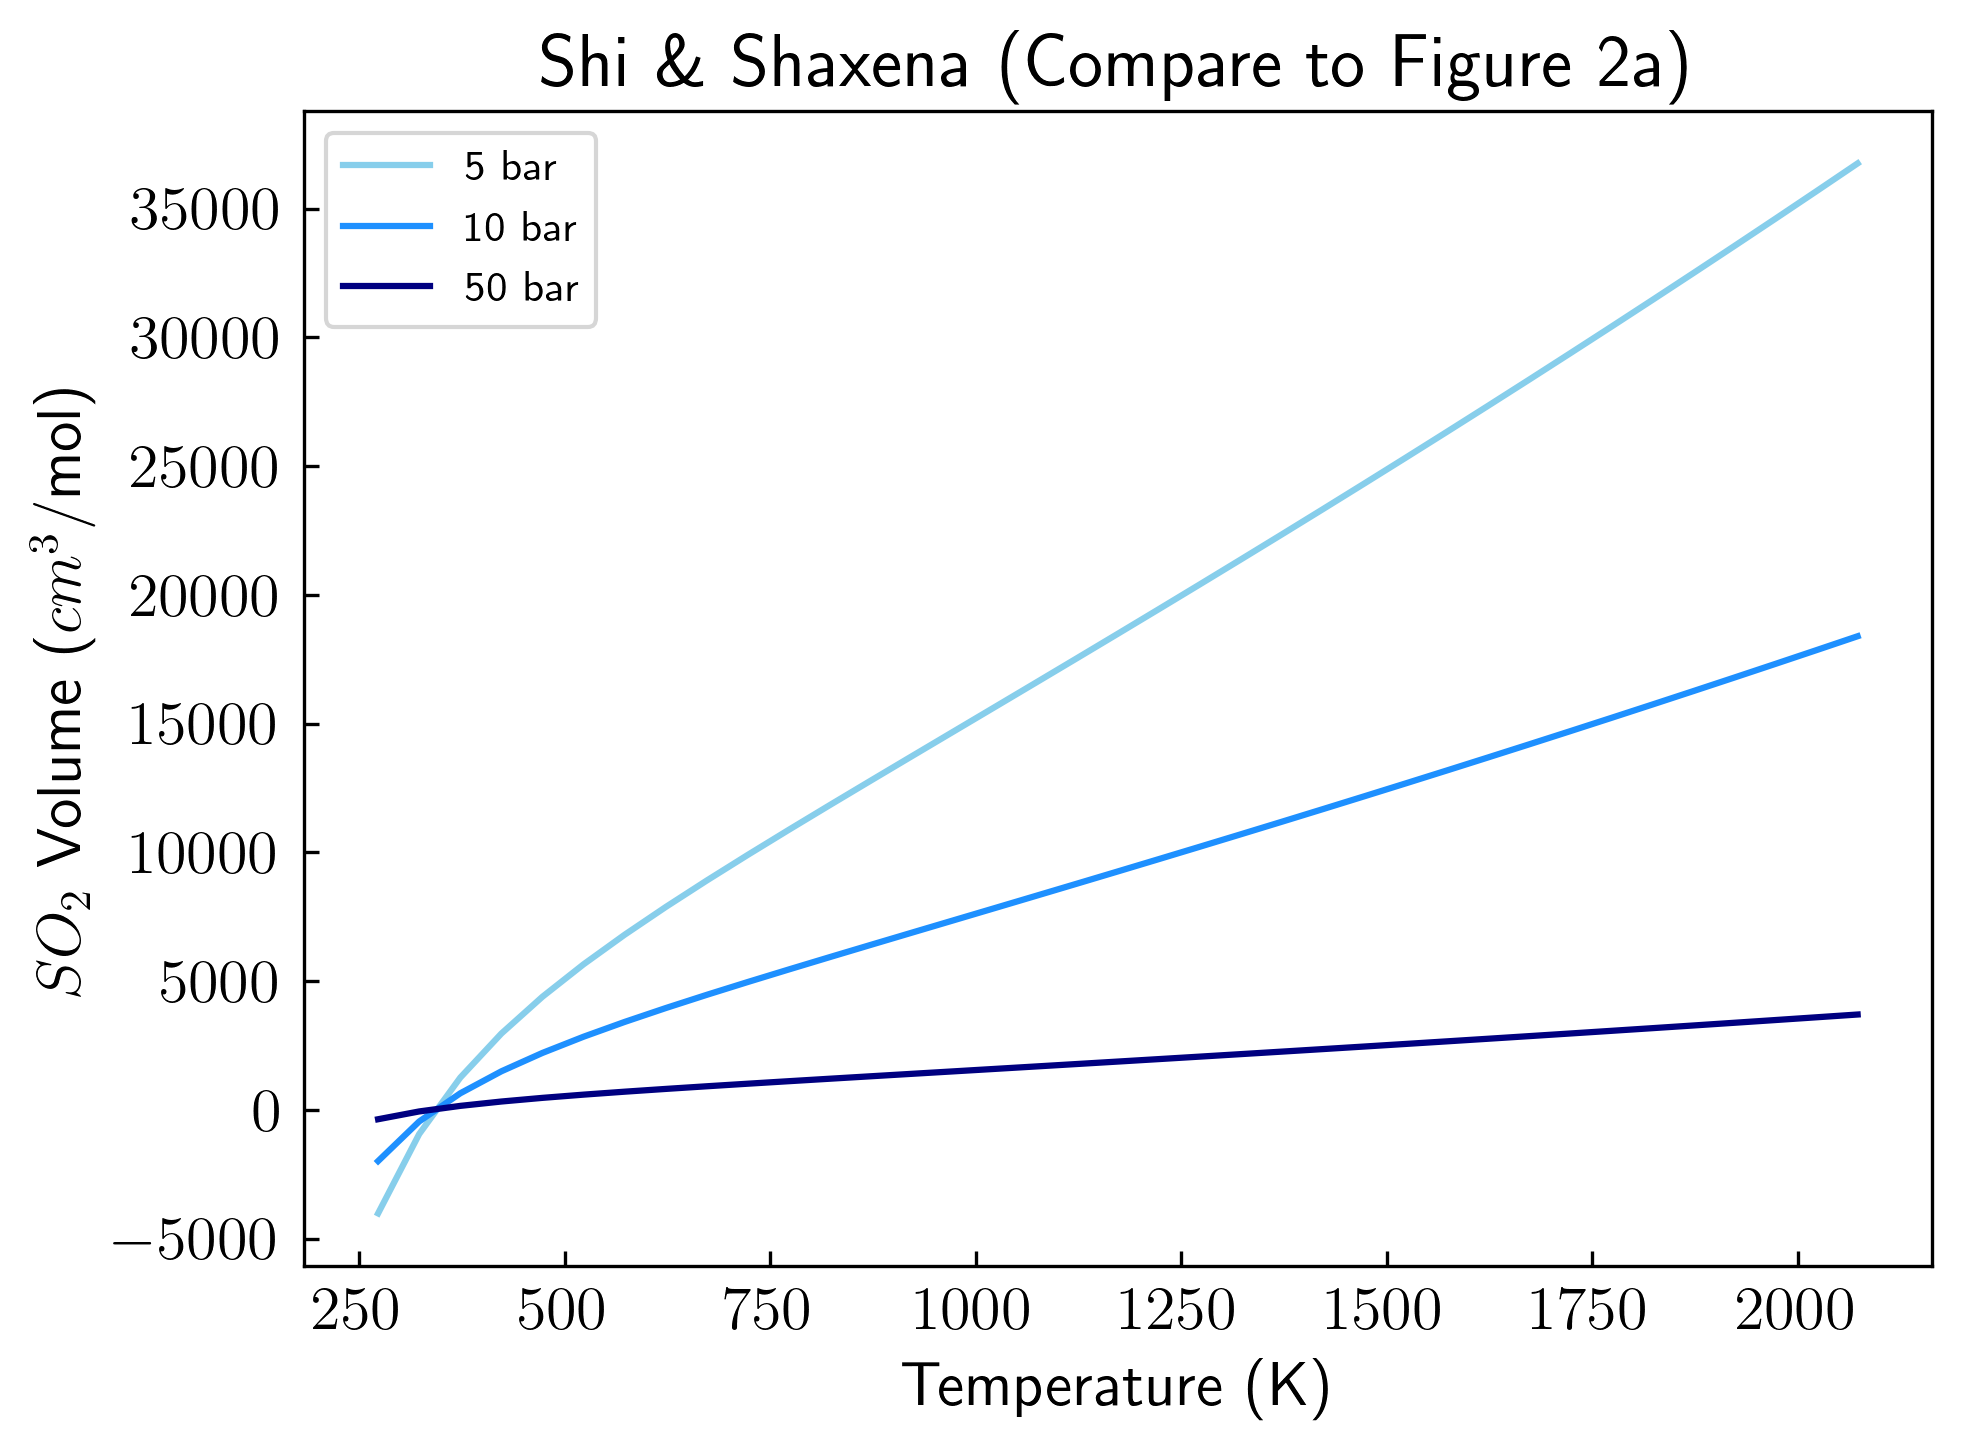

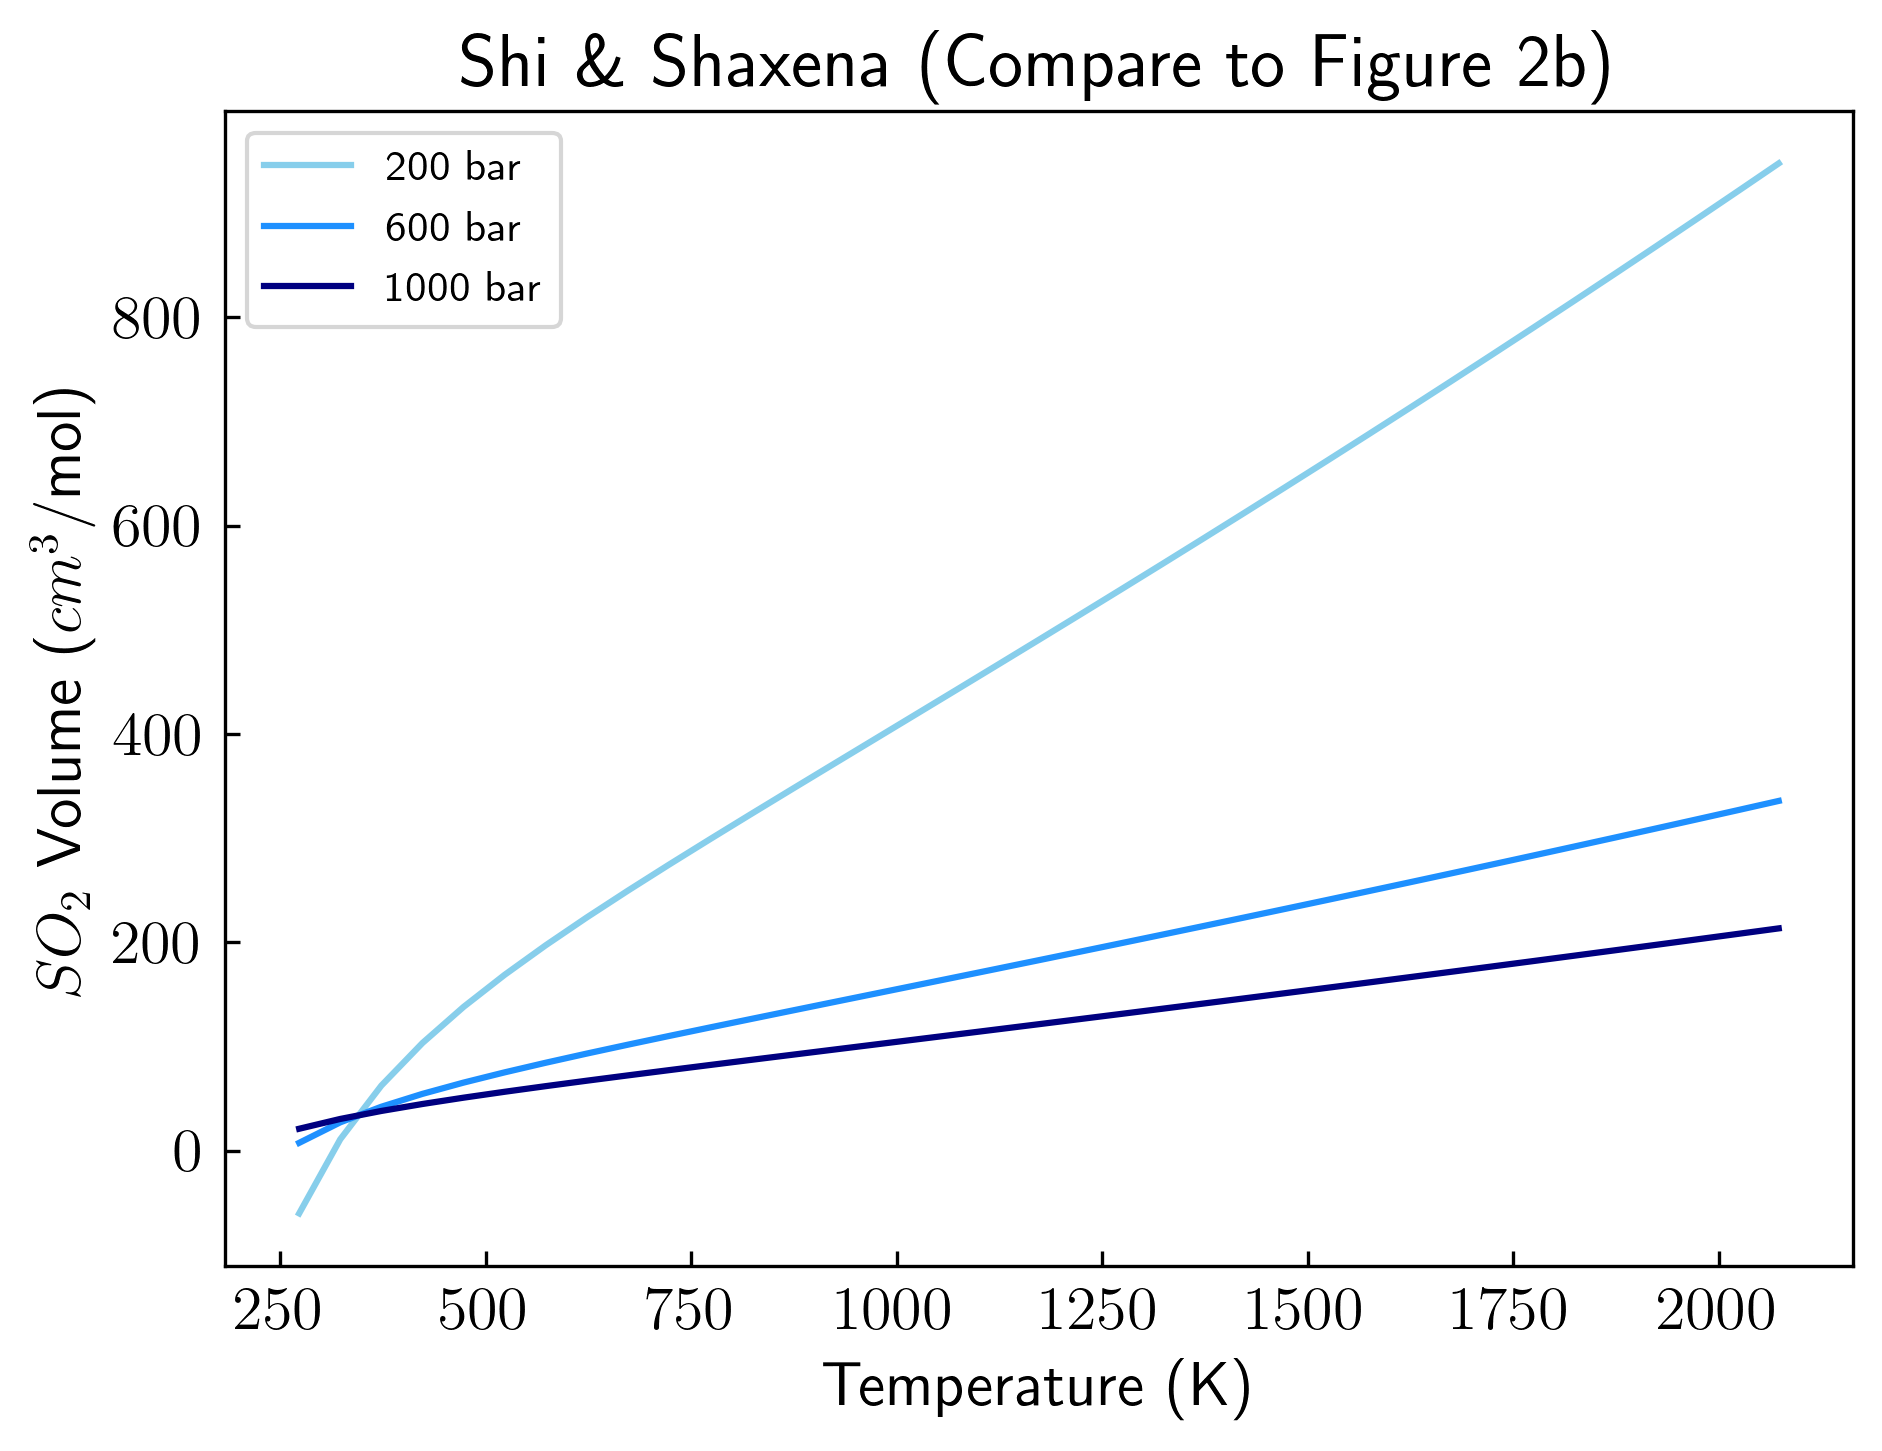

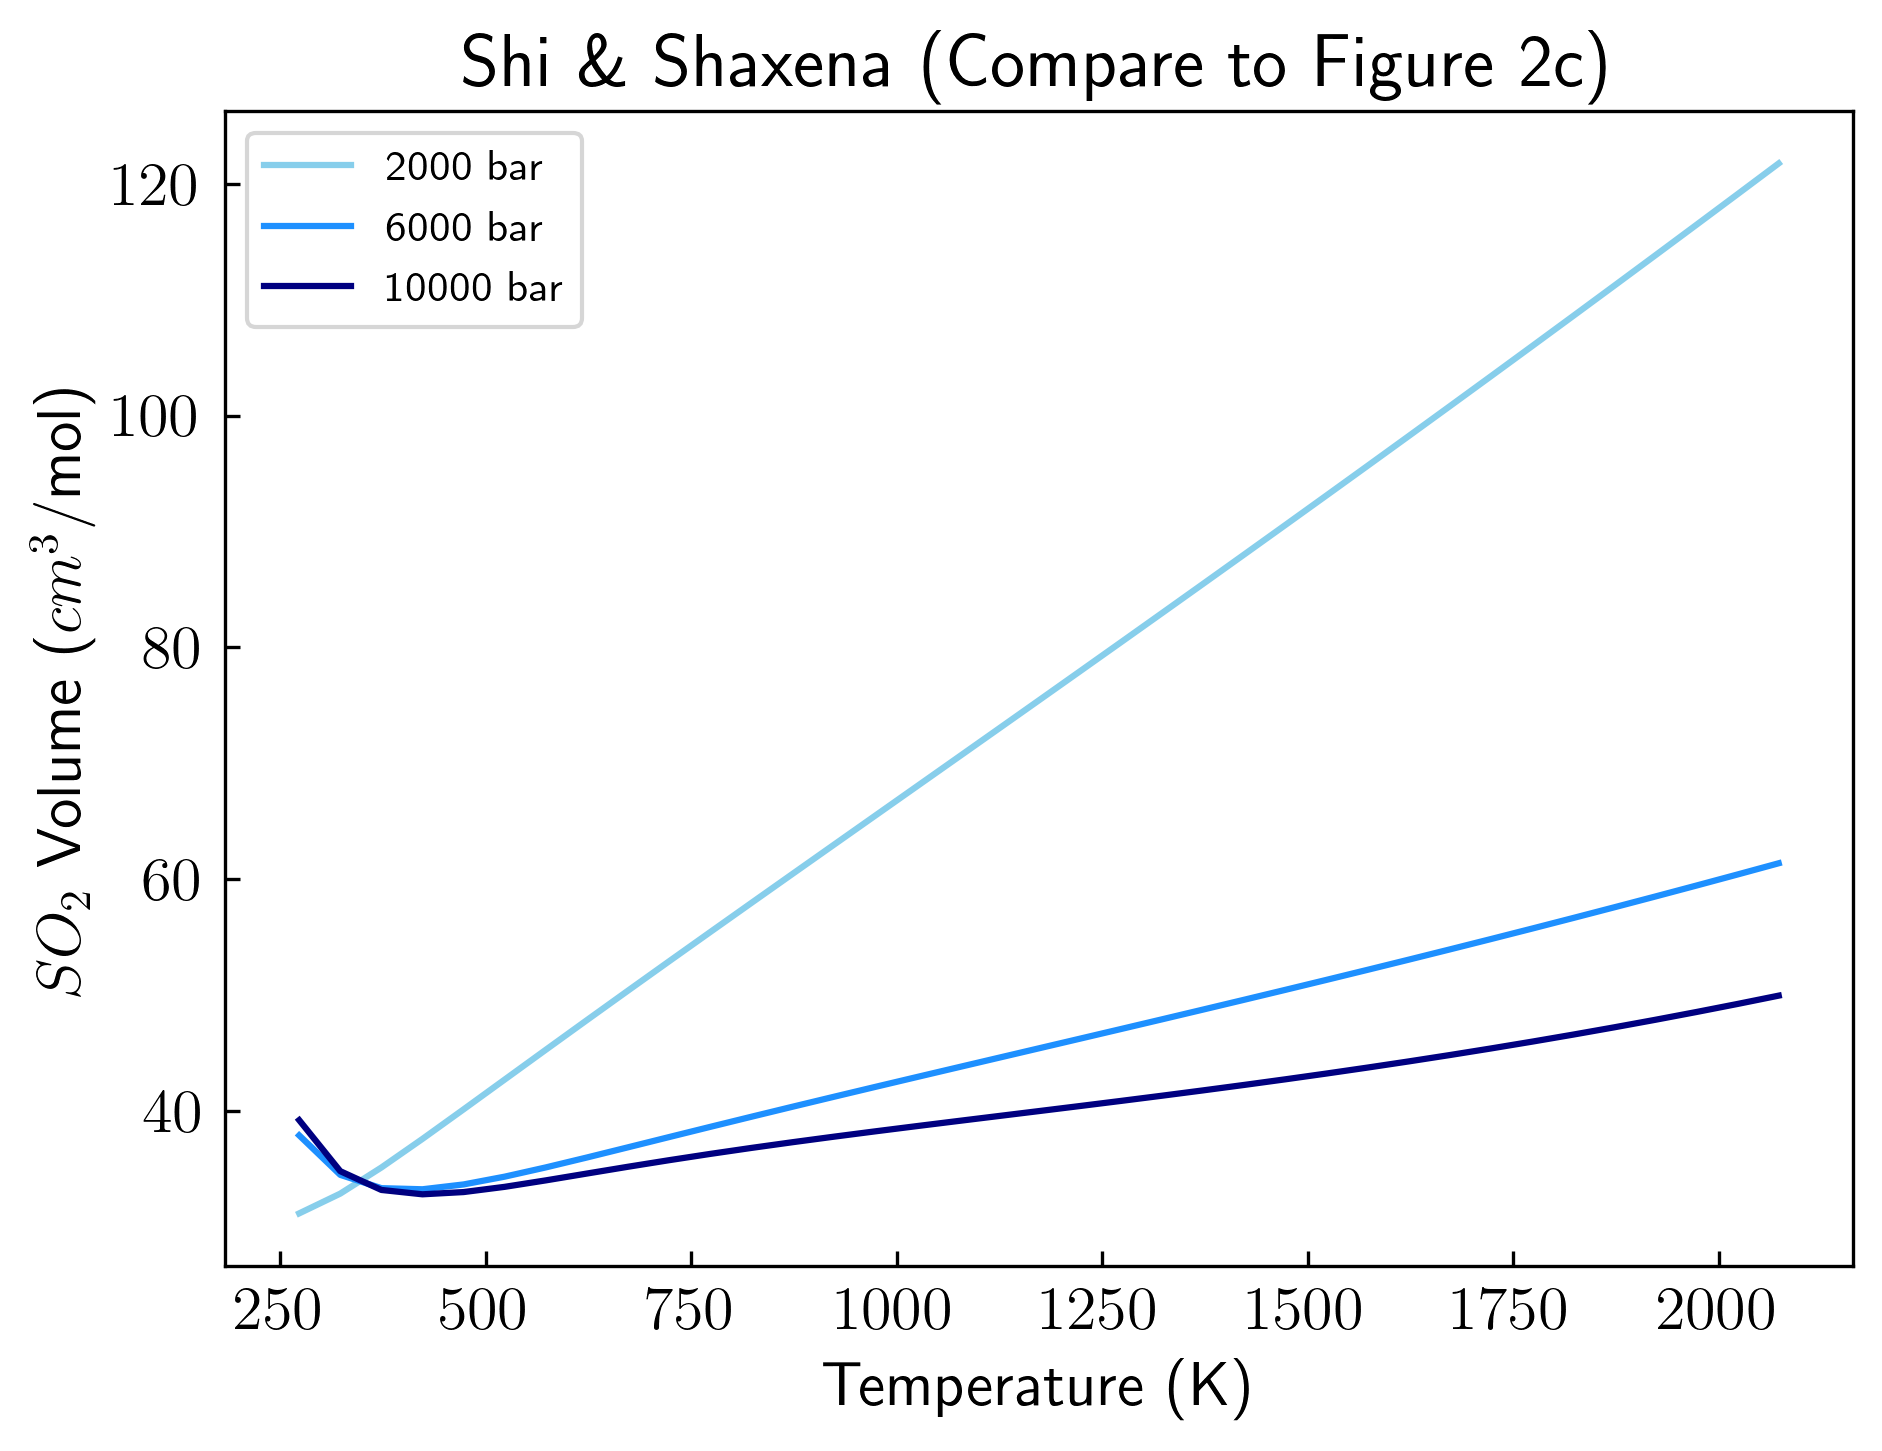

In [66]:
fig,axs = plt.subplots()
plt.plot(temp_arr_SF, SS_SO2_5bars, color='skyblue', label=r'5 bar')
plt.plot(temp_arr_SF, SS_SO2_10bars, color='dodgerblue', label=r'10 bar')
plt.plot(temp_arr_SF, SS_SO2_50bars, color='navy', label=r'50 bar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
#plt.ylim(0, 600)
#plt.xlim(250, 2090)
plt.ylabel(r'$SO_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (Compare to Figure 2a)')
plt.savefig('VolumevsT_ShiSaxena_SO2_2a.jpg', dpi=1000)
plt.show()

fig,axs = plt.subplots()
plt.plot(temp_arr_SF, SS_SO2_200bars, color='skyblue', label=r'200 bar')
plt.plot(temp_arr_SF, SS_SO2_600bars, color='dodgerblue', label=r'600 bar')
plt.plot(temp_arr_SF, SS_SO2_1000bars, color='navy', label=r'1000 bar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
#plt.ylim(0, 600)
#plt.xlim(250, 2090)
plt.ylabel(r'$SO_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (Compare to Figure 2b)')
plt.savefig('VolumevsT_ShiSaxena_SO2_2b.jpg', dpi=1000)
plt.show()

fig,axs = plt.subplots()
plt.plot(temp_arr_SF, SS_SO2_2000bars, color='skyblue', label=r'2000 bar')
plt.plot(temp_arr_SF, SS_SO2_6000bars, color='dodgerblue', label=r'6000 bar')
plt.plot(temp_arr_SF, SS_SO2_10000bars, color='navy', label=r'10000 bar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
#plt.ylim(0, 600)
#plt.xlim(250, 2090)
plt.ylabel(r'$SO_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (Compare to Figure 2c)')
plt.savefig('VolumevsT_ShiSaxena_SO2_2c.jpg', dpi=1000)
plt.show()

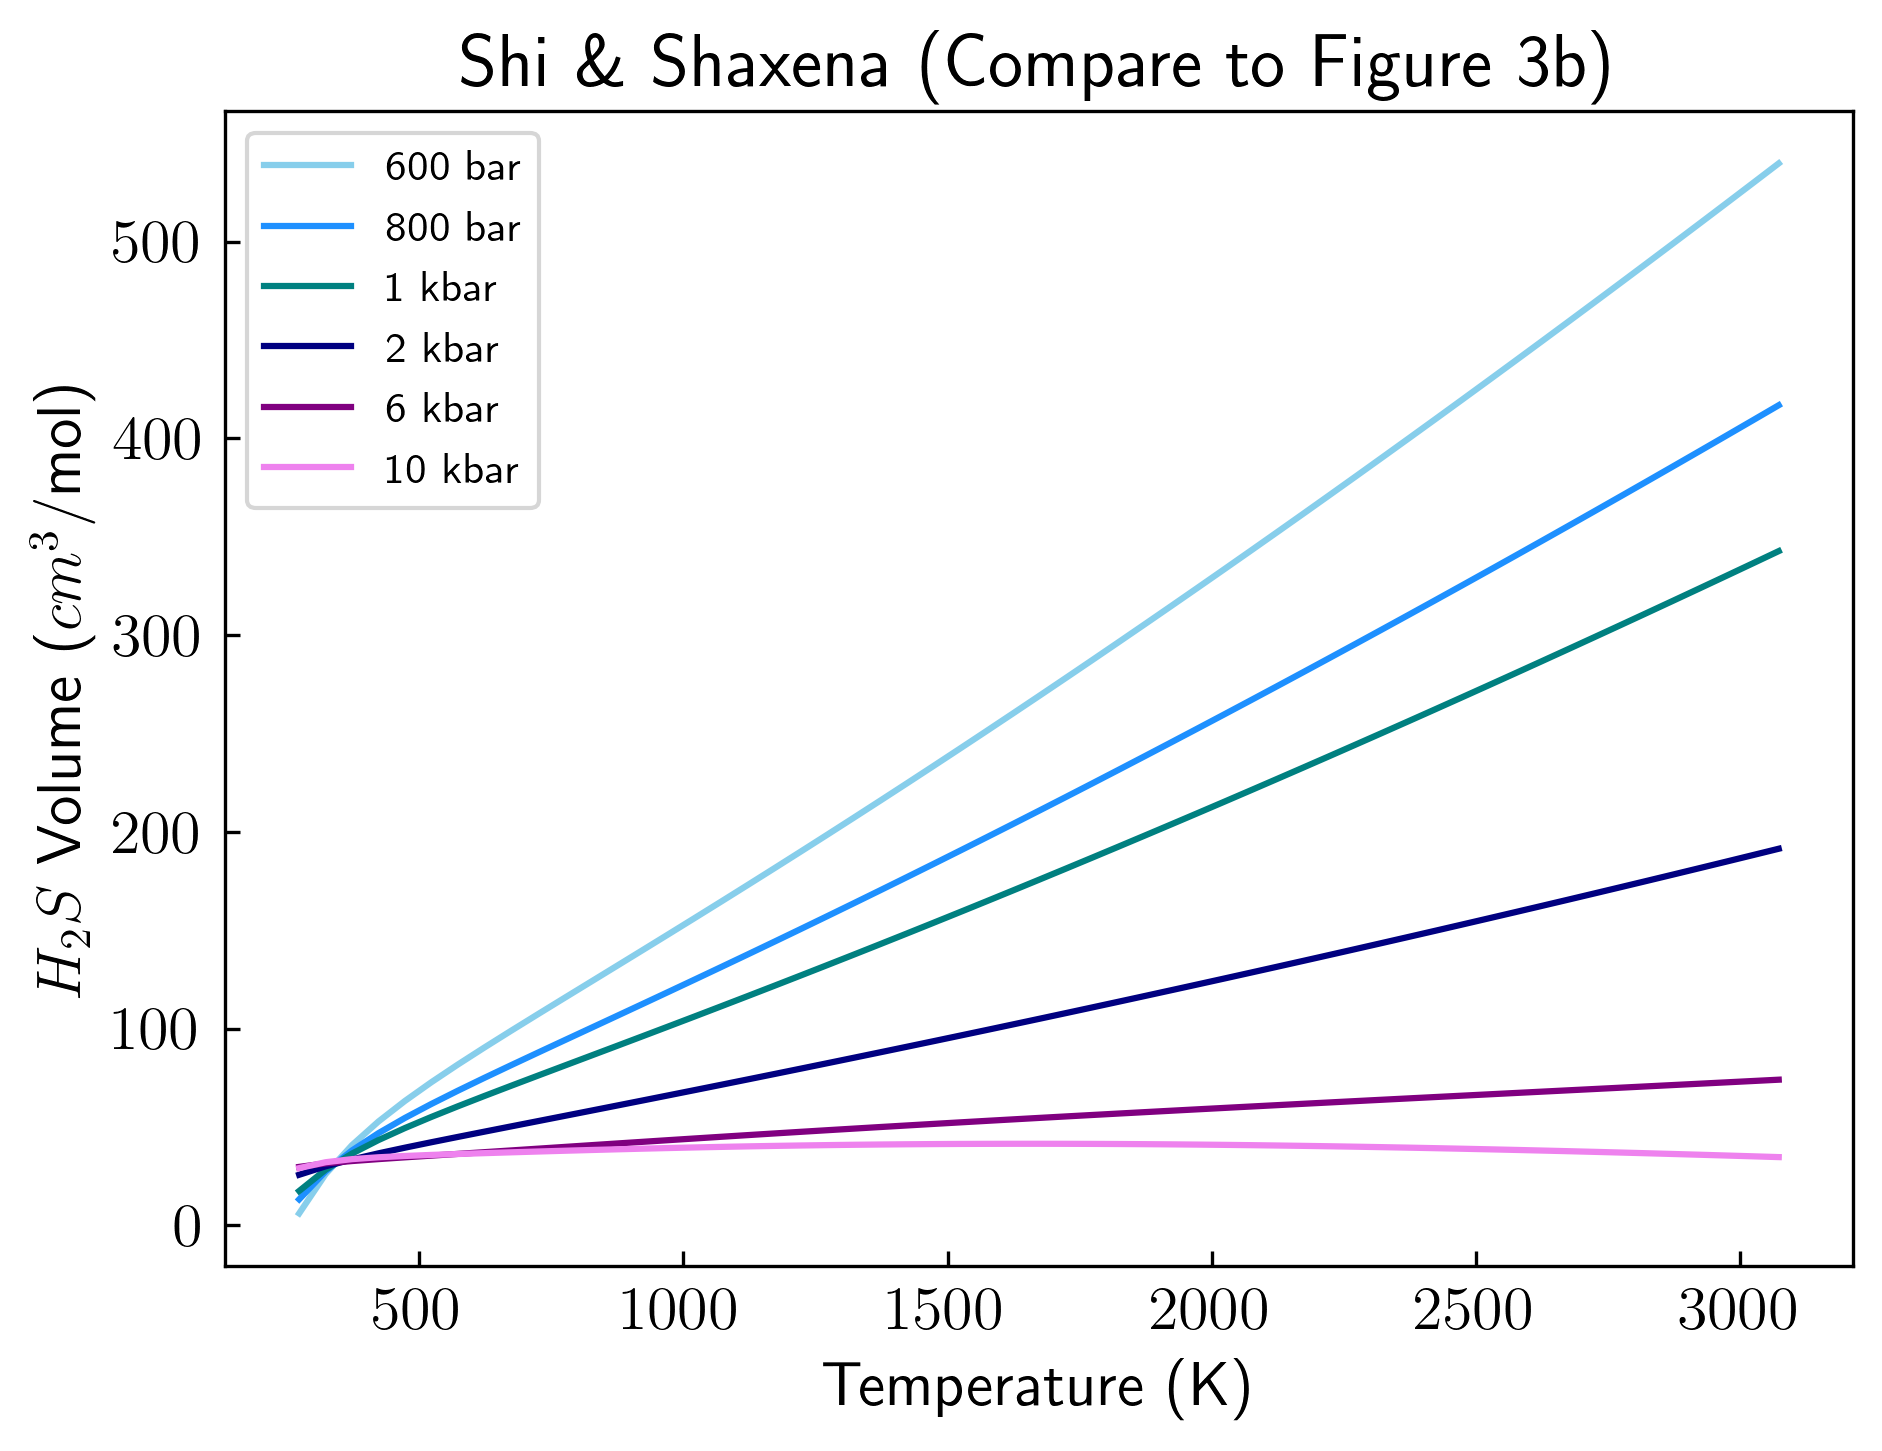

In [78]:
fig,axs = plt.subplots()
plt.plot(temp_arr_SF_hi, SS_H2S_100bars, color='skyblue', label=r'100 bar')
plt.plot(temp_arr_SF_hi, SS_H2S_150bars, color='dodgerblue', label=r'150 bar')
plt.plot(temp_arr_SF_hi, SS_H2S_225bars, color='teal', label=r'225 bar')
plt.plot(temp_arr_SF_hi, SS_H2S_300bars, color='navy', label=r'300 bar')
plt.plot(temp_arr_SF_hi, SS_H2S_500bars, color='purple', label=r'500 bar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
plt.ylim(0, 500)
plt.xlim(200, 1100)
plt.ylabel(r'$H_2S$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (Compare to Figure 3a)')
plt.savefig('VolumevsT_ShiSaxena_H2S_3a.jpg', dpi=1000)
plt.show()

fig,axs = plt.subplots()
plt.plot(temp_arr_SF_hi, SS_H2S_600bars, color='skyblue', label=r'600 bar')
plt.plot(temp_arr_SF_hi, SS_H2S_800bars, color='dodgerblue', label=r'800 bar')
plt.plot(temp_arr_SF_hi, SS_H2S_1000bars, color='teal', label=r'1 kbar')
plt.plot(temp_arr_SF_hi, SS_H2S_2000bars, color='navy', label=r'2 kbar')
plt.plot(temp_arr_SF_hi, SS_H2S_6000bars, color='purple', label=r'6 kbar')
plt.plot(temp_arr_SF_hi, SS_H2S_10000bars, color='violet', label=r'10 kbar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
#plt.ylim(0, 600)
#plt.xlim(250, 2090)
plt.ylabel(r'$H_2S$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (Compare to Figure 3b)')
plt.savefig('VolumevsT_ShiSaxena_H2S_3b.jpg', dpi=1000)
plt.show()

#### Saxena and H&P Comparison Plots

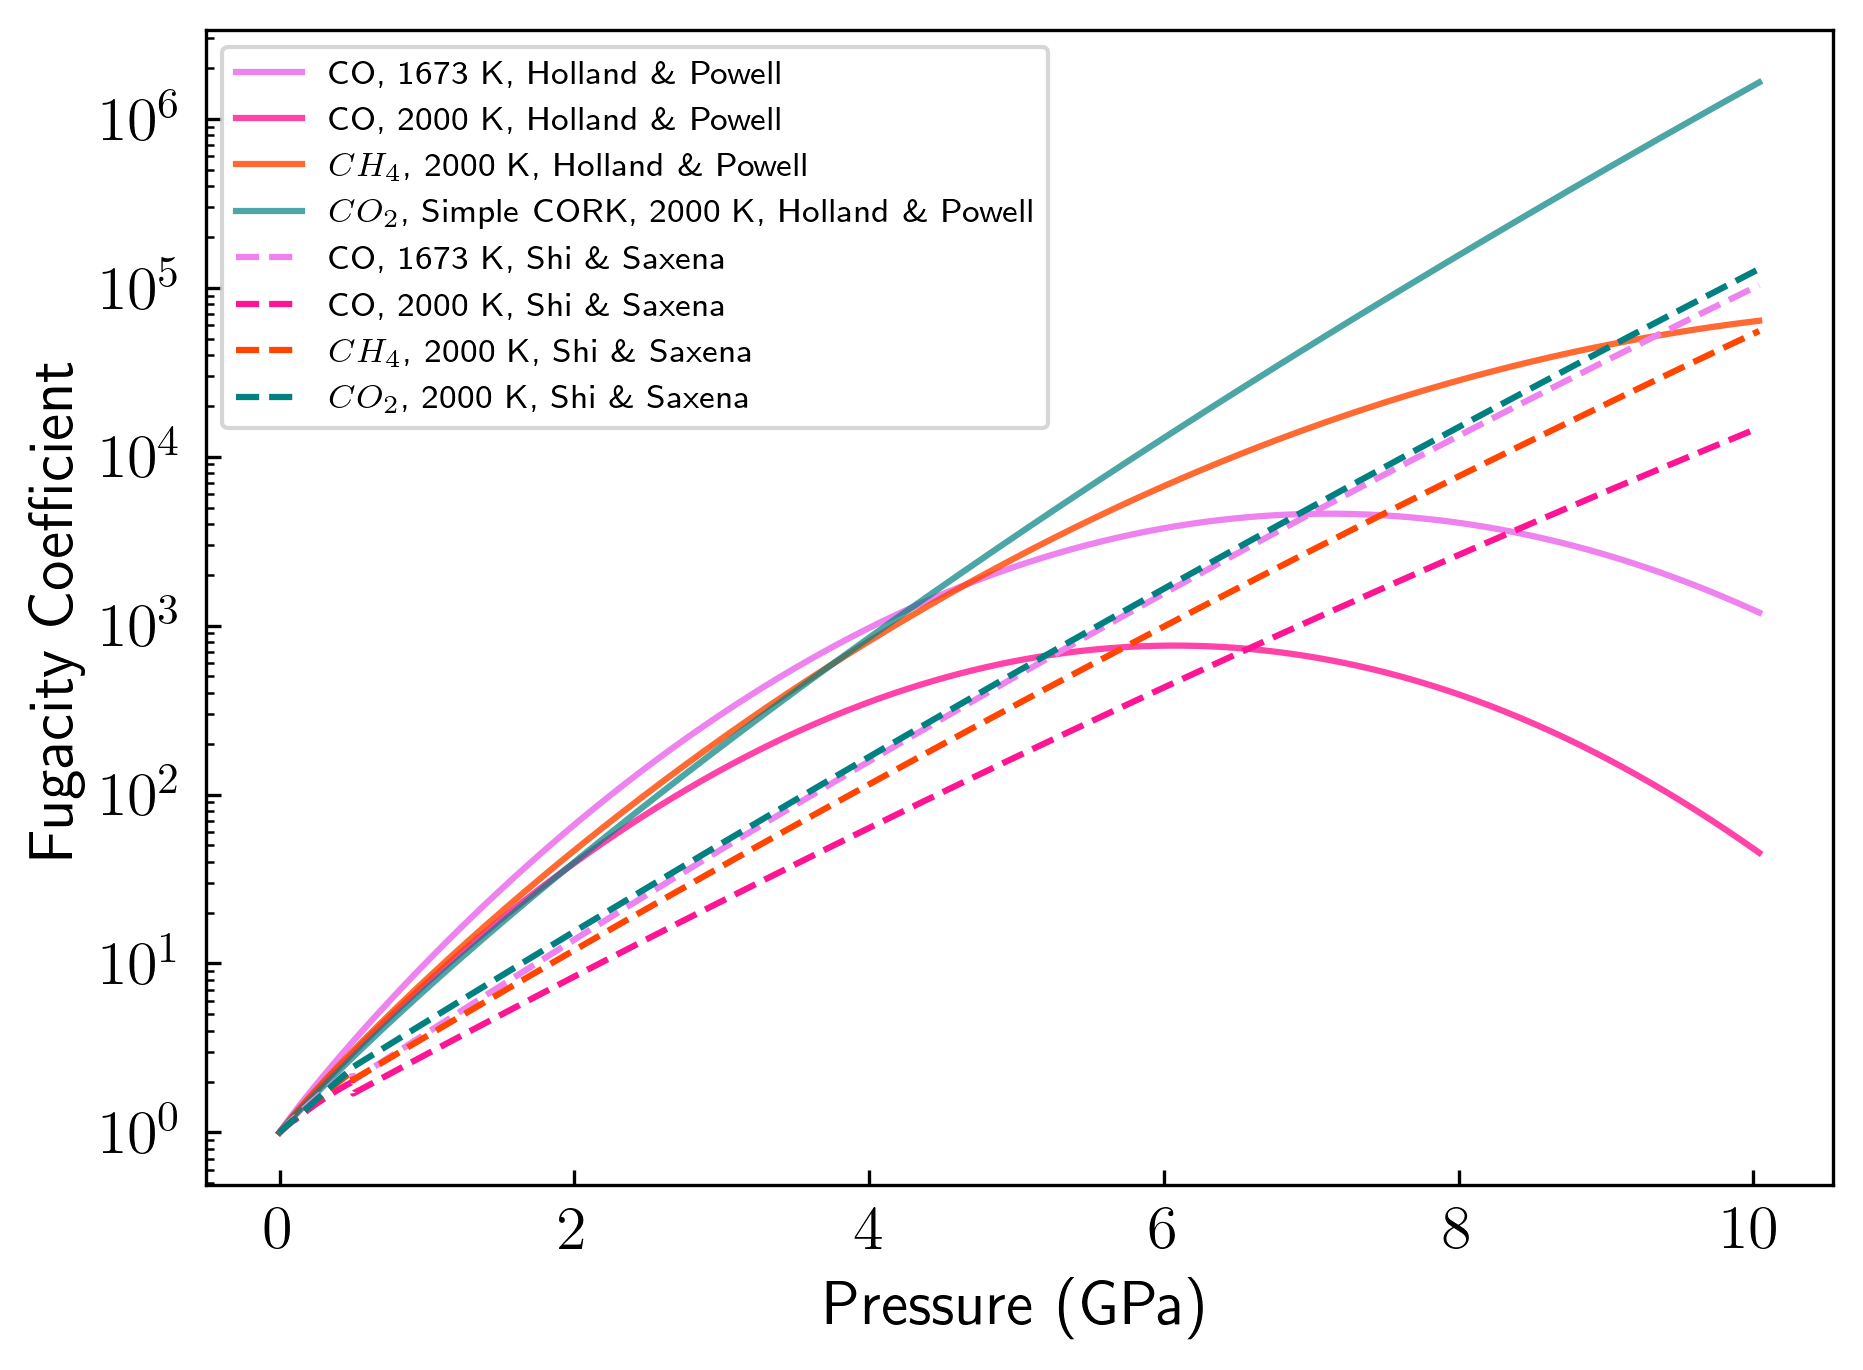

In [46]:
fig,ax = plt.subplots()
#plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue', alpha=0.8, label=r'$H_2$, 2000 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, HP_1673_CO, color='violet',  label=r'CO, 1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CO, color='deeppink', alpha=0.8, label=r'CO, 2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CH4, color='orangered',  alpha=0.8, label=r'$CH_4$, 2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000_CO2Simple, color='teal', alpha=0.7, label=r'$CO_2$, Simple CORK, 2000 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, SS_1673_CO, color='violet', linestyle='--', label=r'CO, 1673 K, Shi \& Saxena')
plt.plot(pressure_arr/1e4, SS_2000_CO, color='deeppink', linestyle='--', label=r'CO, 2000 K, Shi \& Saxena')
plt.plot(pressure_arr/1e4, SS_2000_CH4, color='orangered', linestyle='--', label=r'$CH_4$, 2000 K, Shi \& Saxena')
plt.plot(pressure_arr/1e4, SS_2000_CO2, color='teal', linestyle='--', label=r'$CO_2$, 2000 K, Shi \& Saxena')


plt.legend(fontsize=8)
plt.yscale('log')
#plt.ylim(0.1, 1e5)
#plt.xlim(-0.01, 8)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'Fugacity Coefficient')
#plt.savefig('FugacityCoefficients_HP_VariousCorrespondingStates.jpg', dpi=1000)
plt.show()

In [47]:
fig,axs = plt.subplots(2, 2)

axs[0, 0].plot(pressure_arr/1e4, np.log(HP_2000_CO), color='violet',  label=r'CO, 2000 K, Holland \& Powell')
axs[0, 0].plot(pressure_arr/1e4, np.log(SS_2000_CO), color='violet', linestyle='--', label=r'CO, 2000 K, Shi \& Saxena')

axs[0,1].plot(pressure_arr/1e4, np.log(HP_2000_CH4), color='orangered',  label=r'$CH_4$, 2000 K, Holland \& Powell')
axs[0,1].plot(pressure_arr/1e4, np.log(SS_2000_CH4), color='orangered', linestyle='--', label=r'$CH_4$, 2000 K, Shi \& Saxena')

axs[1,0].plot(pressure_arr/1e4, np.log(HP_2000_CO2Simple), color='teal',  label=r'$CO_2$, Simple CORK, 2000 K, Holland \& Powell')
axs[1,0].plot(pressure_arr/1e4, np.log(SS_2000_CO2), color='teal', linestyle='--', label=r'$CO_2$, 2000 K, Shi \& Saxena')

axs[1,1].plot(pressure_arr/1e4, np.log(HP_2000_H2S), color='dodgerblue',  label=r'$H_2S$, 2000 K, Holland \& Powell')
axs[1,1].plot(pressure_arr/1e4, np.log(SS_2000_H2S), color='dodgerblue', linestyle='--', label=r'$H_2S$, 2000 K, Shi \& Saxena')

axs[0,0].legend(fontsize=6)
axs[0,1].legend(fontsize=6)
axs[1,0].legend(fontsize=6)
axs[1,1].legend(fontsize=6)
plt.yscale('log')
#plt.ylim(0.1, 1e5)
#plt.xlim(-0.01, 8)
#plt.xscale('log')
axs[0,0].set(xlabel='Pressure (GPa)')
axs[0,0].set(ylabel=r'ln($\phi$)')
plt.tight_layout()
#plt.savefig('FugacityCoefficients_HPvsSaxena.jpg', dpi=1000)
plt.show()

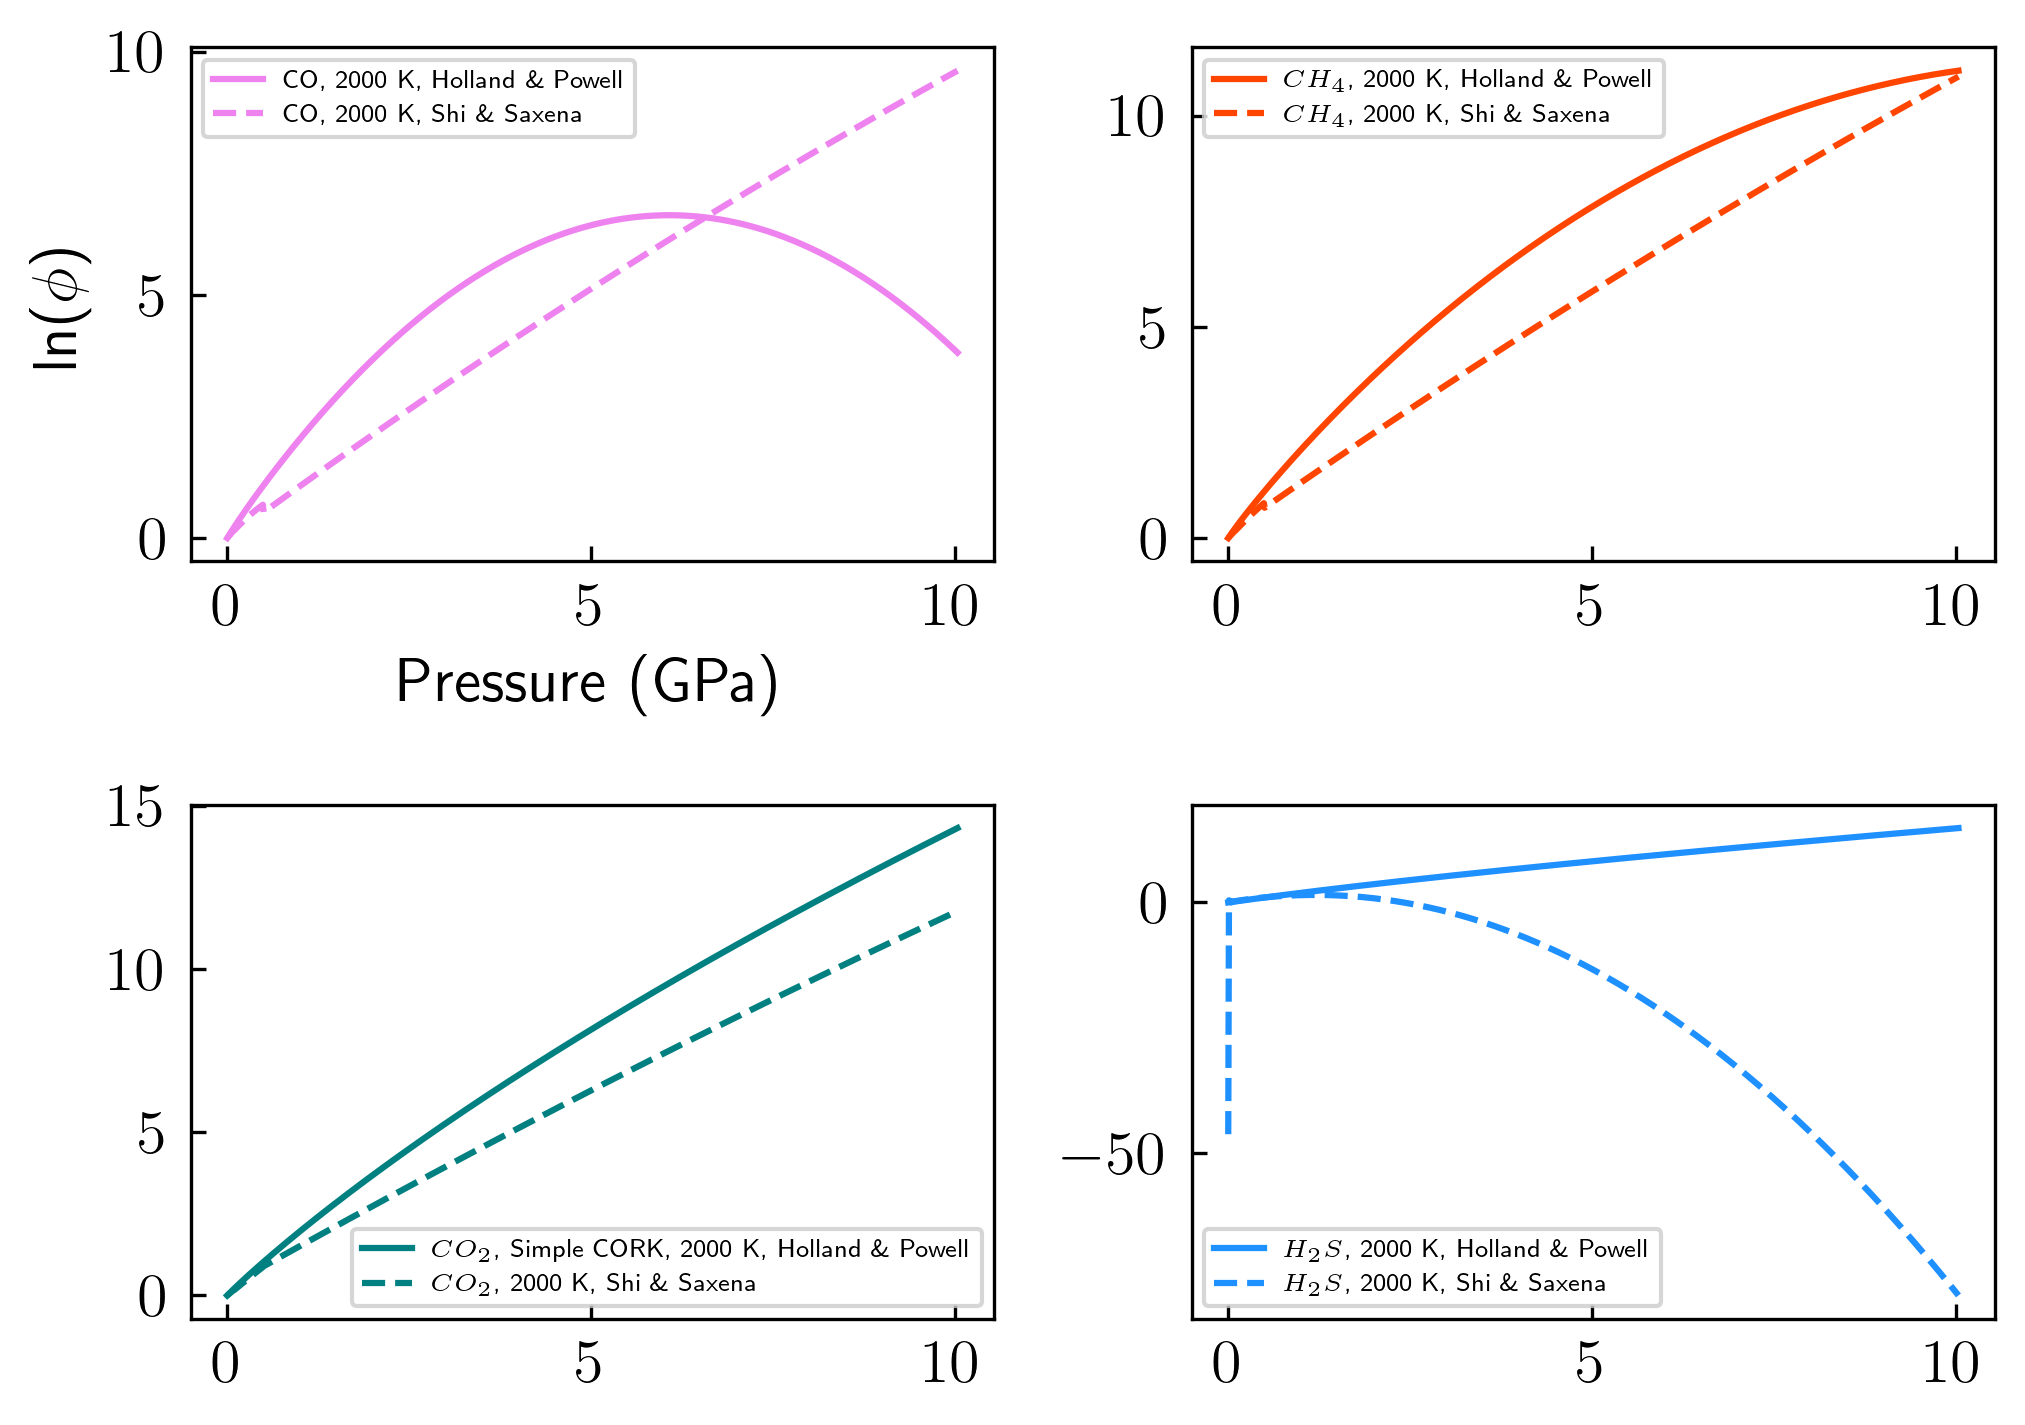

In [48]:
fig,axs = plt.subplots(2, 2)

axs[0, 0].plot(pressure_arr/1e4, np.log(HP_2000_CO), color='violet',  label=r'CO, 2000 K, Holland \& Powell')
axs[0, 0].plot(pressure_arr/1e4, np.log(SS_2000_CO), color='violet', linestyle='--', label=r'CO, 2000 K, Shi \& Saxena')

axs[0,1].plot(pressure_arr/1e4, np.log(HP_2000_CH4), color='orangered',  label=r'$CH_4$, 2000 K, Holland \& Powell')
axs[0,1].plot(pressure_arr/1e4, np.log(SS_2000_CH4), color='orangered', linestyle='--', label=r'$CH_4$, 2000 K, Shi \& Saxena')

axs[1,0].plot(pressure_arr/1e4, np.log(HP_2000_CO2Simple), color='teal',  label=r'$CO_2$, Simple CORK, 2000 K, Holland \& Powell')
axs[1,0].plot(pressure_arr/1e4, np.log(SS_2000_CO2), color='teal', linestyle='--', label=r'$CO_2$, 2000 K, Shi \& Saxena')

axs[1,1].plot(pressure_arr/1e4, np.log(HP_2000_H2S), color='dodgerblue',  label=r'$H_2S$, 2000 K, Holland \& Powell')
axs[1,1].plot(pressure_arr/1e4, np.log(SS_2000_H2S), color='dodgerblue', linestyle='--', label=r'$H_2S$, 2000 K, Shi \& Saxena')

axs[0,0].legend(fontsize=6)
axs[0,1].legend(fontsize=6)
axs[1,0].legend(fontsize=6)
axs[1,1].legend(fontsize=6)
#axs[0,0].set_xlim([0,2])
#axs[0,1].set_xlim([0,2])
#axs[1,0].set_xlim([0,2])
#axs[1,1].set_xlim([0,2])

#plt.yscale('log')
#plt.ylim(0.1, 1e5)
#plt.xlim(-0.01, 8)
#plt.xscale('log')
axs[0,0].set(xlabel='Pressure (GPa)')
axs[0,0].set(ylabel=r'ln($\phi$)')
plt.tight_layout()
#plt.savefig('FugacityCoefficients_HPvsSaxena_lnphi.jpg', dpi=1000)
plt.show()